# World Data League 2022

## 🎯 Challenge
Predicting the flow of people for public transportation improvements

## 👥 Authors
* Catarina Bento
* Cátia Correia
* José Luís Mourão
* Lúcia Moreira
* Pedro Fernandes

## 💻 Development

### Libraries needed

Installation of python libraries that were missing and import of all the libraries needed.

In [265]:
# !pip install meteostat
# !pip install lightgbm
# !pip install tabulate
# !pip install unidecode

In [266]:
import pandas as pd
import numpy as np
import datetime
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import io
import math
import unidecode
from datetime import datetime
from meteostat import Point, Hourly
from sklearn.preprocessing import OneHotEncoder
import calendar
import json
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import holidays
from calendar import monthrange
import shap
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Data Pre-processing - GTFS

We hosted the GTFS files in our virtual machine and will import them for a first look at the data, to understand the nature of the GTFS dataset.

In [267]:
agency = pd.read_csv('data/gtfs_bus/agency.txt')
calendar_dates = pd.read_csv('data/gtfs_bus/calendar_dates.txt')
calendar = pd.read_csv('data/gtfs_bus/calendar.txt')
routes = pd.read_csv('data/gtfs_bus/routes.txt')
shapes = pd.read_csv('data/gtfs_bus/shapes.txt')
stop_times = pd.read_csv('data/gtfs_bus/stop_times.txt')
stops = pd.read_csv('data/gtfs_bus/stops.txt')
transfers = pd.read_csv('data/gtfs_bus/transfers.txt')
trips = pd.read_csv('data/gtfs_bus/trips.txt')

Using the definition of the dataset on the GTFS website (https://gtfs.org/), we will use this data to analyse the number of routes.

From the definition, we will plot the 'shapes' information to see how the routes look in a cartesian plane, using the coordinates for longitude and latitude.

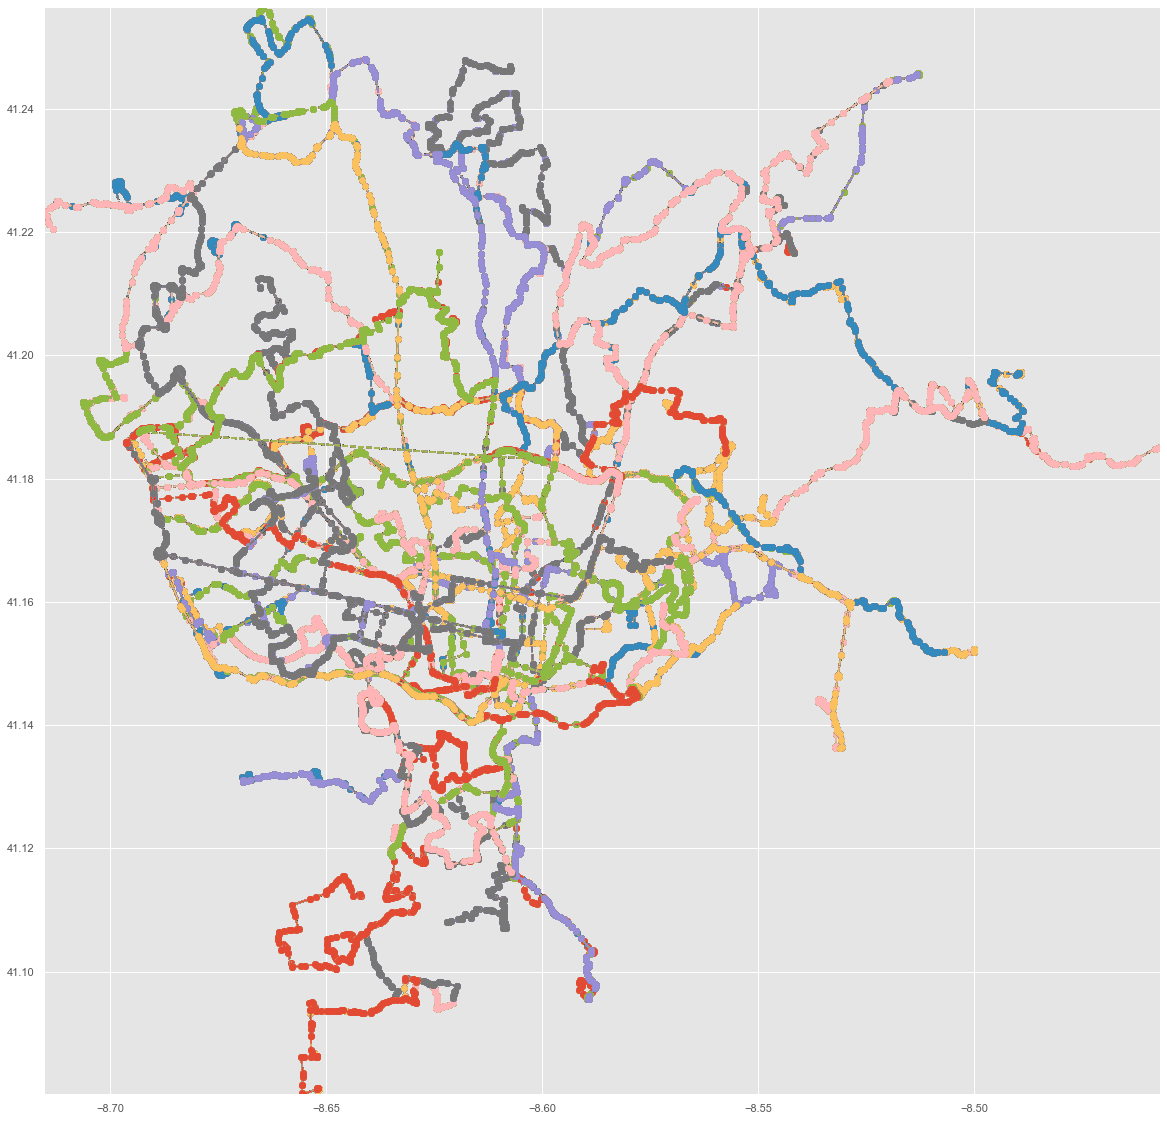

In [268]:
for route in shapes.shape_id:
#number of points
    n_points = shapes[shapes.shape_id == route].shape[0]
    
#sample coordinates
    x_c = list(shapes[shapes.shape_id == route].shape_pt_lon)
    y_c = list(shapes[shapes.shape_id == route].shape_pt_lat)

#sorting coordinates
    x_c_sorted=[]
    y_c_sorted=[]
    for sn in range(0,n_points):
        x_c_sorted.append(x_c[sn])
        y_c_sorted.append(y_c[sn])
#plotting
    plt.rcParams["figure.figsize"] = (20,20)
    plt.plot(x_c_sorted, y_c_sorted, '--o')
    plt.xlim([shapes.shape_pt_lon.min(),shapes.shape_pt_lon.max()])
    plt.ylim([shapes.shape_pt_lat.min(),shapes.shape_pt_lat.max()])

plt.show()

We can clearly see the "definition" of roads/streets and borders of Porto, especially when comparing with this image from Google Maps.

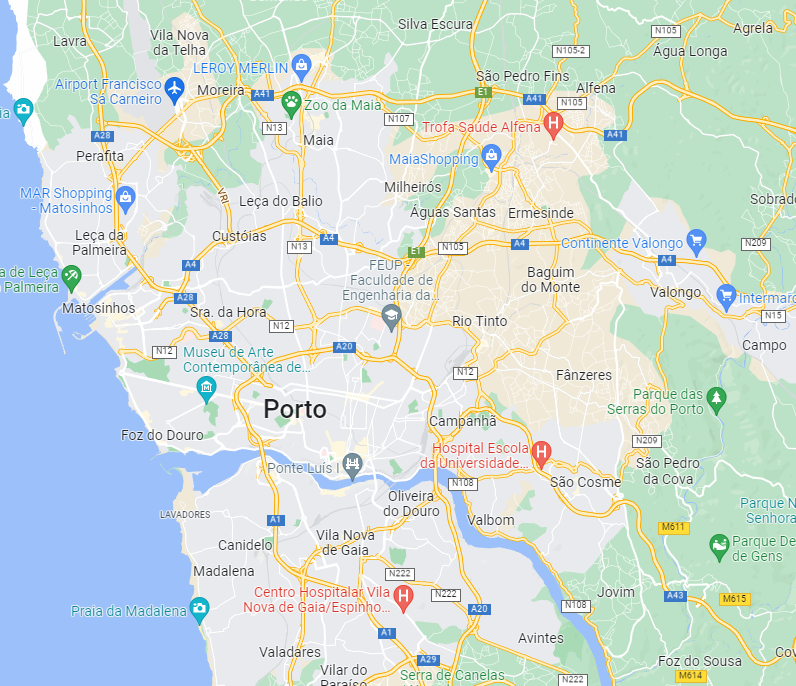

We will get now only the necessary tables for our analysis, for both bus and metro.

The goal of the next few steps is to extract the data from the GTFS format for Porto Metro and STCP, creating a single dataset with routes, zones and cities and their corresponding capacity, to then be able to correlate with mobility data from other datasets and obtain the usage and coverage of the public transport network vs the real flow of people intercities.

In [269]:
stops["provider"]="STCP"

stop_times_metro = pd.read_csv('data/gtfs_metro/stop_times.txt')
stops_metro = pd.read_csv('data/gtfs_metro/stops.txt')
stops_metro["provider"] = "METRO"
stops_metro["stop_code"] = stops_metro["stop_name"]
trips_metro = pd.read_csv('data/gtfs_metro/trips.txt')
frequencies = pd.read_csv('data/gtfs_metro/frequencies.txt')

# Merge Metro and STCP data

stops = stops.append(stops_metro)
stop_times = stop_times.append(stop_times_metro)
trips = trips.append(trips_metro)

Since there are a lot of entrances/exits in public transportation (each stop is a place of entrance and/or exit), we believe it makes sense to aggregate the information and group by municipality.

In [270]:
#Get city from zone_id

def get_city(r):
    city=""
    if "PRT" in r["zone_id"]:
        city="PORTO"
    if "GDM" in r["zone_id"]:
        city="GONDOMAR"
    if "VLG" in r["zone_id"]:
        city="VALONGO"
    if "MAI" in r["zone_id"]:
        city="MAIA"
    if "VNG" in r["zone_id"]:
        city="VILA NOVA DE GAIA"
    if "VCD" in r["zone_id"]:
        city="VILA DO CONDE"
    if "PV_VC" in r["zone_id"]:
        city="VILA DO CONDE"
    if "MTS" in r["zone_id"]:
        city="MATOSINHOS"
    if city=="":
        city="OTHER"
    r["city"]=city
    return r

stops_city = stops.apply(lambda r:get_city(r),axis=1)
stops_city

stop_id                  stop_code                  stop_name   stop_lat  \
0    VFRR1                      VFRR1             VALE FERREIROS  41.181083   
1     ECC2                       ECC2             ENTRE CANCELAS  41.181833   
2     MTP2                       MTP2                MONTE PEDRO  41.189528   
3    ASRR4                      ASRR4              ALTO DA SERRA  41.193022   
4    VFRR2                      VFRR2             VALE FERREIROS  41.181167   
..     ...                        ...                        ...        ...   
79      80                   Carreira                   Carreira  41.179825   
80      81                 Venda Nova                 Venda Nova  41.175157   
81      82                   Fanzeres                   Fanzeres  41.171300   
82      83               Santo Ovidio               Santo Ovidio  41.115548   
83      84  VC Fashion Outlet Modivas  VC Fashion Outlet Modivas  41.300492   

    stop_lon zone_id                                           stop_url  \
0  -8.535056    GDM1  http://www.stcp.pt/pt/viajar/paragens/?t=detal...   
1  -8.532444    GDM1  http://www.stcp.pt/pt/viajar/paragens/?t=detal...   
2  -8.524389    GDM1  http://www.stcp.pt/pt/viajar/paragens/?t=detal...   
3  -8.518383    GDM1  http://www.stcp.pt/pt/viajar/paragens/?t=detal...   
4  -8.535056    GDM1  http://www.stcp.pt/pt/viajar/paragens/?t=detal...   
..       ...     ...                                                ...   
79 -8.543604    MAI4                                                NaN   
80 -8.541962    GDM1                                                NaN   
81 -8.542938    GDM1                                                NaN   
82 -8.606555    VNG1                                                NaN   
83 -8.704004    VCD8                                                NaN   

   provider  stop_desc               city  
0      STCP        NaN           GONDOMAR  
1      STCP        NaN           GONDOMAR  
2      STCP        NaN           GONDOMAR  
3      STCP        NaN           GONDOMAR  
4      STCP        NaN           GONDOMAR  
..      ...        ...                ...  
79    METRO        NaN               MAIA  
80    METRO        NaN           GONDOMAR  
81    METRO        NaN           GONDOMAR  
82    METRO        NaN  VILA NOVA DE GAIA  
83    METRO        NaN      VILA DO CONDE  

[2567 rows x 10 columns]

Trips per day is the sum of the trips planned, except if it exists on the frequencies.txt file - Metro Only

In [271]:
def time_to_int(r):
    if (len(r)==8):
        i=int(r[:2])*60+int(r[3:5])+int(r[6:8])/60
    else:
        i=int(r[0])*60+int(r[2:4])+int(r[5:7])/60  
    return i

def get_trip_count(r):
    return (time_to_int(r["end_time"].values[0])-time_to_int(r["start_time"].values[0]))/(r["headway_secs"].values[0]/60)


trip_frequency=frequencies.groupby("trip_id").apply(lambda r:get_trip_count(r)).reset_index()
trip_frequency.columns=["trip_id","trip_frequency"]
trip_frequency

#Get merged dataset

stop_times_route=stop_times.merge(trips, how="left", left_on="trip_id",right_on="trip_id").merge(stops_city,how="left",left_on="stop_id",right_on="stop_id").merge(trip_frequency,how="left",left_on="trip_id",right_on="trip_id")

stop_times_route=stop_times_route[["stop_id","city","trip_id","arrival_time","departure_time","stop_sequence","route_id","direction_id","service_id","zone_id","provider","trip_frequency"]]

stop_times_route["trip_frequency"]=stop_times_route["trip_frequency"].fillna(1)

stop_times_route

stop_id   city    trip_id arrival_time departure_time  stop_sequence  \
0        BFAL1  PORTO  107_0_D_6      8:47:47        8:47:47              7   
1        MCAM3  PORTO  107_0_D_6      8:48:27        8:48:27              8   
2        ICAM1  PORTO  107_0_D_6      8:49:12        8:49:12              9   
3        QBNJ2  PORTO  107_0_D_6      8:50:53        8:50:53             10   
4        TBNJ2  PORTO  107_0_D_6      8:51:42        8:51:42             11   
...        ...    ...        ...          ...            ...            ...   
858503       6  PORTO      CUF57     20:03:40       20:04:00             16   
858504       5  PORTO      CUF57     20:05:40       20:06:00             17   
858505       4  PORTO      CUF57     20:06:40       20:07:00             18   
858506       3  PORTO      CUF57     20:08:40       20:09:00             19   
858507       2  PORTO      CUF57     20:10:40       20:11:00             20   

       route_id  direction_id service_id zone_id provider  trip_frequency  
0           107             0        DOM    PRT3     STCP             1.0  
1           107             0        DOM    PRT3     STCP             1.0  
2           107             0        DOM    PRT3     STCP             1.0  
3           107             0        DOM    PRT3     STCP             1.0  
4           107             0        DOM    PRT3     STCP             1.0  
...         ...           ...        ...     ...      ...             ...  
858503        C             1        CUF    PRT1    METRO             1.0  
858504        C             1        CUF    PRT1    METRO             1.0  
858505        C             1        CUF    PRT1    METRO             1.0  
858506        C             1        CUF    PRT1    METRO             1.0  
858507        C             1        CUF    PRT1    METRO             1.0  

[858508 rows x 12 columns]

We will now get the start and end cities, which we define by the city where the trip start and the city where the trip ended, respectively, allowing for the detection of intercity routes.

In [272]:
def analyze(r):
    r=r.sort_values("stop_sequence", ascending=True)
    out_r=pd.Series()
    out_r["provider"]=r["provider"].values[0]
    out_r["first_stop_id"]=r["stop_id"].values[0]
    out_r["last_stop_id"]=r["stop_id"].values[len(r["stop_id"])-1]
    out_r["departure_time_route"]=r["departure_time"].values[0]
    out_r["arrival_time_route"]=r["arrival_time"].values[len(r["arrival_time"])-1]
    out_r["number_of_stops"]=len(r["stop_id"].values)
    out_r["start_zone_id"]=r["zone_id"].values[0]
    out_r["end_zone_id"]=r["zone_id"].values[len(r["zone_id"])-1]
    out_r["A"]=r["city"].values[0]
    out_r["B"]=r["city"].values[len(r["city"])-1]
    #Fill missing cities (A or B) with the existing data
    if (not out_r["A"]): out_r["A"]=out_r["B"]
    if (not out_r["B"]): out_r["B"]=out_r["A"]

    if (out_r["A"]=="PORTO"):
        starts_in_porto=True
    else:
        starts_in_porto=False
    if (out_r["B"]=="PORTO"):
        ends_in_porto=True
    else:
        ends_in_porto=False
    
    out_r["intercity"]=ends_in_porto!=starts_in_porto
    out_r["route_id"]=r["route_id"].values[0]
    out_r["direction_id"]=r["direction_id"].values[0]
    out_r["service_id"]=r["service_id"].values[0]
    out_r["trip_frequency"]=r["trip_frequency"].values[0]
    return out_r


stop_times_route_city=stop_times_route.groupby("trip_id").apply(lambda r: analyze(r) ).reset_index()
stop_times_route_city

trip_id provider first_stop_id last_stop_id departure_time_route  \
0      106_0_F_10     STCP           VAL          FRC              9:20:00   
1      106_0_F_12     STCP           VAL          FRC             10:00:00   
2      106_0_F_14     STCP           VAL          FRC             10:40:00   
3      106_0_F_16     STCP           VAL          FRC             11:20:00   
4      106_0_F_18     STCP           VAL          FRC             12:00:00   
...           ...      ...           ...          ...                  ...   
24089        FU95    METRO            14           82             17:10:00   
24090        FU96    METRO            82           14             17:20:00   
24091        FU97    METRO            14           82             17:22:00   
24092        FU98    METRO            82           14             17:32:00   
24093        FU99    METRO            14           82             17:34:00   

      arrival_time_route  number_of_stops start_zone_id end_zone_id  \
0                9:33:00               15          VNG4        VNG4   
1               10:13:00               15          VNG4        VNG4   
2               10:53:00               15          VNG4        VNG4   
3               11:33:00               15          VNG4        VNG4   
4               12:13:00               15          VNG4        VNG4   
...                  ...              ...           ...         ...   
24089           17:48:40               24          PRT2        GDM1   
24090           17:59:40               24          GDM1        PRT2   
24091           18:00:40               24          PRT2        GDM1   
24092           18:11:40               24          GDM1        PRT2   
24093           18:12:40               24          PRT2        GDM1   

                       A                  B  intercity route_id  direction_id  \
0      VILA NOVA DE GAIA  VILA NOVA DE GAIA      False      106             0   
1      VILA NOVA DE GAIA  VILA NOVA DE GAIA      False      106             0   
2      VILA NOVA DE GAIA  VILA NOVA DE GAIA      False      106             0   
3      VILA NOVA DE GAIA  VILA NOVA DE GAIA      False      106             0   
4      VILA NOVA DE GAIA  VILA NOVA DE GAIA      False      106             0   
...                  ...                ...        ...      ...           ...   
24089              PORTO           GONDOMAR       True        F             1   
24090           GONDOMAR              PORTO       True        F             0   
24091              PORTO           GONDOMAR       True        F             1   
24092           GONDOMAR              PORTO       True        F             0   
24093              PORTO           GONDOMAR       True        F             1   

      service_id  trip_frequency  
0        UTEISFE             1.0  
1        UTEISFE             1.0  
2        UTEISFE             1.0  
3        UTEISFE             1.0  
4        UTEISFE             1.0  
...          ...             ...  
24089         FU             1.0  
24090         FU             1.0  
24091         FU             1.0  
24092         FU             1.0  
24093         FU             1.0  

[24094 rows x 16 columns]

We will now aggregate data by route and day type (weekday, STCP_Holiday_Period --> variable that indicates if the trip was made during the period of STCP holidays (easter and summer)).

Then we can calculate the trips per day by route.

We will also get the capacity for each route from the vehicle type and the number of trips per day, and we will also use information available from STCP and Metro public websites.

In [273]:
#KEY DATASET - Group by route, day type (weekday, STCP_Holiday_Period) - get trip mean duration, get max capacity for route

def time_to_int(r):
    if (len(r)==8):
        i=int(r[:2])*60+int(r[3:5])+int(r[6:8])/60
    else:
        i=int(r[0])*60+int(r[2:4])+int(r[5:7])/60  
    return i

def route_analyze(r):
    out_r=r.iloc[:1]
    out_r["trips_per_day"]=sum(r["trip_frequency"])
    out_r["mean_duration"]=(r["arrival_time_route"].apply(lambda x:time_to_int(x))-r["departure_time_route"].apply(lambda x:time_to_int(x))).mean()
    if r["provider"].values[0]=="STCP":
        out_r["max_capacity"]=out_r["trips_per_day"]*90 
        #From STCP stats - https://www.stcp.pt/pt/institucional/governo-societario/indicadores-chave/
    else:
        out_r["max_capacity"]=int(out_r["trips_per_day"]*(72*295+30*248)/102)
        #From metro page https://www.metrodoporto.pt/pages/308 for number of models and technical description of models
        #http://tram-porto.ernstkers.nl/MPtrams.html
        
    return out_r

route_city_times=stop_times_route_city.groupby(["route_id","service_id","direction_id"]) \
                                      .apply(lambda r:route_analyze(r)).drop(["route_id","first_stop_id","last_stop_id","service_id","direction_id","trip_id","arrival_time_route","departure_time_route"],axis=1).reset_index().drop("level_3",axis=1)
def weekday(r):
    if "UTEIS" in r["service_id"]:
        r["Business_Day"]=1
    else:
        r["Business_Day"]=0  
    if "FE" in r["service_id"]:
        r["STCP_Holiday_Period"]=1
    else:
        r["STCP_Holiday_Period"]=0  
    return r

route_city_times=route_city_times.apply(lambda r: weekday(r),axis=1).drop("service_id",axis=1)
route_city_times=route_city_times.groupby(["route_id","Business_Day","STCP_Holiday_Period"]) \
                                 .agg({"max_capacity":"mean","mean_duration":"mean","trips_per_day":"mean","direction_id":"first", \
                                       "provider":"first","number_of_stops":"first","start_zone_id":"first","end_zone_id":"first", \
                                       "A":"first","B":"first","intercity":"first"}).reset_index().drop("direction_id",axis=1)

def swap_cities(r):
    if r["B"]!="PORTO":
        aux=r["B"]
        r["B"]=r["A"]
        r["A"]=aux
        aux=r["start_zone_id"]
        r["start_zone_id"]=r["end_zone_id"]
        r["end_zone_id"]=aux
    return r


route_city_times=route_city_times.apply(lambda r: swap_cities(r),axis=1)
route_city_times

route_id  Business_Day  STCP_Holiday_Period  max_capacity  mean_duration  \
0          1             0                    0   2970.000000      21.636364   
1          1             1                    0   2970.000000      21.636364   
2        106             1                    0   1890.000000      13.000000   
3        106             1                    1   1890.000000      13.000000   
4        107             0                    0   1170.000000      20.000000   
..       ...           ...                  ...           ...            ...   
283        C             0                    0  10262.500000      39.188041   
284        D             0                    0  20864.000000      26.000000   
285        E             0                    0  10684.000000      26.750000   
286        F             0                    0  13730.166667      38.821861   
287       FG             0                    0  30577.500000       4.666667   

     trips_per_day provider  number_of_stops start_zone_id end_zone_id  \
0        33.000000     STCP               13          PRT1        PRT2   
1        33.000000     STCP               13          PRT1        PRT2   
2        21.000000     STCP               15          VNG4        VNG4   
3        21.000000     STCP               15          VNG4        VNG4   
4        13.000000     STCP               26          PRT1        PRT3   
..             ...      ...              ...           ...         ...   
283      36.500000    METRO               24          MAI2        PRT1   
284      74.205556    METRO               15          VNG1        PRT3   
285      38.000000    METRO               16          VCD8        PRT1   
286      48.833333    METRO               24          GDM1        PRT2   
287     108.750000    METRO                2          PRT1        PRT1   

                     A                  B  intercity  
0                PORTO              PORTO      False  
1                PORTO              PORTO      False  
2    VILA NOVA DE GAIA  VILA NOVA DE GAIA      False  
3    VILA NOVA DE GAIA  VILA NOVA DE GAIA      False  
4                PORTO              PORTO      False  
..                 ...                ...        ...  
283               MAIA              PORTO       True  
284  VILA NOVA DE GAIA              PORTO       True  
285      VILA DO CONDE              PORTO       True  
286           GONDOMAR              PORTO       True  
287              PORTO              PORTO      False  

[288 rows x 13 columns]

Now we need to fill missing data for routes without business days/holidays combinations.

In [274]:
#Fill missing day types (Day_of_Week and holiday) with priority: same holiday value => same Business_Day => Business_Day = 1
route_city_times_fill=route_city_times
for r in route_city_times_fill["route_id"].unique():
    for j in [0,1]:
        for i in [0,1]:
            not_exists=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==i)&(route_city_times["STCP_Holiday_Period"]==j)].shape[0]==0
            if not_exists:
                if j==1:
                    new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==i)&(route_city_times["STCP_Holiday_Period"]==1)]
                    if new_rows.shape[0]==0:
                        new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==1)&(route_city_times["STCP_Holiday_Period"]==1)]
                    if new_rows.shape[0]==0:
                        new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==0)&(route_city_times["STCP_Holiday_Period"]==1)]
                    if new_rows.shape[0]==0:
                        new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==i)&(route_city_times["STCP_Holiday_Period"]==0)]
                    if new_rows.shape[0]==0:
                        new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==1)&(route_city_times["STCP_Holiday_Period"]==0)]
                    if new_rows.shape[0]==0:
                        new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==0)&(route_city_times["STCP_Holiday_Period"]==0)]
                else:
                    new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==i)&(route_city_times["STCP_Holiday_Period"]==0)]
                    if new_rows.shape[0]==0:
                        new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==1)&(route_city_times["STCP_Holiday_Period"]==0)]
                    if new_rows.shape[0]==0:
                        new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==0)&(route_city_times["STCP_Holiday_Period"]==0)]
                    if new_rows.shape[0]==0:
                        new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==i)&(route_city_times["STCP_Holiday_Period"]==1)]
                    if new_rows.shape[0]==0:
                        new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==1)&(route_city_times["STCP_Holiday_Period"]==1)]
                    if new_rows.shape[0]==0:
                        new_rows=route_city_times_fill[(route_city_times_fill["route_id"]==r)&(route_city_times["Business_Day"]==0)&(route_city_times["STCP_Holiday_Period"]==1)]
                new_rows["Business_Day"]=i
                new_rows["STCP_Holiday_Period"]=j
                route_city_times_fill=route_city_times_fill.append(new_rows).reset_index(drop=True).drop_duplicates()

Since we are checking for intercity trips only, we will filter these.

In [275]:
route_intercity_times=route_city_times_fill[route_city_times_fill["intercity"]==True]
route_intercity_times

route_id  Business_Day  STCP_Holiday_Period  max_capacity  mean_duration  \
8        10M             0                    0    450.000000      25.000000   
9        10M             0                    1    450.000000      25.000000   
10       10M             1                    0    450.000000      25.000000   
11       10M             1                    1    450.000000      25.000000   
12       11M             0                    0    450.000000      25.000000   
..       ...           ...                  ...           ...            ...   
312        E             0                    1  10684.000000      26.750000   
313        E             1                    1  10684.000000      26.750000   
314        F             1                    0  13730.166667      38.821861   
315        F             0                    1  13730.166667      38.821861   
316        F             1                    1  13730.166667      38.821861   

     trips_per_day provider  number_of_stops start_zone_id end_zone_id  \
8         5.000000     STCP               29          VNG2        PRT1   
9         5.000000     STCP               29          VNG2        PRT1   
10        5.000000     STCP               29          VNG2        PRT1   
11        5.000000     STCP               29          VNG2        PRT1   
12        5.000000     STCP               33          VNG4        PRT3   
..             ...      ...              ...           ...         ...   
312      38.000000    METRO               16          VCD8        PRT1   
313      38.000000    METRO               16          VCD8        PRT1   
314      48.833333    METRO               24          GDM1        PRT2   
315      48.833333    METRO               24          GDM1        PRT2   
316      48.833333    METRO               24          GDM1        PRT2   

                     A      B  intercity  
8    VILA NOVA DE GAIA  PORTO       True  
9    VILA NOVA DE GAIA  PORTO       True  
10   VILA NOVA DE GAIA  PORTO       True  
11   VILA NOVA DE GAIA  PORTO       True  
12   VILA NOVA DE GAIA  PORTO       True  
..                 ...    ...        ...  
312      VILA DO CONDE  PORTO       True  
313      VILA DO CONDE  PORTO       True  
314           GONDOMAR  PORTO       True  
315           GONDOMAR  PORTO       True  
316           GONDOMAR  PORTO       True  

[203 rows x 13 columns]

We will also check the following:
 - the route capacity per day type per provider - for intercity routes only
 - the zone capacity per day type - for intercity routes only
 - the flow from/to cities capacity per day type per provider - for intercity routes only
 - the flow from/to cities capacity per day type - for intercity routes only

In [276]:
zone_intercity_times_provider=route_intercity_times[["start_zone_id","end_zone_id","Business_Day","STCP_Holiday_Period",'number_of_stops',"mean_duration",'trips_per_day',"max_capacity","A","B","provider"]].groupby(["start_zone_id","end_zone_id","Business_Day","STCP_Holiday_Period","provider"]).agg({'number_of_stops': 'mean',"mean_duration": 'mean', "max_capacity": 'sum','trips_per_day': 'sum'}).reset_index()
zone_intercity_times_provider

start_zone_id end_zone_id  Business_Day  STCP_Holiday_Period provider  \
0            GDM1        PRT1             0                    0     STCP   
1            GDM1        PRT1             0                    1     STCP   
2            GDM1        PRT1             1                    0     STCP   
3            GDM1        PRT1             1                    1     STCP   
4            GDM1        PRT2             0                    0    METRO   
..            ...         ...           ...                  ...      ...   
108          VNG4        PRT3             0                    1     STCP   
109          VNG4        PRT3             1                    0     STCP   
110          VNG4        PRT3             1                    1     STCP   
111          VNG5        PRT1             1                    0     STCP   
112          VNG5        PRT1             1                    1     STCP   

     number_of_stops  mean_duration  max_capacity  trips_per_day  
0               31.0      25.984440   2092.500000      23.250000  
1               31.0      25.984440   2092.500000      23.250000  
2               36.0      34.014664   9495.000000     105.500000  
3               36.0      32.994313   8460.000000      94.000000  
4               24.0      38.821861  13730.166667      48.833333  
..               ...            ...           ...            ...  
108             33.0      25.000000    450.000000       5.000000  
109             33.0      25.000000    450.000000       5.000000  
110             33.0      25.000000    450.000000       5.000000  
111             29.0      35.811111   4140.000000      46.000000  
112             29.0      34.987578   3960.000000      44.000000  

[113 rows x 9 columns]

In [277]:
zone_intercity_times=route_intercity_times[["start_zone_id","end_zone_id","Business_Day","STCP_Holiday_Period",'number_of_stops',"mean_duration",'trips_per_day',"max_capacity","A","B","provider"]].groupby(["start_zone_id","end_zone_id","Business_Day","STCP_Holiday_Period","provider"]).agg({'number_of_stops': 'mean',"mean_duration": 'mean', "max_capacity": 'sum','trips_per_day': 'sum'}).reset_index()
zone_intercity_times

start_zone_id end_zone_id  Business_Day  STCP_Holiday_Period provider  \
0            GDM1        PRT1             0                    0     STCP   
1            GDM1        PRT1             0                    1     STCP   
2            GDM1        PRT1             1                    0     STCP   
3            GDM1        PRT1             1                    1     STCP   
4            GDM1        PRT2             0                    0    METRO   
..            ...         ...           ...                  ...      ...   
108          VNG4        PRT3             0                    1     STCP   
109          VNG4        PRT3             1                    0     STCP   
110          VNG4        PRT3             1                    1     STCP   
111          VNG5        PRT1             1                    0     STCP   
112          VNG5        PRT1             1                    1     STCP   

     number_of_stops  mean_duration  max_capacity  trips_per_day  
0               31.0      25.984440   2092.500000      23.250000  
1               31.0      25.984440   2092.500000      23.250000  
2               36.0      34.014664   9495.000000     105.500000  
3               36.0      32.994313   8460.000000      94.000000  
4               24.0      38.821861  13730.166667      48.833333  
..               ...            ...           ...            ...  
108             33.0      25.000000    450.000000       5.000000  
109             33.0      25.000000    450.000000       5.000000  
110             33.0      25.000000    450.000000       5.000000  
111             29.0      35.811111   4140.000000      46.000000  
112             29.0      34.987578   3960.000000      44.000000  

[113 rows x 9 columns]

In [278]:
intercity_times_provider=route_intercity_times[["A","B","Business_Day","STCP_Holiday_Period",'number_of_stops',"mean_duration",'trips_per_day',"max_capacity","provider"]].groupby(["A","B","Business_Day","STCP_Holiday_Period","provider"]).agg({'number_of_stops': 'mean',"mean_duration": 'mean', "max_capacity": 'sum','trips_per_day': 'sum'}).reset_index()
intercity_times_provider

A      B  Business_Day  STCP_Holiday_Period provider  \
0            GONDOMAR  PORTO             0                    0    METRO   
1            GONDOMAR  PORTO             0                    0     STCP   
2            GONDOMAR  PORTO             0                    1    METRO   
3            GONDOMAR  PORTO             0                    1     STCP   
4            GONDOMAR  PORTO             1                    0    METRO   
5            GONDOMAR  PORTO             1                    0     STCP   
6            GONDOMAR  PORTO             1                    1    METRO   
7            GONDOMAR  PORTO             1                    1     STCP   
8                MAIA  PORTO             0                    0    METRO   
9                MAIA  PORTO             0                    0     STCP   
10               MAIA  PORTO             0                    1    METRO   
11               MAIA  PORTO             0                    1     STCP   
12               MAIA  PORTO             1                    0    METRO   
13               MAIA  PORTO             1                    0     STCP   
14               MAIA  PORTO             1                    1    METRO   
15               MAIA  PORTO             1                    1     STCP   
16         MATOSINHOS  PORTO             0                    0    METRO   
17         MATOSINHOS  PORTO             0                    0     STCP   
18         MATOSINHOS  PORTO             0                    1    METRO   
19         MATOSINHOS  PORTO             0                    1     STCP   
20         MATOSINHOS  PORTO             1                    0    METRO   
21         MATOSINHOS  PORTO             1                    0     STCP   
22         MATOSINHOS  PORTO             1                    1    METRO   
23         MATOSINHOS  PORTO             1                    1     STCP   
24            VALONGO  PORTO             0                    0     STCP   
25            VALONGO  PORTO             0                    1     STCP   
26            VALONGO  PORTO             1                    0     STCP   
27            VALONGO  PORTO             1                    1     STCP   
28      VILA DO CONDE  PORTO             0                    0    METRO   
29      VILA DO CONDE  PORTO             0                    0     STCP   
30      VILA DO CONDE  PORTO             0                    1    METRO   
31      VILA DO CONDE  PORTO             0                    1     STCP   
32      VILA DO CONDE  PORTO             1                    0    METRO   
33      VILA DO CONDE  PORTO             1                    0     STCP   
34      VILA DO CONDE  PORTO             1                    1    METRO   
35      VILA DO CONDE  PORTO             1                    1     STCP   
36  VILA NOVA DE GAIA  PORTO             0                    0    METRO   
37  VILA NOVA DE GAIA  PORTO             0                    0     STCP   
38  VILA NOVA DE GAIA  PORTO             0                    1    METRO   
39  VILA NOVA DE GAIA  PORTO             0                    1     STCP   
40  VILA NOVA DE GAIA  PORTO             1                    0    METRO   
41  VILA NOVA DE GAIA  PORTO             1                    0     STCP   
42  VILA NOVA DE GAIA  PORTO             1                    1    METRO   
43  VILA NOVA DE GAIA  PORTO             1                    1     STCP   

    number_of_stops  mean_duration  max_capacity  trips_per_day  
0         24.000000      38.821861  13730.166667      48.833333  
1         34.833333      31.225870  11025.000000     122.500000  
2         24.000000      38.821861  13730.166667      48.833333  
3         34.833333      31.225870  11025.000000     122.500000  
4         24.000000      38.821861  13730.166667      48.833333  
5         37.500000      34.029565  20025.000000     222.500000  
6         24.000000      38.821861  13730.166667      48.833333  
7         37.500000      33.397689  18045.000000     200.500000  
8    

In [279]:
#KEY DATASET - dataset for cities
intercity_times=route_intercity_times[["A","B","Business_Day","STCP_Holiday_Period",'number_of_stops',"mean_duration",'trips_per_day',"max_capacity"]].groupby(["A","B","Business_Day","STCP_Holiday_Period",]).agg({'number_of_stops': 'mean',"mean_duration": 'mean', "max_capacity": 'sum','trips_per_day': 'sum'}).reset_index()
intercity_times

A      B  Business_Day  STCP_Holiday_Period  \
0            GONDOMAR  PORTO             0                    0   
1            GONDOMAR  PORTO             0                    1   
2            GONDOMAR  PORTO             1                    0   
3            GONDOMAR  PORTO             1                    1   
4                MAIA  PORTO             0                    0   
5                MAIA  PORTO             0                    1   
6                MAIA  PORTO             1                    0   
7                MAIA  PORTO             1                    1   
8          MATOSINHOS  PORTO             0                    0   
9          MATOSINHOS  PORTO             0                    1   
10         MATOSINHOS  PORTO             1                    0   
11         MATOSINHOS  PORTO             1                    1   
12            VALONGO  PORTO             0                    0   
13            VALONGO  PORTO             0                    1   
14            VALONGO  PORTO             1                    0   
15            VALONGO  PORTO             1                    1   
16      VILA DO CONDE  PORTO             0                    0   
17      VILA DO CONDE  PORTO             0                    1   
18      VILA DO CONDE  PORTO             1                    0   
19      VILA DO CONDE  PORTO             1                    1   
20  VILA NOVA DE GAIA  PORTO             0                    0   
21  VILA NOVA DE GAIA  PORTO             0                    1   
22  VILA NOVA DE GAIA  PORTO             1                    0   
23  VILA NOVA DE GAIA  PORTO             1                    1   

    number_of_stops  mean_duration  max_capacity  trips_per_day  
0         33.285714      32.311012  24755.166667     171.333333  
1         33.285714      32.311012  24755.166667     171.333333  
2         35.571429      34.714178  33755.166667     271.333333  
3         35.571429      34.172571  31775.166667     249.333333  
4         38.818182      36.084361  26867.500000     221.000000  
5         38.818182      36.084361  26867.500000     221.000000  
6         36.363636      41.014289  39107.500000     357.000000  
7         37.181818      40.428645  37892.500000     343.500000  
8         39.636364      38.653175  34301.833333     270.727778  
9         39.636364      38.653175  34301.833333     270.727778  
10        39.636364      42.734445  47464.333333     416.977778  
11        41.363636      42.532341  46969.333333     411.477778  
12        44.750000      42.740638   7717.500000      85.750000  
13        44.750000      42.740638   7717.500000      85.750000  
14        46.000000      48.878788  15120.000000     168.000000  
15        49.000000      46.841989  14220.000000     158.000000  
16        32.000000      42.843434  33346.500000     151.750000  
17        32.000000      42.843434  33346.500000     151.750000  
18        36.142857      45.547784  41289.000000     240.000000  
19        36.142857      45.189885  40704.000000     233.500000  
20        33.727273      31.927805  39201.500000     277.955556  
21        33.727273      31.927805  39201.500000     277.955556  
22        32.181818      34.052615  50429.000000     402.705556  
23        33.333333      35.794442  55424.000000     458.205556

### Data Pre-processing - NOS Mobility

In this section, we will process and analyze NOS Mobility flows data. (Again, we hosted the files in our virtual machine and standardized the datasets, since they were presented in various formats not coinciding with each other.)
 
We are a team from Porto, so we will focus on trips with point of origin in Porto or destination in Porto --> inter-municipal trips.

Porto is surrounded by other municipalities that can serve as dormitory cities: people will have their house there but work in Porto. More and more these zones have increased further into the suburbs, so the need for a good public transportation line is fundamental. We selected only the most immediate and more populated zones: Gondomar, Valongo, Maia, Vila Nova de Gaia, Vila do Conde and Matosinhos, and of course, Porto itself. 

There are many providers of public transportation, so we will only focus on the two main ones: STCP (bus lines) and Metro do Porto (subway lines). 

We will also make no distinction between trips by portuguese people and foreign people. The percentage of trips by foreign people is much too low and since Porto has become a tourist destination, we believe it makes sense to take into it account, so we can better help people living here and people who are visiting our beautiful city.

First, we created some standard new features - day, month, hour - that will help us to group the data.

In [280]:
path_folder = 'data/nos_mobility/'
nos_mob = pd.DataFrame()

i = 0
for file in os.listdir(path_folder):
    if file == '.ipynb_checkpoints':
        continue
    nos_file = pd.read_csv(path_folder+file, error_bad_lines=False, engine='python', encoding = 'iso-8859-1')
    if nos_file.columns[0] == 'Codigo Concelho A' or nos_file.columns[0] == 'PaÃ­s' or nos_file.columns[0] == 'Pais' or nos_file.columns[0] == 'País':
        columns_to_keep = ['Segmento', 'Periodo horario', 'Dia', 'Formato Transicao', 'Nome Concelho A', 'Nome Concelho B', 'Nacionais BA', 'Nacionais AB', 'Estrangeiros BA', 'Estrangeiros AB', 'Nacionais AA ou BB', 'Estrangeiros AA ou BB']
        nos_file = nos_file[columns_to_keep]
    elif nos_file.columns[0] == 'Codigo Seccao A':
        columns_to_keep = ['Segmento', 'Periodo horario', 'Dia', 'Formato Transicao', 'Nome Concelho A', 'Nome Concelho B', 'Intensidade Nac. AB', 'Intensidade Nac. BA', 'Intensidade Nac. AA ou BB', 'Intensidade Est. AB',  'Intensidade Est. BA', 'Intensidade Est. AA ou BB']
        nos_file = nos_file[columns_to_keep]
        nos_file.rename(columns={'Intensidade Nac. AB': 'Nacionais AB', 'Intensidade Nac. BA': 'Nacionais BA', 'Intensidade Nac. AA ou BB': 'Nacionais AA ou BB', 'Intensidade Est. AB': 'Estrangeiros AB', 'Intensidade Est. BA': 'Estrangeiros BA', 'Intensidade Est. AA ou BB': 'Estrangeiros AA ou BB'}, inplace=True)
        nos_file = nos_file[['Segmento', 'Periodo horario', 'Dia', 'Formato Transicao', 'Nome Concelho A', 'Nome Concelho B', 'Nacionais BA', 'Nacionais AB', 'Estrangeiros BA', 'Estrangeiros AB', 'Nacionais AA ou BB', 'Estrangeiros AA ou BB']]
    else:
        columns_to_keep = ['Segmento', 'Periodo.horario', 'Dia', 'Formato.Transicao', 'Nome.Concelho.A', 'Nome.Concelho.B', 'Nacionais.BA', 'Nacionais.AB', 'Estrangeiros.BA', 'Estrangeiros.AB', 'Nacionais.AA.ou.BB', 'Estrangeiros.AA.ou.BB']
        nos_file = nos_file[columns_to_keep]
        nos_file.rename(columns={'Periodo.horario': 'Periodo horario', 'Formato.Transicao': 'Formato Transicao', 'Nome.Concelho.A': 'Nome Concelho A', 'Nome.Concelho.B': 'Nome Concelho B', 'Nacionais.BA': 'Nacionais BA', 'Nacionais.AB': 'Nacionais AB', 'Estrangeiros.BA': 'Estrangeiros BA', 'Estrangeiros.AB': 'Estrangeiros AB', 'Nacionais.AA.ou.BB': 'Nacionais AA ou BB', 'Estrangeiros.AA.ou.BB': 'Estrangeiros AA ou BB'}, inplace=True)
    nos_mob = nos_mob.append(nos_file)
    del nos_file

# reset index
nos_mob.reset_index(inplace=True)

# get data only from entrances to Porto or exits from Porto (excluding trips from Porto to Porto)

nos_mob_porto = nos_mob.loc[(nos_mob['Nome Concelho A'] == 'PORTO') | (nos_mob['Nome Concelho B'] == 'PORTO')]
nos_mob_porto = nos_mob_porto.loc[(nos_mob['Nome Concelho A'] !=  nos_mob['Nome Concelho B'])]

# create new, distinct columns for day and hour

nos_mob_porto['Day'] = pd.to_datetime(nos_mob_porto['Dia']).dt.strftime('%Y-%m-%d')

nos_mob_porto['Hour'] = pd.to_datetime(nos_mob_porto['Formato Transicao'], utc=True)
nos_mob_porto['Hour'] = nos_mob_porto['Hour'].dt.hour

# sum national and foreigner flows

nos_mob_porto['A2B'] = nos_mob_porto['Nacionais AB'] + nos_mob_porto['Estrangeiros AB']
nos_mob_porto['B2A'] = nos_mob_porto['Nacionais BA'] + nos_mob_porto['Estrangeiros BA']

# correct name of municipalities (one of the datasets has unicode symbols)

municipality_dict = {'<c0>':'A','<c1>':'A','<c2>':'A','<c3>':'A','<c4>':'A','<c5>':'A','<c6>':'A','<c7>':'C','<c8>':'E','<c9>':'E','<ca>':'E','<cb>':'E',
                     '<cc>':'I','<cd>':'I','<ce>':'I','<cf>':'I','<d0>':'D','<d1>':'N','<d2>':'O','<d3>':'O','<d4>':'O','<d5>':'O','<d6>':'O','<d7>':'X',
                     '<d8>':'O','<d9>':'U','<da>':'U','<db>':'U','<dc>':'U','<dd>':'Y'}

nos_mob_porto['A'] = nos_mob_porto['Nome Concelho A'].replace(municipality_dict, regex=True)
nos_mob_porto['B'] = nos_mob_porto['Nome Concelho B'].replace(municipality_dict, regex=True)

# drop columns not needed anymore

columns_to_keep = ['A', 'B', 'Day', 'Hour', 'A2B', 'B2A']
nos_mob_porto = nos_mob_porto[columns_to_keep]

# group by

nos_mob_porto = nos_mob_porto.groupby(['A', 'B', 'Day', 'Hour'], as_index=False).agg({'A2B':sum, 'B2A': sum})

# code municipalites

main_municipalities = ['PORTO','GONDOMAR','VALONGO','MAIA','VILA NOVA DE GAIA','VILA DO CONDE','MATOSINHOS']

nos_mob_porto['A'] = nos_mob_porto.apply(lambda row: row['A'] if row['A'] in main_municipalities else 'OTHER', axis=1)
nos_mob_porto['B'] = nos_mob_porto.apply(lambda row: row['B'] if row['B'] in main_municipalities else 'OTHER', axis=1)

# remove entrances/exits from zones not in the main municipalities considered

nos_mob_porto = nos_mob_porto[(nos_mob_porto['A'] != 'OTHER')]
nos_mob_porto = nos_mob_porto[(nos_mob_porto['B'] != 'OTHER')]

# reset index

nos_mob_porto.reset_index(drop=True, inplace=True)

Now we will create other variables such as:
- Business Day: Since there are different public transportation schedules when it's weekend, and people's flows also differ, we feel it's important to consider this.
- Covid Level: All available data is from 2020, so we decided to create a new variable that takes into account the levels of restrictions that were applied by the goverment. For instance, in january and february, there was still "free movement" in Portugal while in april and may, we had strict restrictions in public transports and people's movements. These restrictions were alleviated during the summer and reinforced more strictly in the end of the year, to prevent spread of Coronavirus during the Christmas season.
- Standard Temporal features like Month, Week Number, Season.
- STCP Holiday Period: the bus line has periods (Easter and Summer) when the schedules change.

##### Feature Engineering

In [281]:
def isbusinessday(row):
    if row['Day'].weekday() <= 5:
        val = 1
    else:
        val = 0
    return val

def covid_level(row):
    if row['Month'] in [4,5,11,12]:
        val = 2
    elif row['Month'] in [3,6,7,8,9,10]:
        val = 1
    else:
        val = 0
    return val

def vacations(row):
    if (row['Month'] == 3 and row['Dia'] == 31):
        val = 1
    elif (row['Month'] == 4 and row['Dia'] <= 13):
        val = 1
    elif (row['Month'] == 8 and row['Dia'] >= 3):
        val = 1
    elif (row['Month'] == 9 and row['Dia'] <= 13):
        val = 1
    else:
        val = 0
    return val

nos_mob_porto['Day'] = pd.to_datetime(nos_mob_porto['Day'])
nos_mob_porto['Dia'] = nos_mob_porto['Day'].dt.day
nos_mob_porto['Month'] = nos_mob_porto['Day'].dt.month
nos_mob_porto['Day_of_Week'] = nos_mob_porto['Day'].dt.dayofweek + 1
nos_mob_porto['Week_Number_of_Year'] = nos_mob_porto['Day'].dt.week
nos_mob_porto['Season'] = nos_mob_porto['Month']%12//3 + 1
nos_mob_porto['Season'].replace({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}, inplace=True)
nos_mob_porto['Business_Day'] = nos_mob_porto.apply(isbusinessday, axis=1)
nos_mob_porto['Covid_Level'] = nos_mob_porto.apply(covid_level, axis=1)
nos_mob_porto['STCP_Holiday_Period'] = nos_mob_porto.apply(vacations, axis=1)

# One Hot Encoding of Season variable
seasons = pd.get_dummies(nos_mob_porto['Season'], prefix='Season', drop_first=False)
nos_mob_porto = pd.concat([nos_mob_porto, seasons], axis=1)

We will now plot the total mobility flow from/to the surrounding municipalities against some of the variables.

#### Month

In [282]:
nos_mob_porto['total_flow'] = nos_mob_porto['A2B']+nos_mob_porto['B2A']

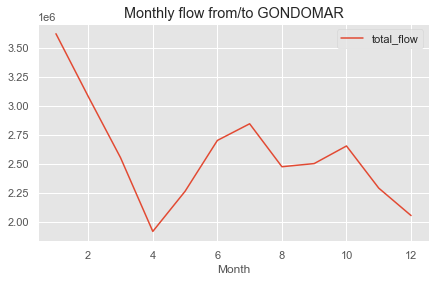

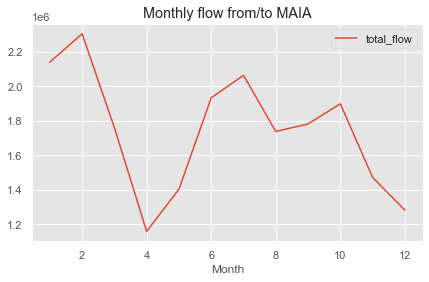

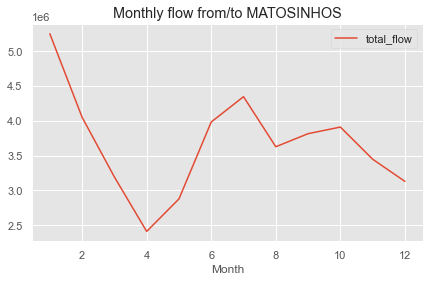

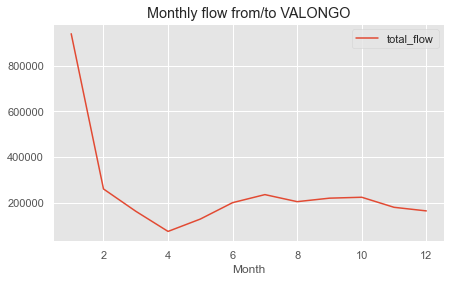

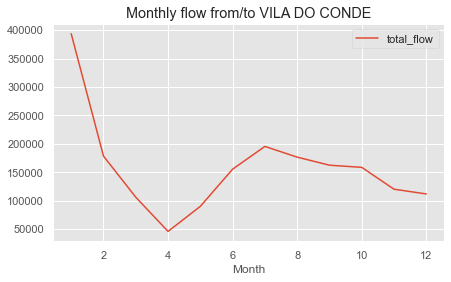

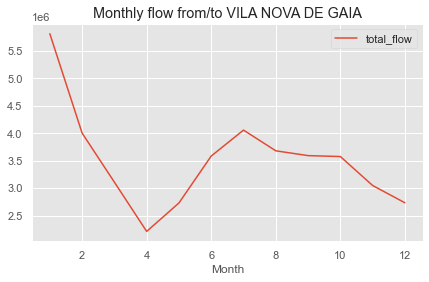

In [283]:
graph1 = nos_mob_porto[nos_mob_porto['B'] == 'PORTO'].groupby(by=['Month', 'A'], as_index=False).agg({'total_flow': sum})

for i in graph1['A'].unique():

    # create the figure
    fig, ax = plt.subplots(figsize=(7, 4))

    # add lines for specific years
    data = graph1[graph1['A'] == i].copy()  # select the data from d, by year
    data.plot(x='Month', y='total_flow', ax=ax, title='Monthly flow from/to '+i)


plt.show()

We can clearly see the impact of covid measures in the month of april, with a return to "normalcy" in the rest of the year.

We can also see that in january there's a much bigger than average flow of people. It's hard to evaluate it without data from the previous year or even month, but one reason that might explain this spike can be people coming back to Porto after the period of Christmas holidays. Note that in december, later in the year, this doesn't occur (the complementary of the spike in january --> people going to their families), but in december there were harder restrictions prohibiting deslocations.

#### Day of Week

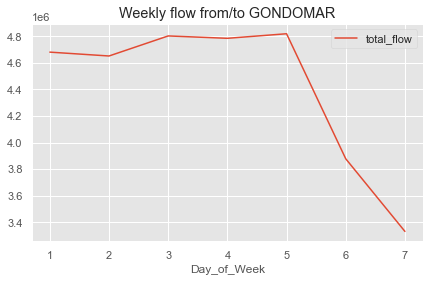

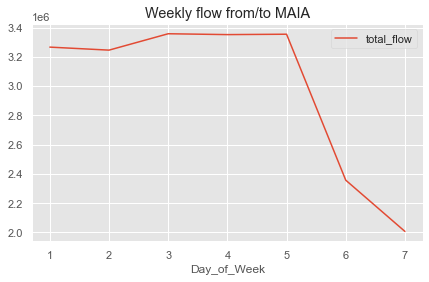

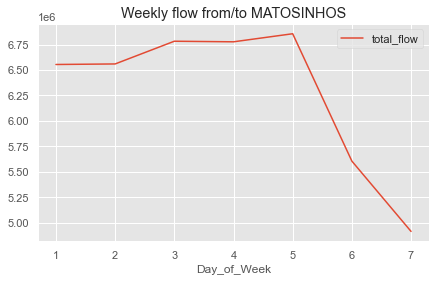

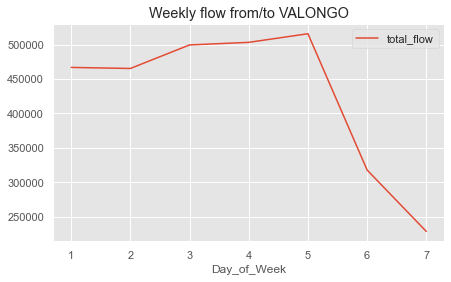

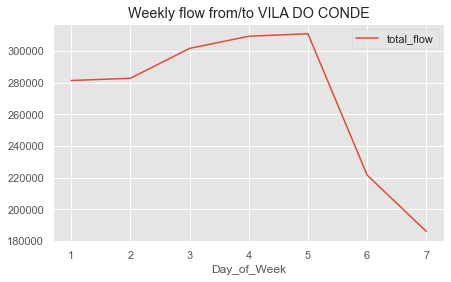

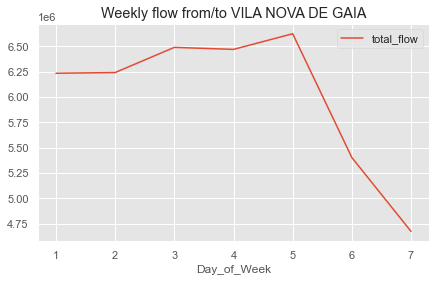

In [284]:
graph2 = nos_mob_porto[nos_mob_porto['B'] == 'PORTO'].groupby(by=['Day_of_Week', 'A'], as_index=False).agg({'total_flow': sum})

for i in graph2['A'].unique():

    # create the figure
    fig, ax = plt.subplots(figsize=(7, 4))

    # add lines for specific years
    data = graph2[graph2['A'] == i].copy()  # select the data from d, by year
    data.plot(x='Day_of_Week', y='total_flow', ax=ax, title='Weekly flow from/to '+i)

plt.show()

Not surprisingly, values during the business week are around the same, with a sharp decrease on weekends, especially on sunday, which gives weight to the hypothesis that most people come from these locations due to work.

#### Season

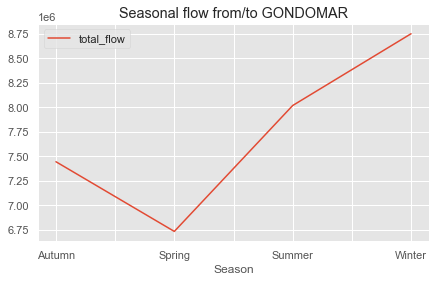

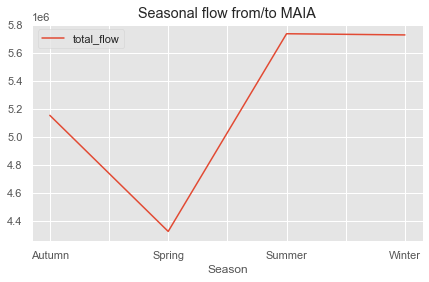

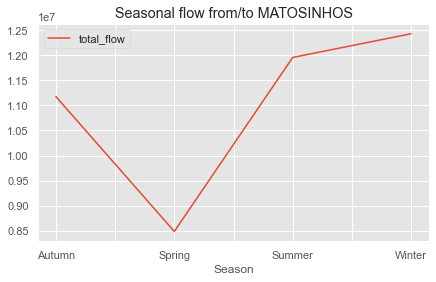

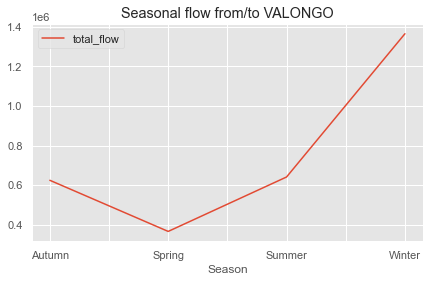

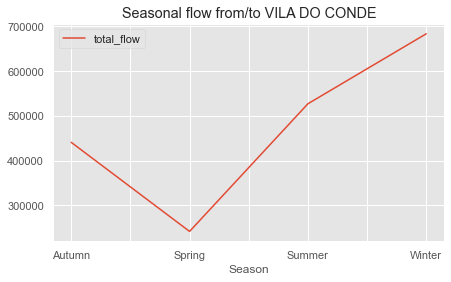

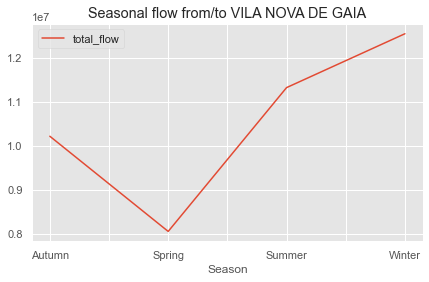

In [285]:
graph3 = nos_mob_porto[nos_mob_porto['B'] == 'PORTO'].groupby(by=['Season', 'A'], as_index=False).agg({'total_flow': sum})

for i in graph3['A'].unique():

    # create the figure
    fig, ax = plt.subplots(figsize=(7, 4))

    # add lines for specific years
    data = graph3[graph3['A'] == i].copy()  # select the data from d, by year
    data.plot(x='Season', y='total_flow', ax=ax, title='Seasonal flow from/to '+i)

plt.show()

The mobility patterns are the same for all municipalities: decrease in Spring and increase in Winter. At first sight, we wouldn't expect much difference between seasons, since, and following the logic that work is the main reason for mobility, there are no exceptional periods where people wouldn't have to go to their jobs. In fact, we could theorize that Summer should see the biggest decrease from the average mobility flow, due to the holidays.

#### Covid Level

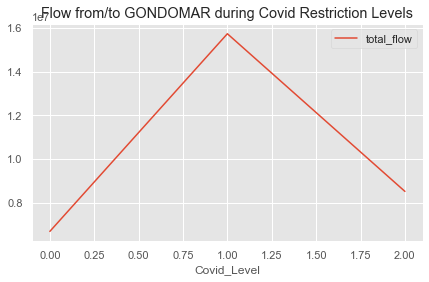

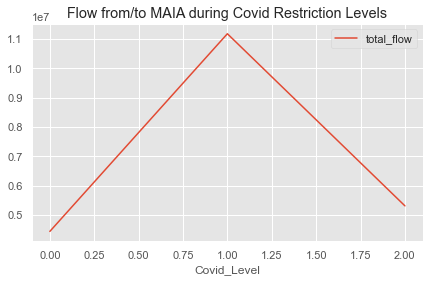

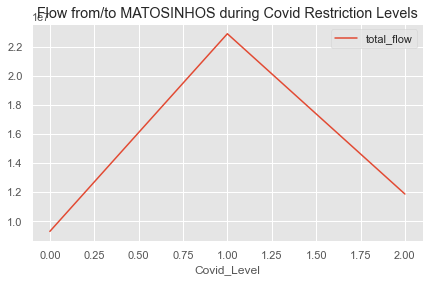

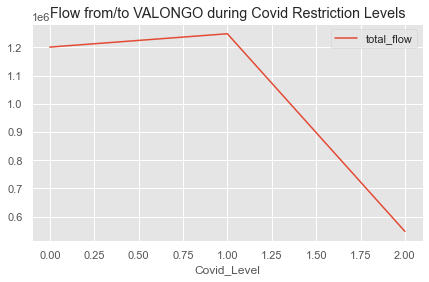

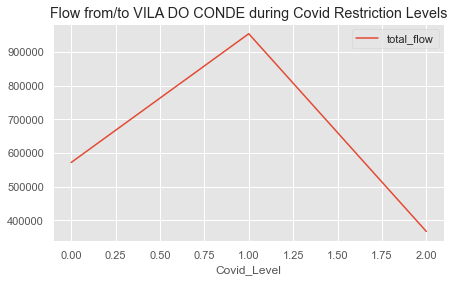

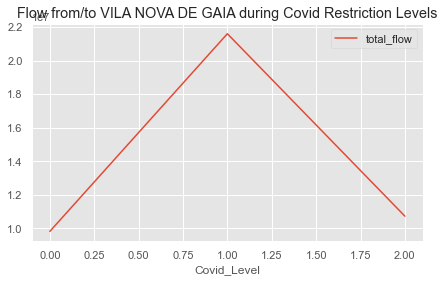

In [286]:
graph4 = nos_mob_porto[nos_mob_porto['B'] == 'PORTO'].groupby(by=['Covid_Level', 'A'], as_index=False).agg({'total_flow': sum})

for i in graph4['A'].unique():

    # create the figure
    fig, ax = plt.subplots(figsize=(7, 4))

    # add lines for specific years
    data = graph4[graph4['A'] == i].copy()  # select the data from d, by year
    data.plot(x='Covid_Level', y='total_flow', ax=ax, title='Flow from/to '+i+' during Covid Restriction Levels')

plt.show()

Almost all (exception of Valongo) visuals show a pyramid trend when we increase the level of restrictions.

Strangely, we see that mobility flow during non-pandemic times is almost the same as when we experienced the most severe restrictions. But since we only have 2 months of data from when Portugal was not affected by the pandemic, this might explain why the value is so low, when compared to the rest of the data.

### Data Pre-processing - Weather data

Usage of public transportation, when people have a choice between it and private transportation can be influenced by the weather, since a car will protect you from the environment from point A to point B, while you will have to walk to the bus/subway station, bring an umbrella if it's raining, then get in the vehicle with countless other people around you.

Not all data was available, so we filled the missing data points with the 'ffill' method. When you look at the weather patterns hourly, we know that there isn't a sudden increase/decrease of temperature values (as well as rain, pressure and other weather factors), and that the weather in the previous hour can be a good predictor of the weather in the next hour. So, the 'ffill' method is a logical method for missing values imputation.

In [287]:
# Set time period
weather = pd.DataFrame()
porto = Point(41.1564381, -8.6298001)

for i in range(2020,2021):
    start = datetime(i, 1, 1)
    end = datetime(i+1, 1, 1)

    # Get hourly data for 2020
    weather_aux = Hourly(porto, start, end)
    weather_aux = weather_aux.fetch()
    weather_aux = weather_aux[['temp', 'wspd', 'prcp']]
    weather = pd.concat([weather, weather_aux], axis=0)

weather.drop_duplicates(subset=weather.columns, keep='first', inplace=True)

print(weather.isna().sum())

weather.fillna(method='ffill', inplace=True)
weather.fillna(value='0', inplace=True)

print(weather.isna().sum())

weather.reset_index(inplace=True)

weather['Day'] = pd.to_datetime(weather['time'].dt.date)
weather['Hour'] = weather['time'].dt.hour

weather.drop(columns = 'time', inplace=True)

nos_mob_porto = pd.merge(nos_mob_porto, weather, how='left', left_on=['Day', 'Hour'], right_on=['Day', 'Hour'])

# check missing values
nos_mob_porto.sort_values(by=['Day', 'Hour'], inplace=True)
print(nos_mob_porto.isna().sum())
nos_mob_porto.fillna(method='ffill', inplace=True)

temp    0
wspd    0
prcp    0
dtype: int64
temp    0
wspd    0
prcp    0
dtype: int64
A                          0
B                          0
Day                        0
Hour                       0
A2B                        0
B2A                        0
Dia                        0
Month                      0
Day_of_Week                0
Week_Number_of_Year        0
Season                     0
Business_Day               0
Covid_Level                0
STCP_Holiday_Period        0
Season_Autumn              0
Season_Spring              0
Season_Summer              0
Season_Winter              0
total_flow                 0
temp                   31935
wspd                   31935
prcp                   31935
dtype: int64


In [288]:
nos_mob_porto_day = nos_mob_porto.groupby(by=['A', 'B', 'Day', 'Dia', 'Month', 'Day_of_Week', 'Week_Number_of_Year', 
                                              'Season', 'Business_Day', 'Covid_Level', 'STCP_Holiday_Period', 'Season_Autumn', 'Season_Spring', 
                                              'Season_Summer', 'Season_Winter'], as_index=False).agg(
    A2B_day = pd.NamedAgg(column='A2B', aggfunc=sum),
    B2A_day = pd.NamedAgg(column='B2A', aggfunc=sum),
    temp_max = pd.NamedAgg(column='temp', aggfunc=max),
    temp_min = pd.NamedAgg(column='temp', aggfunc=min),
    wspd_max = pd.NamedAgg(column='wspd', aggfunc=max),
    wspd_min = pd.NamedAgg(column='wspd', aggfunc=min),
    prcp_max = pd.NamedAgg(column='prcp', aggfunc=max),
    prcp_min = pd.NamedAgg(column='prcp', aggfunc=min))

In [289]:
#nos_mob_porto_day.to_excel(fr'nos_mob_porto_day.xlsx', index=False)

In [290]:
nos_mob_porto_month = nos_mob_porto

In [291]:
def month_weekday_var(row):
    if row['Business_Day'] == 1 and row['STCP_Holiday_Period'] == 1:
        val = 1
    else:
        val = 0
    return val

def month_weekendday_var(row):
    if row['Business_Day'] == 0 and row['STCP_Holiday_Period'] == 1:
        val = 1
    else:
        val = 0
    return val

nos_mob_porto_month['Business_Day_Holiday_Period'] = nos_mob_porto_month.apply(month_weekday_var, axis=1)
nos_mob_porto_month['Weekend_Holiday_Period'] = nos_mob_porto_month.apply(month_weekendday_var, axis=1)

In [292]:
nos_mob_porto_month_aux = nos_mob_porto_month[['A', 'B', 'Day', 'Month', 'Business_Day_Holiday_Period', 'Weekend_Holiday_Period']].drop_duplicates()

In [293]:
nos_mob_porto_month_aux.shape

(4392, 6)

In [294]:
nos_mob_porto_month_aux = nos_mob_porto_month_aux.groupby(by=['A', 'B', 'Month'], as_index=False).agg(
                                              {'Business_Day_Holiday_Period': 'sum',
                                               'Weekend_Holiday_Period': 'sum'
                                              })

In [295]:
nos_mob_porto_month_aux

A      B  Month  Business_Day_Holiday_Period  \
0             GONDOMAR  PORTO      1                            0   
1             GONDOMAR  PORTO      2                            0   
2             GONDOMAR  PORTO      3                            1   
3             GONDOMAR  PORTO      4                           11   
4             GONDOMAR  PORTO      5                            0   
..                 ...    ...    ...                          ...   
139  VILA NOVA DE GAIA  PORTO      8                           25   
140  VILA NOVA DE GAIA  PORTO      9                           11   
141  VILA NOVA DE GAIA  PORTO     10                            0   
142  VILA NOVA DE GAIA  PORTO     11                            0   
143  VILA NOVA DE GAIA  PORTO     12                            0   

     Weekend_Holiday_Period  
0                         0  
1                         0  
2                         0  
3                         2  
4                         0  
..                      ...  
139                       4  
140                       2  
141                       0  
142                       0  
143                       0  

[144 rows x 5 columns]

In [296]:
nos_mob_porto_month = nos_mob_porto_month.groupby(by=['A', 'B', 'Month', 'Season', 'Season_Autumn', 'Season_Spring', 
                                              'Season_Summer', 'Season_Winter', 'Covid_Level'], as_index=False).agg(
                                              {'A2B': 'sum',
                                               'B2A': 'sum'
                                              })

In [297]:
nos_mob_porto_month = pd.merge(nos_mob_porto_month, nos_mob_porto_month_aux, how='left', left_on=['A', 'B','Month'], right_on=['A', 'B','Month'])


In [298]:
#nos_mob_porto_month.to_excel(fr'nos_mob_porto_month.xlsx', index=False)

### Data Pre-processing - TIP MOD Z2Z

Looking at the data for validations, we will maintain the same logic and limit our problem to 'Metro do Porto' and 'STCP', for the zones contained in the main municipalities: Porto, Gondomar, Maia, Matosinhos, Valongo, Vila do Conde and Vila Nova de Gaia.

In [299]:
path_folder = 'data/mod_z2z/'
mod_z2z = pd.DataFrame()

for file in os.listdir(path_folder):
    mod_file = pd.read_excel(path_folder+file)
    mod_z2z = mod_z2z.append(mod_file)

In [300]:
mod_z2z

Ano  Mês  Dia  Hora      Operador ZonaEntrada   ZonaSaida  Validações
0       2020    1    3    19          STCP  VNG1        PRT1               518
1       2020    1   14     9  Gondomarense  GDM6        GDM1                 7
2       2020    1    7    12     Carvalhos  VNG1        VNG6                19
3       2020    1   28    12          STCP  VNG1        VNG2                72
4       2020    1   24    16         VALPI  PRT3        VLG1                24
...      ...  ...  ...   ...           ...         ...         ...         ...
307218  2020   12   31    23          STCP  VNG1        VNG2                 3
307219  2020   12   31    23          STCP  VNG2        VNG1                 1
307220  2020   12   31    23          STCP  VNG5        PRT1                 2
307221  2020   12   31    23         VALPI  PRT1        PRT1                 2
307222  2020   12   31    23         VALPI  PRT1        PRT3                 1

[3377998 rows x 8 columns]

In [301]:
list_municipalities_entrance = ['VNG1      ', 'GDM6      ', 'PRT3      ', 'MTS1      ',
                               'PRT1      ', 'VNG7      ', 'MAI1      ', 'VLG1      ',
                               'VCD8      ', 'VNG6      ', 'VLG3      ', 'PRT2      ', 
                               'GDM3      ', 'MTS3      ', 'PV_VC     ', 'VNG3      ', 
                               'GDM9      ', 'VNG8      ', 'MAI4      ', 'VLG2      ', 
                               'VCD3      ', 'GDM4      ', 'GDM1      ', 'MAI2      ', 
                               'GDM5      ', 'MTS2      ', 'VNG4      ', 'GDM2      ',
                               'MAI3      ', 'VNG10     ', 'VNG9      ', 'MAI5      ', 
                               'VNG5      ', 'VNG2      ', 'VCD7      ', 'VCD11     ', 
                               'VNG11     ', 'VNG12     ', 'VCD12     ', 'GDM7      ', 
                               'VCD5      ', 'VCD10     ', 'VCB2      ', 'GDM8      ',
                               'VCD9      ', 'VCD2      ', 'VCD4      ', 'VCD6      ']

list_municipalities_exit = ['PRT1      ', 'GDM1      ', 'VNG6      ', 'VNG2      ',
                           'VLG1      ', 'PRT2      ', 'VNG4      ', 'MAI1      ',
                           'MAI4      ', 'PRT3      ', 'VNG1      ', 'GDM3      ', 
                           'MTS2      ', 'VCD3      ', 'VNG3      ', 'PV_VC     ',
                           'GDM9      ', 'VLG2      ', 'VNG8      ', 'MAI3      ', 
                           'VLG3      ', 'MAI5      ', 'VCD8      ', 'GDM5      ',
                           'GDM4      ', 'MTS1      ', 'MAI2      ', 'VNG12     ',
                           'GDM2      ', 'VNG5      ', 'MTS3      ', 'GDM6      ',
                           'VNG9      ', 'VNG11     ', 'VNG7      ', 'SMF7      ', 
                           'GDM7      ', 'VNG10     ', 'STR4      ', 'SMF1      ', 
                           'VCD7      ', 'VCD12     ', 'VCD9      ', 'VCD10     ', 
                           'VCD11     ', 'VCD5      ', 'VCD4      ', 'VCD2      ', 
                           'GDM8      ', ]

mod_z2z = mod_z2z[mod_z2z['ZonaEntrada'].isin(list_municipalities_entrance)]
mod_z2z = mod_z2z[mod_z2z['ZonaSaida'].isin(list_municipalities_exit)]
mod_z2z = mod_z2z[mod_z2z.Operador.isin(['STCP', 'Metro do Porto'])]

In [302]:
mod_z2z

Ano  Mês  Dia  Hora        Operador ZonaEntrada   ZonaSaida  \
0       2020    1    3    19            STCP  VNG1        PRT1         
3       2020    1   28    12            STCP  VNG1        VNG2         
8       2020    1   20    12  Metro do Porto  MAI1        GDM1         
9       2020    1   25    12            STCP  PRT3        MAI1         
10      2020    1   14     9            STCP  MAI1        MAI4         
...      ...  ...  ...   ...             ...         ...         ...   
307216  2020   12   31    23            STCP  VNG1        PRT1         
307217  2020   12   31    23            STCP  VNG1        VNG1         
307218  2020   12   31    23            STCP  VNG1        VNG2         
307219  2020   12   31    23            STCP  VNG2        VNG1         
307220  2020   12   31    23            STCP  VNG5        PRT1         

        Validações  
0              518  
3               72  
8                1  
9               35  
10              21  
...            ...  
307216           6  
307217           7  
307218           3  
307219           1  
307220           2  

[1179844 rows x 8 columns]

In [303]:
mod_z2z_day = mod_z2z.groupby(by=['Ano', 'Mês', 'Dia', 'Operador', 'ZonaEntrada', 'ZonaSaida'], as_index=False).agg({'Validações': sum})
#mod_z2z_day.to_excel('mod_z2z_day.xlsx')
mod_z2z_month = mod_z2z.groupby(by=['Ano', 'Mês', 'Operador', 'ZonaEntrada', 'ZonaSaida'], as_index=False).agg({'Validações': sum})
#mod_z2z_month.to_excel('mod_z2z_month.xlsx')

In [304]:
mod_z2z

Ano  Mês  Dia  Hora        Operador ZonaEntrada   ZonaSaida  \
0       2020    1    3    19            STCP  VNG1        PRT1         
3       2020    1   28    12            STCP  VNG1        VNG2         
8       2020    1   20    12  Metro do Porto  MAI1        GDM1         
9       2020    1   25    12            STCP  PRT3        MAI1         
10      2020    1   14     9            STCP  MAI1        MAI4         
...      ...  ...  ...   ...             ...         ...         ...   
307216  2020   12   31    23            STCP  VNG1        PRT1         
307217  2020   12   31    23            STCP  VNG1        VNG1         
307218  2020   12   31    23            STCP  VNG1        VNG2         
307219  2020   12   31    23            STCP  VNG2        VNG1         
307220  2020   12   31    23            STCP  VNG5        PRT1         

        Validações  
0              518  
3               72  
8                1  
9               35  
10              21  
...            ...  
307216           6  
307217           7  
307218           3  
307219           1  
307220           2  

[1179844 rows x 8 columns]

In [305]:
def entrance_zone(row):
    if 'PRT' in row['ZonaEntrada']:
        val = 'PORTO'
    elif 'GDM' in row['ZonaEntrada']:
        val = 'GONDOMAR'
    elif 'VLG' in row['ZonaEntrada']:
        val = 'VALONGO'
    elif 'MAI' in row['ZonaEntrada']:
        val = 'MAIA'
    elif 'VNG' in row['ZonaEntrada']:
        val = 'GAIA'
    elif 'VCD' in row['ZonaEntrada']:
        val = 'VILA DO CONDE'
    elif 'PV_VC' in row['ZonaEntrada']:
        val = 'VILA DO CONDE'
    elif 'MTS' in row['ZonaEntrada']:
        val = 'MATOSINHOS'
    else:
        val = 'OTHER'
    return val

def exit_zone(row):
    if 'PRT' in row['ZonaSaida']:
        val = 'PORTO'
    elif 'GDM' in row['ZonaSaida']:
        val = 'GONDOMAR'
    elif 'VLG' in row['ZonaSaida']:
        val = 'VALONGO'
    elif 'MAI' in row['ZonaSaida']:
        val = 'MAIA'
    elif 'VNG' in row['ZonaSaida']:
        val = 'GAIA'
    elif 'VCD' in row['ZonaSaida']:
        val = 'VILA DO CONDE'
    elif 'PV_VC' in row['ZonaSaida']:
        val = 'VILA DO CONDE'
    elif 'MTS' in row['ZonaSaida']:
        val = 'MATOSINHOS'
    else:
        val = 'OTHER'
    return val

mod_z2z_bycity = mod_z2z

mod_z2z_bycity['EntranceCity'] = mod_z2z_bycity.apply(entrance_zone, axis=1)
mod_z2z_bycity['ExitCity'] = mod_z2z_bycity.apply(exit_zone, axis=1)

mod_z2z_bycity = mod_z2z_bycity[(mod_z2z_bycity['EntranceCity'] != 'OTHER')]
mod_z2z_bycity = mod_z2z_bycity[(mod_z2z_bycity['ExitCity'] != 'OTHER')]

In [306]:
mod_z2z_bycity_day = mod_z2z_bycity.groupby(by=['Ano', 'Mês', 'Dia', 'Operador', 'EntranceCity', 'ExitCity'], as_index=False).agg({'Validações': sum})
#mod_z2z_bycity_day.to_excel('mod_z2z_day_groupbycity.xlsx')
mod_z2z_bycity_month = mod_z2z_bycity.groupby(by=['Ano', 'Mês', 'Operador', 'EntranceCity', 'ExitCity'], as_index=False).agg({'Validações': sum})
#mod_z2z_bycity_month.to_excel('mod_z2z_month_groupbycity.xlsx')

### Combining data - daily

Now we will combine all groups of informations - Mobility and Public Transportation.

Our goal is to allow the detection of sets of routes that are ill-adjusted to the real needs of flows between cities, both on a daily and a monthly base. The public transport coverage will be calculated as a pergentage of capacity/demand.

We'll assume demand equal to the average of flows between AB and BA.

In [307]:
nos_mob_porto_day_demand=nos_mob_porto_day[nos_mob_porto_day["B"]=="PORTO"]
nos_mob_porto_day_demand["demand"]=nos_mob_porto_day_demand["A2B_day"]*0.5+nos_mob_porto_day_demand["B2A_day"]*0.5

nos_mob_porto_day=nos_mob_porto_day_demand.merge(intercity_times,left_on=["A","B","Business_Day","STCP_Holiday_Period"],right_on=["A","B","Business_Day","STCP_Holiday_Period"],how="left")
nos_mob_porto_day["public_transport_coverage"]=100*nos_mob_porto_day["max_capacity"]/nos_mob_porto_day["demand"]
nos_mob_porto_day

A      B        Day  Dia  Month  Day_of_Week  \
0              GONDOMAR  PORTO 2020-01-01    1      1            3   
1              GONDOMAR  PORTO 2020-01-02    2      1            4   
2              GONDOMAR  PORTO 2020-01-03    3      1            5   
3              GONDOMAR  PORTO 2020-01-04    4      1            6   
4              GONDOMAR  PORTO 2020-01-05    5      1            7   
...                 ...    ...        ...  ...    ...          ...   
2191  VILA NOVA DE GAIA  PORTO 2020-12-27   27     12            7   
2192  VILA NOVA DE GAIA  PORTO 2020-12-28   28     12            1   
2193  VILA NOVA DE GAIA  PORTO 2020-12-29   29     12            2   
2194  VILA NOVA DE GAIA  PORTO 2020-12-30   30     12            3   
2195  VILA NOVA DE GAIA  PORTO 2020-12-31   31     12            4   

      Week_Number_of_Year  Season  Business_Day  Covid_Level  \
0                       1  Winter             1            0   
1                       1  Winter             1            0   
2                       1  Winter             1            0   
3                       1  Winter             1            0   
4                       1  Winter             0            0   
...                   ...     ...           ...          ...   
2191                   52  Winter             0            2   
2192                   53  Winter             1            2   
2193                   53  Winter             1            2   
2194                   53  Winter             1            2   
2195                   53  Winter             1            2   

      STCP_Holiday_Period  Season_Autumn  Season_Spring  Season_Summer  \
0                       0              0              0              0   
1                       0              0              0              0   
2                       0              0              0              0   
3                       0              0              0              0   
4                       0              0              0              0   
...                   ...            ...            ...            ...   
2191                    0              0              0              0   
2192                    0              0              0              0   
2193                    0              0              0              0   
2194                    0              0              0              0   
2195                    0              0              0              0   

      Season_Winter  A2B_day  B2A_day  temp_max  temp_min  wspd_max  wspd_min  \
0                 1    35977    43636      11.2       4.7      11.1       3.7   
1                 1    55302    59545      10.3       4.6      13.0       5.5   
2                 1    58908    62510      11.7       8.2      11.1       3.7   
3                 1    51052    53779      13.4       8.3       7.4       3.7   
4                 1    42703    46284      11.9       4.9       7.4       3.7   
...             ...      ...      ...       ...       ...       ...       ...   
2191              1    26019    25695      10.6       2.9      22.2       3.7   
2192              1    45796    45277      10.0       7.4      25.9       9.3   
2193              1    46372    45500       8.9       6.5      13.0       7.4   
2194              1    46801    46940       6.9       4.1       5.5       3.7   
2195              1    38681    38443       9.6       6.8      14.8       5.5   

      prcp_max  prcp_min   demand  number_of_stops  mean_duration  \
0          0.0       0.0  39806.5        35.571429      34.714178   
1          0.0       0.0  57423.5        35.571429      34.714178   
2          0.0       0.0  60709.0        35.571429      34.714178   
3          0.0       0.0  52415.5        35.571429      34.714178   
4          0.0       0.0  44493.5        33.285714      32.311012   
...        ...       ...      ...              ...            ...   
2191       2.8       0.0  25857.0        33.727273      31.927805  

In [308]:
z2z_day = mod_z2z_bycity_day.rename(columns={"EntranceCity":"A","ExitCity":"B","Validações":"trips","Ano":"Year","Mês":"Month","Operador":"provider"})
z2z_day.loc[z2z_day["provider"]=="Metro do Porto","provider"]="METRO"
z2z_day.loc[z2z_day["A"]=="GAIA","A"]="VILA NOVA DE GAIA"
z2z_day = z2z_day[z2z_day["B"]=="PORTO"]
z2z_day = z2z_day[z2z_day["A"]!="PORTO"]
z2z_day = z2z_day.groupby(["Month","Dia","A","B"]).sum()[["trips"]].reset_index()
nos_z2z_day = z2z_day.merge(nos_mob_porto_day,left_on=["A","B","Dia","Month"],right_on=["A","B","Dia","Month"],how="outer")

nos_z2z_day["trips"] = nos_z2z_day["trips"].fillna(0)
nos_z2z_day["public_transport_usage"] = 100*nos_z2z_day["trips"]/nos_z2z_day["demand"]
nos_z2z_day["public_transport_capacity_usage"] = 100*nos_z2z_day["trips"]/nos_z2z_day["max_capacity"]
nos_z2z_day = nos_z2z_day[["Day","A","B","Business_Day","STCP_Holiday_Period","demand","trips","max_capacity","public_transport_coverage","public_transport_usage","public_transport_capacity_usage"]].sort_values("Day")
nos_z2z_day

Day                  A      B  Business_Day  STCP_Holiday_Period  \
0    2020-01-01           GONDOMAR  PORTO             1                    0   
1    2020-01-01               MAIA  PORTO             1                    0   
2    2020-01-01         MATOSINHOS  PORTO             1                    0   
3    2020-01-01            VALONGO  PORTO             1                    0   
4    2020-01-01      VILA DO CONDE  PORTO             1                    0   
...         ...                ...    ...           ...                  ...   
1915 2020-12-31               MAIA  PORTO             1                    0   
1916 2020-12-31         MATOSINHOS  PORTO             1                    0   
1917 2020-12-31            VALONGO  PORTO             1                    0   
1918 2020-12-31      VILA DO CONDE  PORTO             1                    0   
1919 2020-12-31  VILA NOVA DE GAIA  PORTO             1                    0   

       demand   trips  max_capacity  public_transport_coverage  \
0     39806.5  2833.0  33755.166667                  84.798128   
1     21995.5  7306.0  39107.500000                 177.797731   
2     51365.5  5220.0  47464.333333                  92.405084   
3      9230.0   323.0  15120.000000                 163.813651   
4      4180.0  4303.0  41289.000000                 987.775120   
...       ...     ...           ...                        ...   
1915  16126.5  7390.0  39107.500000                 242.504573   
1916  43036.5  3236.0  47464.333333                 110.288554   
1917   2156.5   202.0  15120.000000                 701.136100   
1918   1136.0  1952.0  41289.000000                3634.595070   
1919  38562.0  9942.0  50429.000000                 130.773819   

      public_transport_usage  public_transport_capacity_usage  
0                   7.116928                         8.392789  
1                  33.215885                        18.681839  
2                  10.162463                        10.997732  
3                   3.499458                         2.136243  
4                 102.942584                        10.421662  
...                      ...                              ...  
1915               45.825195                        18.896631  
1916                7.519199                         6.817751  
1917                9.367030                         1.335979  
1918              171.830986                         4.727651  
1919               25.781858                        19.714847  

[2196 rows x 11 columns]

Here we can check the top 5 worst set of routes in coverage % - city + day, with Vila Nova de Gaia and Matosinhos the worst cities.

In [309]:
def get_routes_in_city(A,B):
    aux=route_city_times[(route_city_times["A"]==A)&(route_city_times["B"]==B)]["route_id"].values
    return aux

for i,line in nos_z2z_day.sort_values("public_transport_coverage").head(5).iterrows():
    A=line["A"]
    B=line["B"]
    routes=get_routes_in_city(A,B)
    print(A+" <> "+B+" - Day: "+str(line["Day"])+"; Coverage: "+str(int(line["public_transport_coverage"]))+"%")
    print (routes)

VILA NOVA DE GAIA <> PORTO - Day: 2020-01-10 00:00:00; Coverage: 46%
['10M' '10M' '10M' '10M' '11M' '11M' '11M' '11M' '12M' '12M' '12M' '12M'
 '900' '900' '900' '900' '901' '901' '901' '901' '902' '902' '903' '903'
 '903' '904' '904' '904' '904' '905' '905' '905' '905' '906' '906' '906'
 '906' '907' '907' '907' '907' 'D']
VILA NOVA DE GAIA <> PORTO - Day: 2020-01-17 00:00:00; Coverage: 46%
['10M' '10M' '10M' '10M' '11M' '11M' '11M' '11M' '12M' '12M' '12M' '12M'
 '900' '900' '900' '900' '901' '901' '901' '901' '902' '902' '903' '903'
 '903' '904' '904' '904' '904' '905' '905' '905' '905' '906' '906' '906'
 '906' '907' '907' '907' '907' 'D']
VILA NOVA DE GAIA <> PORTO - Day: 2020-01-07 00:00:00; Coverage: 47%
['10M' '10M' '10M' '10M' '11M' '11M' '11M' '11M' '12M' '12M' '12M' '12M'
 '900' '900' '900' '900' '901' '901' '901' '901' '902' '902' '903' '903'
 '903' '904' '904' '904' '904' '905' '905' '905' '905' '906' '906' '906'
 '906' '907' '907' '907' '907' 'D']
VILA NOVA DE GAIA <> PORTO -

Next, we will conduct a visual analysis of distribution of coverage on daily city data.

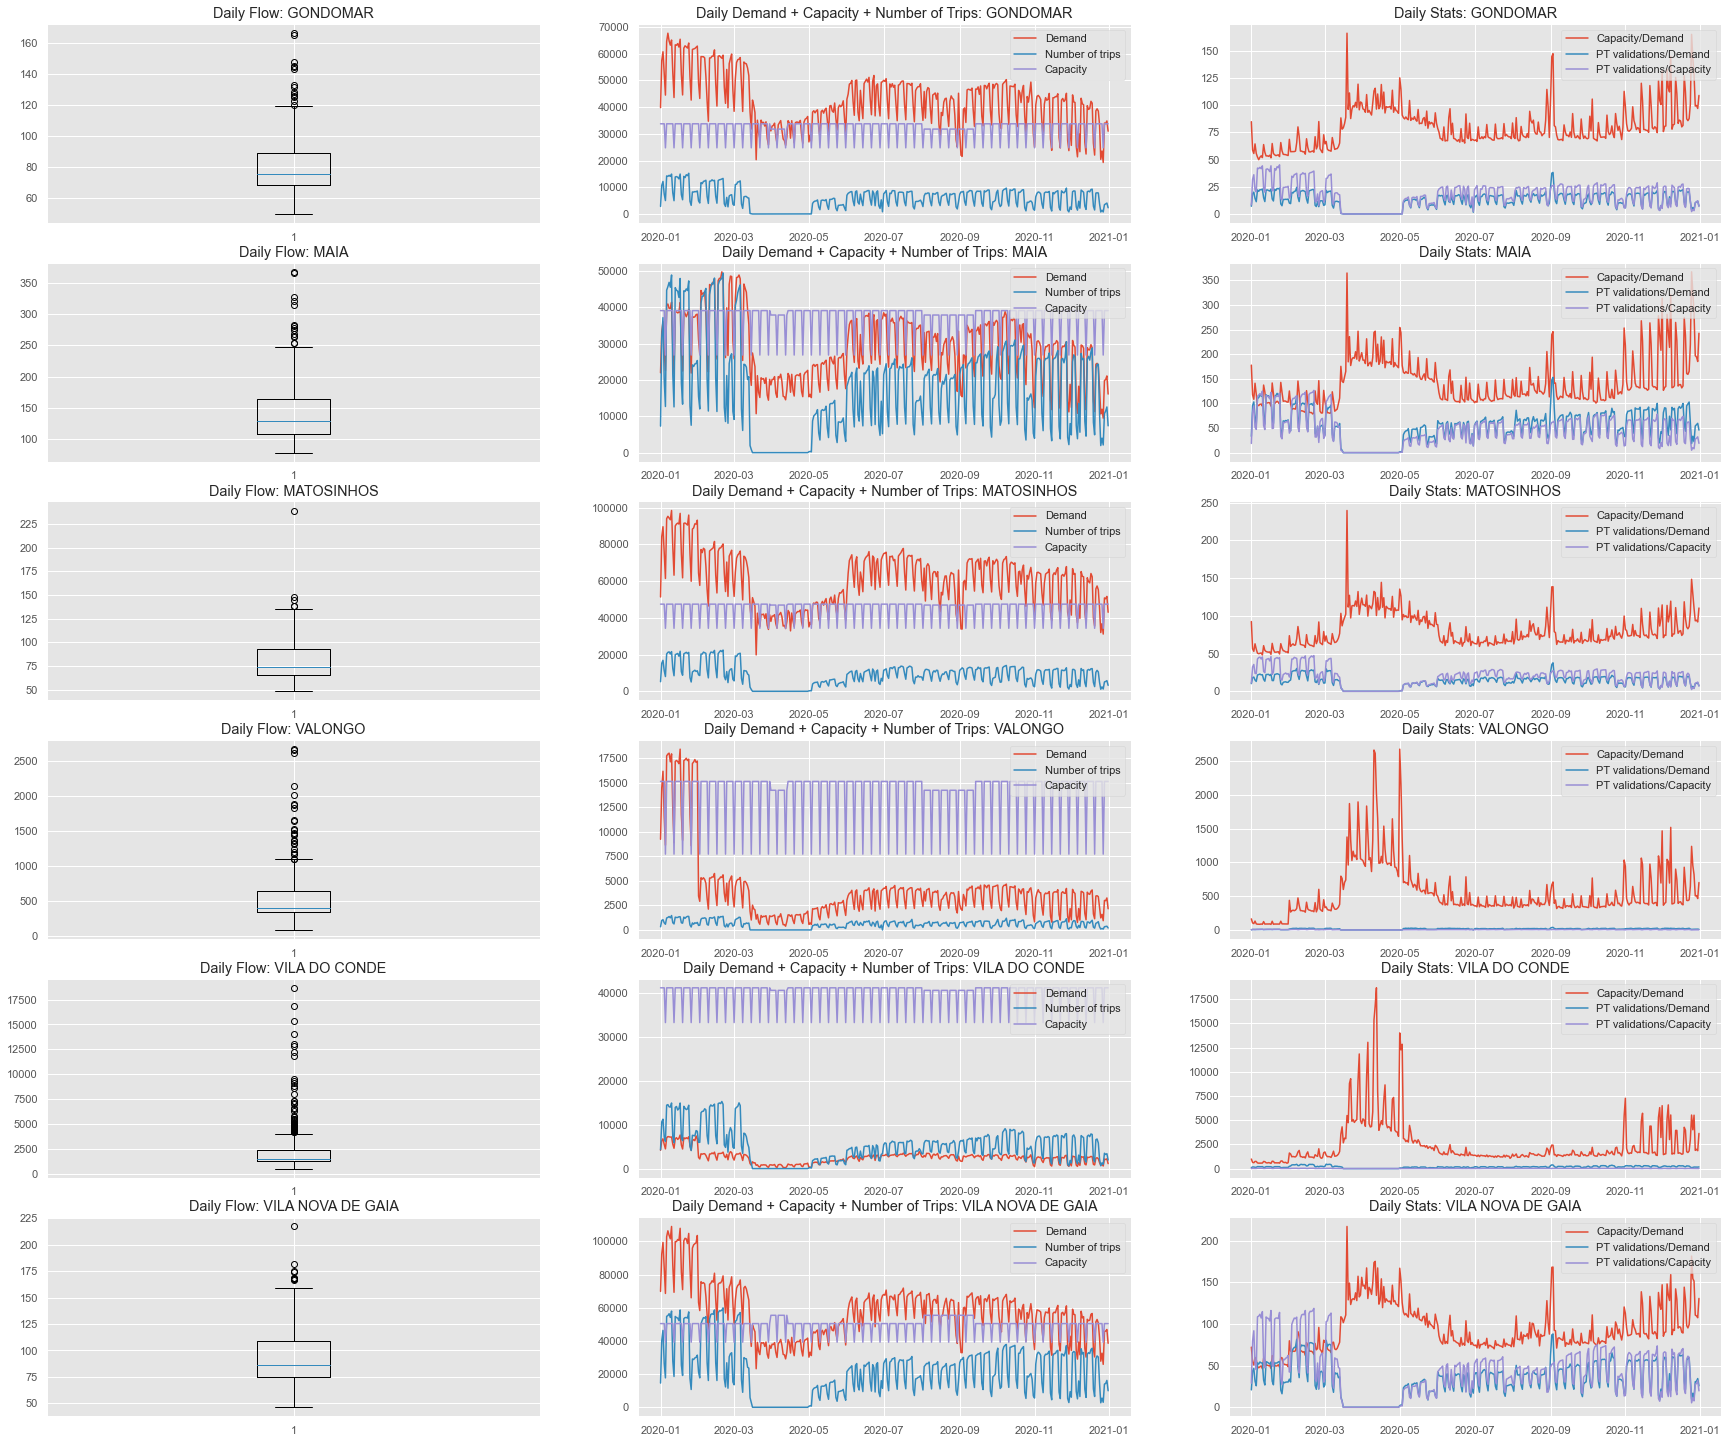

In [310]:
fig=plt.figure(figsize=(30,30))
columns = 3
rows = 7
j=1
for i in range(0,6):
    flow=list(nos_z2z_day["A"].unique())[i]
    fig.add_subplot(rows, columns, j)
    plt.boxplot(list(nos_z2z_day[nos_z2z_day["A"]==flow]["public_transport_coverage"]))
    plt.title( "Daily Flow: "+flow )

    j+=1
    fig.add_subplot(rows, columns, j)
    plt.plot(nos_z2z_day[nos_z2z_day["A"]==flow]["Day"],nos_z2z_day[nos_z2z_day["A"]==flow]["demand"],label='Demand')
    plt.plot(nos_z2z_day[nos_z2z_day["A"]==flow]["Day"],nos_z2z_day[nos_z2z_day["A"]==flow]["trips"],label='Number of trips')
    plt.plot(nos_z2z_day[nos_z2z_day["A"]==flow]["Day"],nos_z2z_day[nos_z2z_day["A"]==flow]["max_capacity"],label='Capacity')
    plt.legend( loc="upper right")
    plt.title( "Daily Demand + Capacity + Number of Trips: "+flow )
    j+=1

    fig.add_subplot(rows, columns, j)
    plt.plot(nos_z2z_day[nos_z2z_day["A"]==flow]["Day"],nos_z2z_day[nos_z2z_day["A"]==flow]["public_transport_coverage"],label='Capacity/Demand')
    plt.plot(nos_z2z_day[nos_z2z_day["A"]==flow]["Day"],nos_z2z_day[nos_z2z_day["A"]==flow]["public_transport_usage"],label='PT validations/Demand')
    plt.plot(nos_z2z_day[nos_z2z_day["A"]==flow]["Day"],nos_z2z_day[nos_z2z_day["A"]==flow]["public_transport_capacity_usage"],label='PT validations/Capacity')
    plt.legend( loc="upper right")
    plt.title( "Daily Stats: "+flow )
    j+=1


plt.show()

Looking at the boxplots (1st column of graphs), we see that the municipalities closer to Porto are much better served when you look at the ratio of capacity and demand: Vila Nova de Gaia, Gondomar, Maia and Matosinhos.

As people who have lived our whole lives here, we know that these areas are as much a part of Porto as Porto itself, so it makes sense that the adjustments made for the needs of the people are much more adequate.

When we look at Valongo and Vila do Conde, these areas, although close to Porto, are farther away then the others. One could suppose that, for that same reason, there will be a lower number of people who come to Porto, although the lines of public transportation are equipped to serve more people - probably because these lines are continuations of other lines (Vila do Conde is to the north of Matosinhos/Maia and Valongo is to the east of Gondomar).

When we look at the actual validations (3rd column of graphs), these are much more aligned with the capacity to accomodate the people. While the daily flow, takes into account, the tracking data from NOS, for all people coming to Porto, the data from TIP shows a smaller discrepancy between capacity and demand.

### Combining data - monthly

To obtain the real capacity of the network, we take in consideration the number of business days and STCP holiday periods.

In [311]:
nos_mob_porto_month_demand = nos_mob_porto_month
import calendar
def get_capacity(r):
    cap=intercity_times[(intercity_times["A"]==r["A"])&(intercity_times["B"]==r["B"])]

    cal=calendar.Calendar()
    working_days = len([x for x in cal.itermonthdays2(2020, r["Month"]) if x[0] !=0 and x[1] < 5])
    weekend_days = len([x for x in cal.itermonthdays2(2020, r["Month"]) if x[0] !=0 and x[1] >= 5])

    max_capacity=0
    #holidays in business days
    max_capacity = max_capacity+r["Business_Day_Holiday_Period"]*cap[(cap["Business_Day"]==1)&(cap["STCP_Holiday_Period"]==1)]["max_capacity"].values[0]
    #holidays in weekend
    max_capacity = max_capacity+r["Weekend_Holiday_Period"]*cap[(cap["Business_Day"]==0)&(cap["STCP_Holiday_Period"]==1)]["max_capacity"].values[0]
    #business days in month - holidays
    max_capacity = max_capacity+(working_days-r["Business_Day_Holiday_Period"])*cap[(cap["Business_Day"]==1)&(cap["STCP_Holiday_Period"]==0)]["max_capacity"].values[0]
    #weekend days in month - holidays
    max_capacity = max_capacity+(weekend_days-r["Weekend_Holiday_Period"])*cap[(cap["Business_Day"]==0)&(cap["STCP_Holiday_Period"]==0)]["max_capacity"].values[0]
    return max_capacity

nos_mob_porto_month_demand = nos_mob_porto_month_demand[nos_mob_porto_month_demand["B"]=="PORTO"]
nos_mob_porto_month_demand["demand"] = nos_mob_porto_month_demand["A2B"]*0.5+nos_mob_porto_month_demand["B2A"]*0.5

nos_mob_porto_month_demand["max_capacity"] = nos_mob_porto_month_demand.apply(lambda r: get_capacity(r),axis=1)
nos_mob_porto_month_demand["public_transport_coverage"] = 100*nos_mob_porto_month_demand["max_capacity"]/nos_mob_porto_month_demand["demand"]

nos_mob_porto_month_demand.sort_values("public_transport_coverage").reset_index(drop=True)

A      B  Month  Season  Season_Autumn  Season_Spring  \
0   VILA NOVA DE GAIA  PORTO      1  Winter              0              0   
1          MATOSINHOS  PORTO      1  Winter              0              0   
2            GONDOMAR  PORTO      1  Winter              0              0   
3            GONDOMAR  PORTO      2  Winter              0              0   
4          MATOSINHOS  PORTO      2  Winter              0              0   
5          MATOSINHOS  PORTO      7  Summer              0              0   
6          MATOSINHOS  PORTO      6  Summer              0              0   
7   VILA NOVA DE GAIA  PORTO      2  Winter              0              0   
8            GONDOMAR  PORTO      7  Summer              0              0   
9          MATOSINHOS  PORTO      9  Autumn              1              0   
10         MATOSINHOS  PORTO     10  Autumn              1              0   
11           GONDOMAR  PORTO      6  Summer              0              0   
12  VILA NOVA DE GAIA  PORTO      7  Summer              0              0   
13           GONDOMAR  PORTO     10  Autumn              1              0   
14         MATOSINHOS  PORTO      8  Summer              0              0   
15           GONDOMAR  PORTO      8  Summer              0              0   
16           GONDOMAR  PORTO      9  Autumn              1              0   
17           GONDOMAR  PORTO      3  Spring              0              1   
18         MATOSINHOS  PORTO     11  Autumn              1              0   
19  VILA NOVA DE GAIA  PORTO      6  Summer              0              0   
20           GONDOMAR  PORTO     11  Autumn              1              0   
21  VILA NOVA DE GAIA  PORTO     10  Autumn              1              0   
22  VILA NOVA DE GAIA  PORTO      9  Autumn              1              0   
23           GONDOMAR  PORTO      5  Spring              0              1   
24         MATOSINHOS  PORTO      3  Spring              0              1   
25  VILA NOVA DE GAIA  PORTO      8  Summer              0              0   
26            VALONGO  PORTO      1  Winter              0              0   
27         MATOSINHOS  PORTO     12  Winter              0              0   
28               MAIA  PORTO      2  Winter              0              0   
29  VILA NOVA DE GAIA  PORTO     11  Autumn              1              0   
30         MATOSINHOS  PORTO      5  Spring              0              1   
31  VILA NOVA DE GAIA  PORTO      3  Spring              0              1   
32           GONDOMAR  PORTO     12  Winter              0              0   
33           GONDOMAR  PORTO      4  Spring              0              1   
34               MAIA  PORTO      1  Winter              0              0   
35  VILA NOVA DE GAIA  PORTO      5  Spring              0              1   
36  VILA NOVA DE GAIA  PORTO     12  Winter              0              0   
37               MAIA  PORTO      7  Summer              0              0   
38         MATOSINHOS  PORTO      4  Spring              0              1   
39               MAIA  PORTO      6  Summer              0              0   
40               MAIA  PORTO     10  Autumn              1              0   
41               MAIA  PORTO      9  Autumn              1              0   
42               MAIA  PORTO      8  Summer              0              0   
43               MAIA  PORTO      3  Spring              0              1   
44  VILA NOVA DE GAIA  PORTO      4  Spring              0              1   
45               MAIA  PORTO     11  Autumn              1              0   
46               MAIA  PORTO      5  Spring              0              1   
47               MAIA  PORTO     12  Winter              0              0   
48               MAIA  PORTO      4  Spring              0              1   
49            VALONGO  PORTO      2  Winter              0              0   
50            VALONGO  PORTO      7  Summer              0              0   
51            VA

In [312]:
z2z_month = mod_z2z_bycity_month.rename(columns={"EntranceCity":"A","ExitCity":"B","Validações":"trips","Ano":"Year","Mês":"Month","Operador":"provider"})
z2z_month.loc[z2z_month["provider"]=="Metro do Porto","provider"]="METRO"
z2z_month.loc[z2z_month["A"]=="GAIA","A"]="VILA NOVA DE GAIA"
z2z_month = z2z_month[z2z_month["B"]=="PORTO"]
z2z_month = z2z_month[z2z_month["A"]!="PORTO"]

z2z_month = z2z_month.groupby(["Month","A","B"]).sum()[["trips"]].reset_index()
nos_z2z_month = z2z_month.merge(nos_mob_porto_month_demand,left_on=["A","B","Month"],right_on=["A","B","Month"],how="right")

nos_z2z_month["trips"] = nos_z2z_month["trips"].fillna(0)
nos_z2z_month["public_transport_usage"] = 100*nos_z2z_month["trips"]/nos_z2z_month["demand"]
nos_z2z_month["public_transport_capacity_usage"] = 100*nos_z2z_month["trips"]/nos_z2z_month["max_capacity"]
nos_z2z_month = nos_z2z_month[["Month","A","B","demand","trips","max_capacity","public_transport_coverage","public_transport_usage","public_transport_capacity_usage"]].sort_values("Month")
nos_z2z_month

Month                  A      B     demand      trips  max_capacity  \
0       1           GONDOMAR  PORTO  1809416.0   326900.0  9.744102e+05   
36      1            VALONGO  PORTO   470207.0    30354.0  4.095000e+05   
12      1               MAIA  PORTO  1070319.5  1001400.0  1.114412e+06   
24      1         MATOSINHOS  PORTO  2625523.5   475429.0  1.366094e+06   
60      1  VILA NOVA DE GAIA  PORTO  2906268.5  1238077.0  1.473479e+06   
48      1      VILA DO CONDE  PORTO   196837.5   327374.0  1.216419e+06   
61      2  VILA NOVA DE GAIA  PORTO  2001352.5  1140026.0  1.361394e+06   
49      2      VILA DO CONDE  PORTO    89182.0   303848.0  1.125898e+06   
37      2            VALONGO  PORTO   130248.5    26024.0  3.718575e+05   
13      2               MAIA  PORTO  1152737.5   916594.0  1.023958e+06   
1       2           GONDOMAR  PORTO  1539528.5   257684.0  8.978998e+05   
25      2         MATOSINHOS  PORTO  2025435.5   445426.0  1.258003e+06   
62      3  VILA NOVA DE GAIA  PORTO  1554417.0   456346.0  1.467246e+06   
38      3            VALONGO  PORTO    81403.5    10358.0  4.011975e+05   
2       3           GONDOMAR  PORTO  1276270.0    99598.0  9.634302e+05   
14      3               MAIA  PORTO   880464.0   361205.0  1.100958e+06   
50      3      VILA DO CONDE  PORTO    53004.5   121721.0  1.207892e+06   
26      3         MATOSINHOS  PORTO  1597017.0   171238.0  1.352437e+06   
27      4         MATOSINHOS  PORTO  1205975.0        2.0  1.313185e+06   
39      4            VALONGO  PORTO    37244.5        1.0  3.844800e+05   
15      4               MAIA  PORTO   579414.0        0.0  1.061940e+06   
51      4      VILA DO CONDE  PORTO    22884.5        0.0  1.168695e+06   
63      4  VILA NOVA DE GAIA  PORTO  1105907.0        1.0  1.477995e+06   
3       4           GONDOMAR  PORTO   958898.0        0.0  9.188750e+05   
40      5            VALONGO  PORTO    64310.5    11429.0  3.946950e+05   
16      5               MAIA  PORTO   701885.5   260264.0  1.089932e+06   
52      5      VILA DO CONDE  PORTO    44943.5    54745.0  1.200534e+06   
4       5           GONDOMAR  PORTO  1131578.5   110436.0  9.564102e+05   
28      5         MATOSINHOS  PORTO  1439310.0   129180.0  1.339769e+06   
64      5  VILA NOVA DE GAIA  PORTO  1365124.5   295308.0  1.451024e+06   
53      6      VILA DO CONDE  PORTO    77636.5   115478.0  1.175130e+06   
41      6            VALONGO  PORTO   100251.5    19205.0  3.943800e+05   
65      6  VILA NOVA DE GAIA  PORTO  1792587.5   570131.0  1.423050e+06   
5       6           GONDOMAR  PORTO  1350346.0   186634.0  9.406550e+05   
29      6         MATOSINHOS  PORTO  1991788.5   261694.0  1.318630e+06   
17      6               MAIA  PORTO   966893.5   483959.0  1.075305e+06   
18      7               MAIA  PORTO  1032211.5   572506.0  1.114412e+06   
6       7           GONDOMAR  PORTO  1422036.5   199480.0  9.744102e+05   
30      7         MATOSINHOS  PORTO  2173493.0   330719.0  1.366094e+06   
66      7  VILA NOVA DE GAIA  PORTO  2028681.0   700392.0  1.473479e+06   
54      7      VILA DO CONDE  PORTO    97689.0   153328.0  1.216419e+06   
42      7            VALONGO  PORTO   117854.0    20274.0  4.095000e+05   
67      8  VILA NOVA DE GAIA  PORTO  1840046.0   649508.0  1.575899e+06   
55      8      VILA DO CONDE  PORTO    88245.5   158018.0  1.185909e+06   
31      8         MATOSINHOS  PORTO  1814045.5   286977.0  1.327394e+06   
19      8               MAIA  PORTO   869193.0   521336.0  1.059558e+06   
7       8           GONDOMAR  PORTO  1237187.0   188996.0  9.069102e+05   
43      8            VALONGO  PORTO   102438.5    18540.0  3.721950e+05   
8       9           GONDOMAR  PORTO  1250869.5   201320.0  9.188750e+05   
56      9      VILA DO CONDE  PORTO    81162.5   170484.0  1.168695e+06   
32      9         MATOSINHOS  PORTO  1907825.5   309201.0  1.313185e+06   
44      9            VALONGO  PORTO   110070.5    20177.0  3.844800e+05   
20      9               MAIA 

Again, we can check the top 5 worst set of routes in coverage % - city + month.

In [313]:
for i,line in nos_z2z_month.sort_values("public_transport_coverage").head(5).iterrows():
    A=line["A"]
    B=line["B"]
    routes=get_routes_in_city(A,B)
    print(A+" <> "+B+" - Month: "+str(line["Month"])+"; Coverage: "+str(int(line["public_transport_coverage"]))+"%")
    print (routes)

VILA NOVA DE GAIA <> PORTO - Month: 1; Coverage: 50%
['10M' '10M' '10M' '10M' '11M' '11M' '11M' '11M' '12M' '12M' '12M' '12M'
 '900' '900' '900' '900' '901' '901' '901' '901' '902' '902' '903' '903'
 '903' '904' '904' '904' '904' '905' '905' '905' '905' '906' '906' '906'
 '906' '907' '907' '907' '907' 'D']
MATOSINHOS <> PORTO - Month: 1; Coverage: 52%
['13M' '13M' '13M' '13M' '1M' '1M' '1M' '1M' '500' '500' '500' '500' '501'
 '501' '501' '501' '502' '502' '502' '502' '503' '503' '503' '503' '505'
 '505' '505' '505' '506' '506' '506' '506' '507' '507' '507' '507' '508'
 '508' '508' '508' 'A']
GONDOMAR <> PORTO - Month: 1; Coverage: 53%
['800' '800' '800' '800' '801' '801' '801' '801' '804' '804' '804' '804'
 '806' '806' '806' '806' '8M' '8M' '8M' '8M' '9M' '9M' '9M' '9M' 'F']
GONDOMAR <> PORTO - Month: 2; Coverage: 58%
['800' '800' '800' '800' '801' '801' '801' '801' '804' '804' '804' '804'
 '806' '806' '806' '806' '8M' '8M' '8M' '8M' '9M' '9M' '9M' '9M' 'F']
MATOSINHOS <> PORTO - Month

And the visual analysis of distribution of coverage on monthly city data.

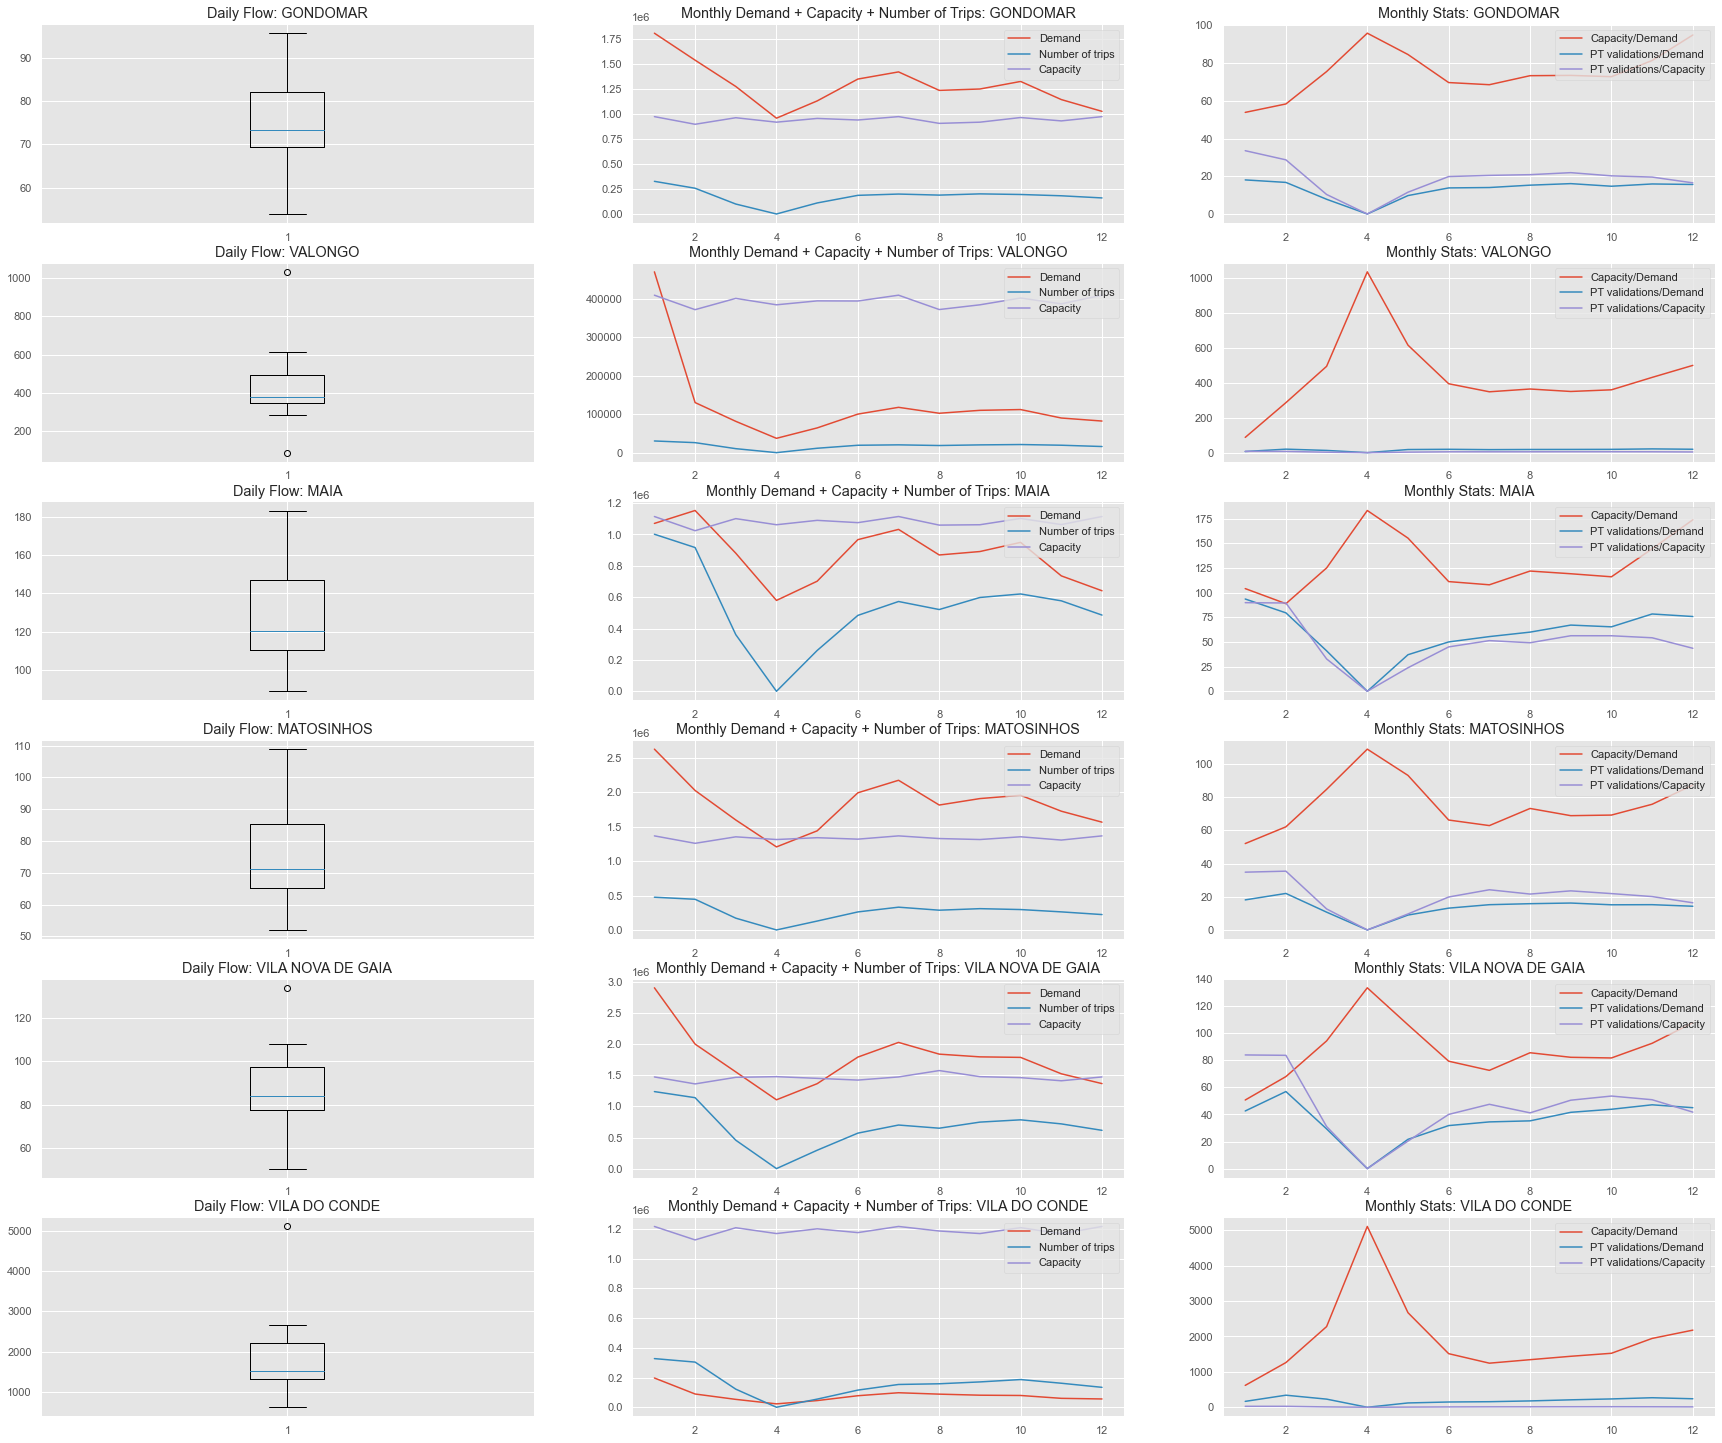

In [314]:
fig=plt.figure(figsize=(30,30))
columns = 3
rows = 7
j=1
for i in range(0,6):
    flow=list(nos_z2z_month["A"].unique())[i]
    fig.add_subplot(rows, columns, j)
    plt.boxplot(list(nos_z2z_month[nos_z2z_month["A"]==flow]["public_transport_coverage"]))
    plt.title( "Daily Flow: "+flow )

    j+=1
    fig.add_subplot(rows, columns, j)
    plt.plot(nos_z2z_month[nos_z2z_month["A"]==flow]["Month"],nos_z2z_month[nos_z2z_month["A"]==flow]["demand"],label='Demand')
    plt.plot(nos_z2z_month[nos_z2z_month["A"]==flow]["Month"],nos_z2z_month[nos_z2z_month["A"]==flow]["trips"],label='Number of trips')
    plt.plot(nos_z2z_month[nos_z2z_month["A"]==flow]["Month"],nos_z2z_month[nos_z2z_month["A"]==flow]["max_capacity"],label='Capacity')
    plt.legend( loc="upper right")
    plt.title( "Monthly Demand + Capacity + Number of Trips: "+flow )
    j+=1

    fig.add_subplot(rows, columns, j)
    plt.plot(nos_z2z_month[nos_z2z_month["A"]==flow]["Month"],nos_z2z_month[nos_z2z_month["A"]==flow]["public_transport_coverage"],label='Capacity/Demand')
    plt.plot(nos_z2z_month[nos_z2z_month["A"]==flow]["Month"],nos_z2z_month[nos_z2z_month["A"]==flow]["public_transport_usage"],label='PT validations/Demand')
    plt.plot(nos_z2z_month[nos_z2z_month["A"]==flow]["Month"],nos_z2z_month[nos_z2z_month["A"]==flow]["public_transport_capacity_usage"],label='PT validations/Capacity')
    plt.legend( loc="upper right")
    plt.title( "Monthly Stats: "+flow )
    j+=1

plt.show()

The monthly data behaves the same as the daily data, which makes sense, since it is an aggregate of the granular data.

For purposes of the model, we will also calculate the yearly mean mobility data.

In [315]:
nos_year=nos_z2z_day.groupby(["A","B"]).mean().reset_index()
nos_year

A      B  Business_Day  STCP_Holiday_Period        demand  \
0           GONDOMAR  PORTO      0.857923             0.153005  42281.288251   
1               MAIA  PORTO      0.857923             0.153005  28608.823770   
2         MATOSINHOS  PORTO      0.857923             0.153005  60179.091530   
3            VALONGO  PORTO      0.857923             0.153005   4093.883880   
4      VILA DO CONDE  PORTO      0.857923             0.153005   2586.665301   
5  VILA NOVA DE GAIA  PORTO      0.857923             0.153005  57565.830601   

          trips  max_capacity  public_transport_coverage  \
0   5762.868852  32216.806011                  80.157417   
1  17483.090164  37209.139344                 143.231757   
2   8721.844262  45529.333333                  80.336850   
3    581.120219  13950.245902                 539.949229   
4   5156.273224  40083.836066                2437.574199   
5  21627.095628  49488.918033                  93.324088   

   public_transport_usage  public_transport_capacity_usage  
0               12.550590                        17.536094  
1               54.553047                        45.816957  
2               13.149847                        18.865763  
3               14.918402                         4.104763  
4              177.672881                        12.712912  
5               33.874295                        43.113486

### Data Visualization

Flow by Origin and Month: Highest commuting to Porto was observed from the most limit counties: Gaia, Matosinhos and Gondomar, for all months

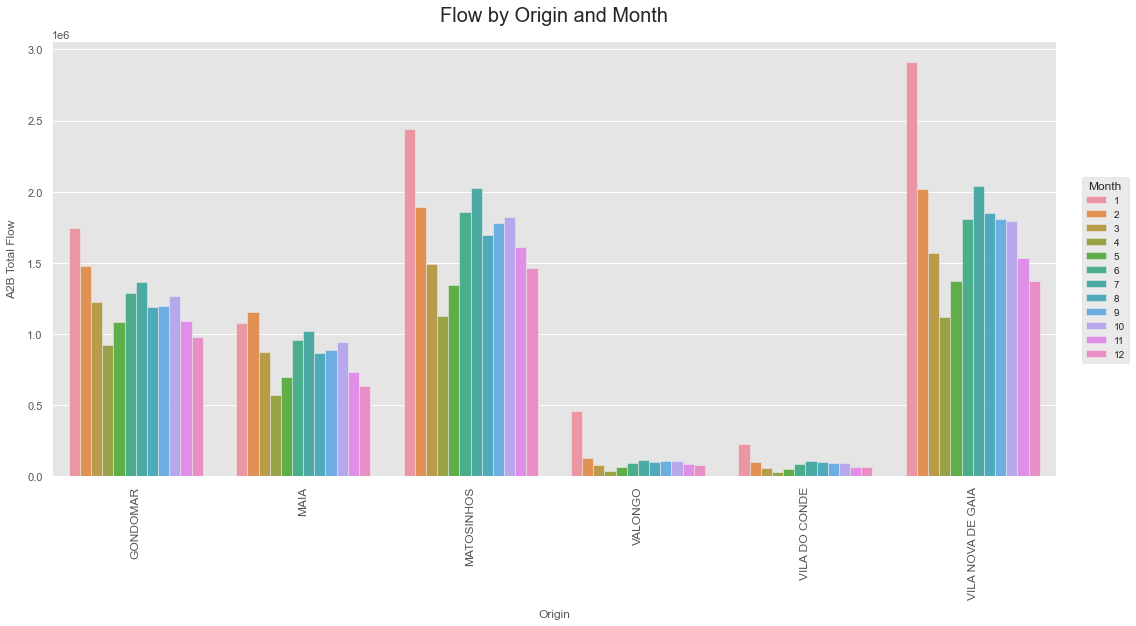

In [319]:
tmp = nos_mob_porto_month[nos_mob_porto_month['B'] == 'PORTO']
tmp = tmp.groupby(by = ['A', 'Month'])['A2B'].sum().reset_index()

f, ax = plt.subplots(figsize=(18, 8))
plt.style.use('ggplot')

sns.barplot(data = tmp, x = 'A', y = 'A2B', hue = 'Month')
#add title
ax.set_ylabel("A2B Total Flow",
             fontsize = 12,
             labelpad = 10)
ax.set_xlabel("Origin",
             fontsize = 12,
             labelpad =10)
ax.set_title("Flow by Origin and Month",
            fontsize = 20,
            pad = 20)
#add legend
ax.legend(title = "Month",
         fontsize = 10,
         title_fontsize = 12,
         bbox_to_anchor = (1.02, 0.7))
#adjust the tick paramaters
ax.tick_params(axis = "x",
              which = "both",
              labelrotation = 90,
              labelsize = 12)
plt.show()

Flow by Month and Day of Week: Higher commuting occurs on week days and lower commuting levels were observed for the months at starting of pandemic or when higher restrictions were applied.

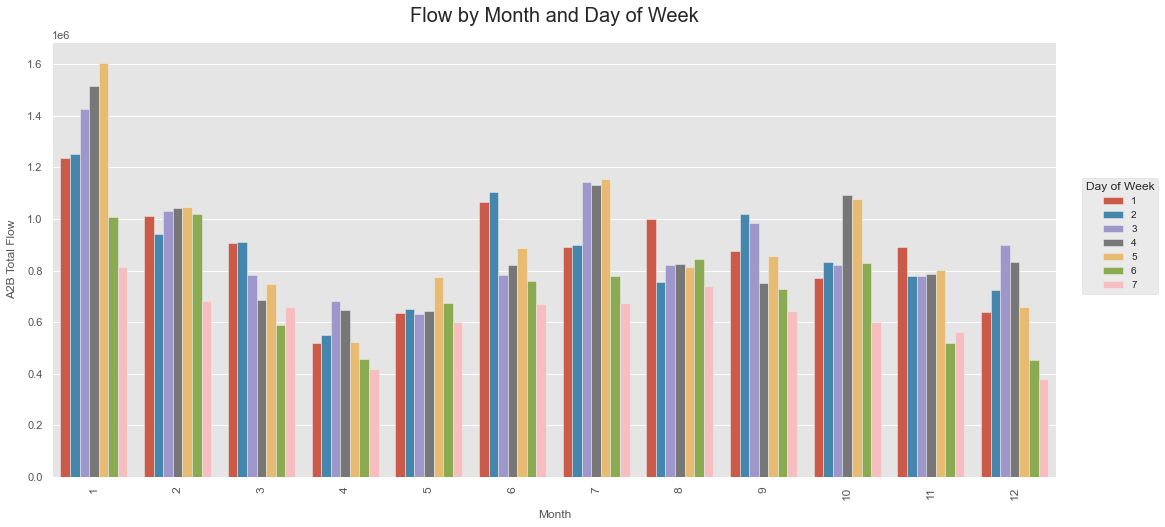

In [320]:
df = pd.read_excel("data/nos_mob_porto_day.xlsx")
tmp = df[df['B'] == 'PORTO']
tmp = tmp.groupby(by = ['Month', 'Day_of_Week'])['A2B_day'].sum().reset_index()

f, ax = plt.subplots(figsize=(18, 8))
plt.style.use('ggplot')

sns.barplot(data = tmp, x = 'Month', y = 'A2B_day', hue = 'Day_of_Week')
#add title
ax.set_ylabel("A2B Total Flow",
             fontsize = 12,
             labelpad = 10)
ax.set_xlabel("Month",
             fontsize = 12,
             labelpad =10)
ax.set_title("Flow by Month and Day of Week",
            fontsize = 20,
            pad = 20)
#add legend
ax.legend(title = "Day of Week",
         fontsize = 10,
         title_fontsize = 12,
         bbox_to_anchor = (1.02, 0.7))
#adjust the tick paramaters
ax.tick_params(axis = "x",
              which = "both",
              labelrotation = 90,
              labelsize = 12)
plt.show()

Flow by Restriction Level and Season: COVID restrictions highly affect commuting, most commuting to Porto occurs in Summer or in Winter season before pandemic

No handles with labels found to put in legend.


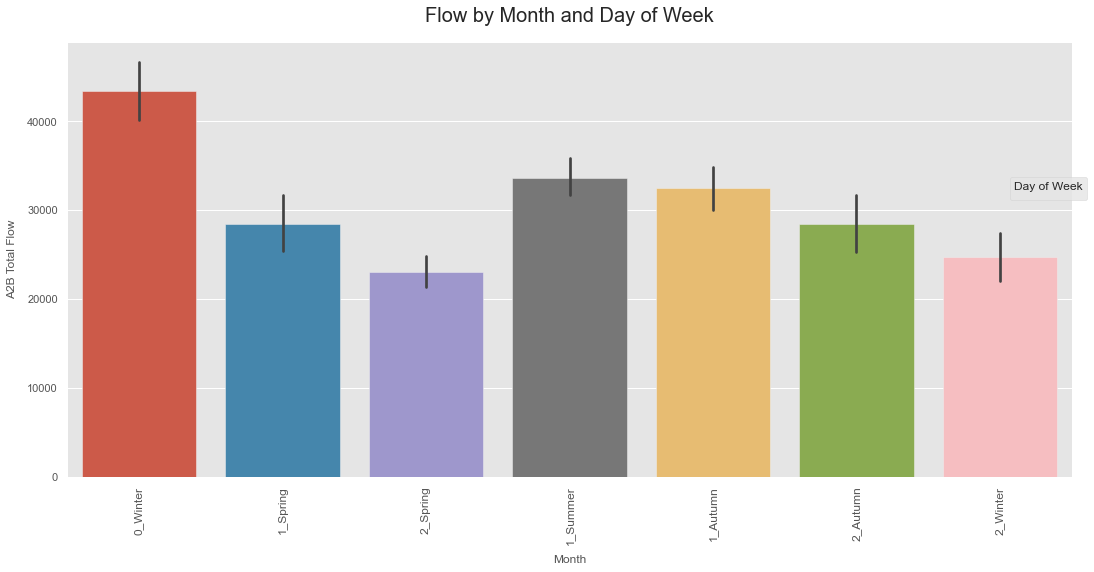

In [321]:
df = pd.read_excel("data/nos_mob_porto_day.xlsx")
tmp = df[df['B'] == 'PORTO']
tmp['Covid_Level_Season'] = tmp['Covid_Level'].astype(str) + "_" + tmp['Season']

f, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data = tmp, x = 'Covid_Level_Season', y = 'A2B_day')
#add title
ax.set_ylabel("A2B Total Flow",
             fontsize = 12,
             labelpad = 10)
ax.set_xlabel("Month",
             fontsize = 12,
             labelpad =10)
ax.set_title("Flow by Month and Day of Week",
            fontsize = 20,
            pad = 20)
#add legend
ax.legend(title = "Day of Week",
         fontsize = 10,
         title_fontsize = 12,
         bbox_to_anchor = (1.02, 0.7))
#adjust the tick paramaters
ax.tick_params(axis = "x",
              which = "both",
              labelrotation = 90,
              labelsize = 12)
plt.show()

Validations Flow by Month and Provider: COVID starting highly affected public transport usage, STCP and Metro usage are balanced.

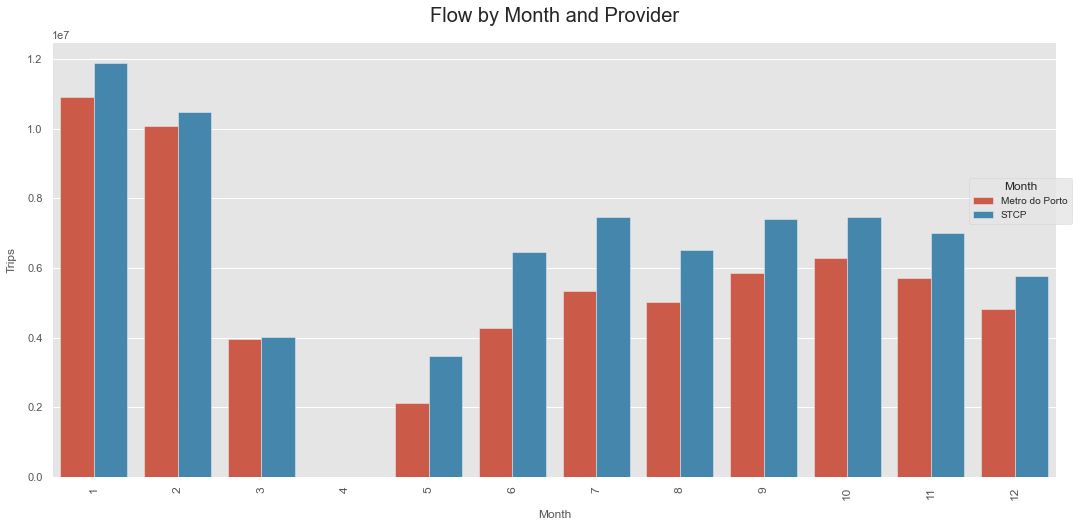

In [322]:
df = pd.read_excel('data/mod_z2z_day_groupbycity.xlsx', index_col=0)
tmp = df.groupby(by = ['Mês', 'Operador'])['Validações'].sum().reset_index()
tmp = tmp.rename(columns={'Mês': 'Month', 'Operador': 'Operator', 'Validações': 'Trips'})

f, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data = tmp, x = 'Month', y = 'Trips', hue = 'Operator')
#add title
ax.set_ylabel("Trips",
             fontsize = 12,
             labelpad = 10)
ax.set_xlabel("Month",
             fontsize = 12,
             labelpad =10)
ax.set_title("Flow by Month and Provider",
            fontsize = 20,
            pad = 20)
#add legend
ax.legend(title = "Month",
         fontsize = 10,
         title_fontsize = 12,
         bbox_to_anchor = (1.02, 0.7))
#adjust the tick paramaters
ax.tick_params(axis = "x",
              which = "both",
              labelrotation = 90,
              labelsize = 12)
plt.show()

### Modelling

We decided to use the LightGBM model. 

This decision was made because in the previous challenge, where we also worked with time series data, we tested different models, namely: Holt-Winters, SARIMA, LSTM, XGBoost and LightGBM and LightGBM presented the best results. So as we didn't have much time, we decided that we would start by using this model and if we had more time then we would also try other models.

The next cell contains all the functions used in the development of the LightGBM model.

First we present the functions used to do the preprocessing of the data. 

In [323]:
# Functions used preprocess the features used with the model

def label_university_holidays(row: pd.Series) -> int:
   """"
   Defines the percentage of university holidays per month.

   Args:
      row (pd.Series): input data. 
   
   Returns:
      int: percentage of university holidays.
   """

   if row['Month'] == 1:
      return 100
   if row['Month'] == 2:
      return int((10 / monthrange(2020, 2)[1]) * 100)
   if row['Month'] == 4:
      return int((8 / monthrange(2020, 4)[1]) * 100)
   if row['Month']  == 5:
      return int((5 / monthrange(2020, 5)[1]) * 100)
   if row['Month'] == 7:
      return int((17 / monthrange(2020, 7)[1]) * 100)
   if row['Month'] == 8:
      return 100
   if row['Month'] == 9:
      return int((21 / monthrange(2020, 9)[1]) * 100)
   if row['Month'] == 12:
      return int((20 / monthrange(2020, 12)[1]) * 100)
   return 0


def label_school_holidays(row: pd.Series) -> int:
   """"
   Defines the percentage of school holidays per month.

   Args:
      row (pd.Series): input data. 
   
   Returns:
      int: percentage of university holidays.
   """

   if row['Month'] == 1:
      return int((6 / monthrange(2020, 1)[1]) * 100)
   if row['Month'] == 2:
      return int((3 / monthrange(2020, 2)[1]) * 100)
   if row['Month'] == 3:
      return int((3 / monthrange(2020, 3)[1]) * 100)
   if row['Month']  == 4:
      return int((13 / monthrange(2020, 4)[1]) * 100)
   if row['Month'] == 6:
      return int((20 / monthrange(2020, 6)[1]) * 100)
   if row['Month'] == 7:
      return 100
   if row['Month'] == 8: 
      return 100
   if row['Month'] == 9:
      return int((13 / monthrange(2020, 9)[1]) * 100)
   if row['Month'] == 12:
      return int((13 / monthrange(2020, 12)[1]) * 100)
   return 0


def label_public_holidays(row: pd.Series) -> int:
    """"
    Defines the percentage of public holidays per month.
    
    Args:
        row (pd.Series): input data. 
    
    Returns:
        int: percentage of university holidays.
    """
    
    if row['Month'] == 1:
       return int((1 / monthrange(2020, 1)[1]) * 100)
    if row['Month']  == 4:
        return int((3 / monthrange(2020, 4)[1]) * 100)
    if row['Month'] == 5:
        return int((1 / monthrange(2020, 5)[1]) * 100)
    if row['Month'] == 6:
        return int((3 / monthrange(2020, 6)[1]) * 100)
    if row['Month'] == 8:
        return int((1 / monthrange(2020, 8)[1]) * 100)
    if row['Month'] == 10:
        return int((1 / monthrange(2020, 10)[1]) * 100)
    if row['Month'] == 11:
        return int((1 / monthrange(2020, 11)[1]) * 100)
    if row['Month'] == 12:
        return int((3 / monthrange(2020, 12)[1]) * 100)
    return 0


def shifted_features(df: pd.DataFrame, groupby_vars: list, variable: str) -> pd.DataFrame:
    """
    Shifts time-relevant columns by 5 hours(hourly)/days(daily) to allow the algorithm to learn time dependencies.

    Args:
        df (pd.DataFrame): input data for each component
        groupby_vars (list): list with the variables to be used in the group by
        variable (str): time-relevant column

    Returns:
        pd.DataFrame: input data for each component + time based features
    """

    df_new = pd.DataFrame()
    for i in range(1, 6):
        df[variable + "_shifted-" + str(i)] = df.groupby(groupby_vars)[variable].shift(i)

    df_new = pd.concat([df_new, df])

    return df_new


def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Does some data engineering on the input data.

    Args:
        df (pd.DataFrame): input data

    Returns:
        (pd.DataFrame): data with applied transformations.
    """
    
    if DF_TYPE == "daily":
        df = df.rename(columns={"Day": "date"}) #"Vacations": "stcp_vacation_period"})

        # university holidays
        mask = (df['date'] <= "2020-02-10") | \
            ((df['date'] >= "2020-04-06") & (df['date'] <= "2020-04-13")) | \
            ((df['date'] >= "2020-05-04") &  (df['date'] <= "2020-05-08")) | \
            ((df['date'] >= "2020-07-15") &  (df['date'] <= "2020-07-31")) | \
            ((df['date'] >= "2020-08-01") &  (df['date'] <= "2020-09-21")) | \
            (df['date'] >= "2020-12-21")

        df['university_holidays'] = np.where(mask == True, 1, 0)
        
        # school holidays
        mask = (df['date'] <= "2020-01-06") | \
            ((df['date'] >= "2020-02-24") & (df['date'] <= "2020-02-26")) | \
            ((df['date'] >= "2020-03-28") &  (df['date'] <= "2020-04-13")) | \
            ((df['date'] >= "2020-06-10") &  (df['date'] <= "2020-09-13")) | \
            (df['date'] >= "2020-12-19")

        df['school_holidays'] = np.where(mask == True, 1, 0)

        # public holidays
        df = df.assign(public_holiday=df['date'].isin(holidays.Portugal(years=2020)).astype(int))
        # porto public holiday
        indexes = df[df['date'] == "2020-06-24"].index
        for i in indexes:
            df.loc[i, 'public_holiday'] = 1

        df = df.drop(['Season', 'B2A_day', 'Dia', 'Vacations'], axis=1)  
        df = df.sort_values(by=['A', 'B', 'date']) 
    else:
         # university holidays
        df['university_holidays(%)'] = df.apply(lambda row: label_university_holidays(row), axis=1)
        
        # school holidays
        df['school_holidays(%)'] = df.apply(lambda row: label_school_holidays(row), axis=1)
    
        # public holidays
        df['public_holidays(%)'] = df.apply(lambda row: label_public_holidays(row), axis=1)

        df = df.drop(['Season', 'B2A_day'], axis=1)
        df = df.sort_values(by=['A', 'B', 'Month'])
    

    # shifted variables
    df = shifted_features(df, ['A', 'B'], 'A2B_day')

    # windows = [7, 30, 90]
    # alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
    # lags = [7, 30, 90]
    # df = roll_mean_features(df, windows, 'A2B_day')
    # df = ewm_features(df, alphas, lags, 'A2B_day')

    # create column A_B that is the combination of A and B (Ex: PORTO_GONDOMAR)
    df['A2B']=df['A']+'_'+df['B']
    # One-hot encode variable A2B
    # Get Dummies
    A2B = pd.get_dummies(df['A2B'], prefix='A2B', drop_first=False)
    # Join datasets
    df = pd.concat([df, A2B], axis=1)

    return df        

Next are the functions done to train the model.

We performed hyperparameter optimization on all the models and used the best resulting hyperparemeters in our final models. 

Furthermore, as we realized that our models were mostly underestimated, we decided to use an asymmetric loss that penalizes these situations more and this way we were able to solve this problem. Also, when we think about the problem from a business point of view, it is preferable that we have a model with a little overestimation, since having more means of transport than the flow of people using it is a less problematic situation than the other way around. 

In [324]:
hpo_params_lgb = {
    # hyperparemeter to control tree structure
    # num_leaves => number of decision leaves in a single tree. (How many nodes where an actual decision happens in a single tree) 
    # max_depth => the higher more levels the tree has, which makes it more complex and prone to overfit. To low and prone to underfit.
    # min_data_in_leaf => specifies the minimum number of observations that fit the decision criteria in a leaf 
    # ---------
    # hyperparemeter for better accuracy
    # n_estimators => controls the number of decision trees
    # learning_rate => step size parameter of the gradient descent
    # ---------
    # hyperparemeter to control overfitting
    # lambda_l1 => L1 regularization
    # lambda_l2 => L2 regularization
    # min_gain_to_split => it can be used as extra regularization in large parameters grids
    # bagging_fraction => specifies the percentage of training samples to be used to train each tree
    # bagging_freq =>  
    # feature_fraction => specifies the percentage of features to be used to train each tree

    "num_leaves": np.arange(20, 3000, 20),
    "max_depth": [1, 3, 6, 10, 20],
    "min_data_in_leaf": np.arange(200, 10000, 100),
    "n_estimators": np.arange(100, 5000, 100),
    "learning_rate": np.arange(0.01, 0.3, 0.05),
    "lambda_l1": np.arange(0, 100, 5),
    "lambda_l2": np.arange(0, 100, 5),
    "min_gain_to_split": [0.1, 0.15, 0.2, 0.25, 0.5, 1],
    "bagging_fraction": np.arange(0.3, 1.0, 0.1),
    "bagging_freq": [1],
    "feature_fraction": np.arange(0.3, 1.0, 0.1)
}


class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)


def tune_model_lgb(X_train: pd.DataFrame, 
                    Y_train: pd.DataFrame, 
                    X_val: pd.DataFrame, 
                    Y_val: pd.DataFrame) -> None:
    """
    Performs HPO for a dimension

    Args:
        dim (str): dimension to be tuned (width, weight, ...)
        train (pd.DataFrame): train data
        val (pd.DataFrame): val data (for early stopping)

    Returns:
        None (best params are stored on disk)
    """
    
    eval_set = [(X_val, Y_val)]
    
    mdl = lgb.LGBMRegressor(objective='rmse',
                        n_estimators=5000,
                        boosting_type='gbdt',
                        random_state=42)

    clf = RandomizedSearchCV(estimator=mdl,
                             param_distributions=hpo_params_lgb,
                             scoring='neg_mean_squared_error',
                             n_iter=20,
                             verbose=0,
                             cv=5,
                             random_state=42)
    
    clf.fit(X_train,
            Y_train,
            eval_set=eval_set,
            early_stopping_rounds=20)

    # with open("results/best_params.txt", "w") as file:
    #     file.write(json.dumps(clf.best_params_, cls=NpEncoder))


class AsymmetricLoss:
    """
    Class that provides asymmetric custom loss functions for LightGBM.
    """

    def __init__(self):
        self.penalty = PENALTY

    def custom_asymmetric_train(self, y_pred: list, dataset_true: lgb.Dataset) -> tuple:
        """
        Custom loss function for model training, penalizes underforecasting.

        Args:
            y_pred (list): predictions
            dataset_true (lgb.Dataset): LGBM dataset containing true values

        Returns:
            tuple: gradient and hessian
        """
        y_true = dataset_true.get_label()
        residual = (y_true - y_pred).astype("float")
        grad = np.where(residual > 0, -2 * self.penalty * residual, -2 * residual)
        hess = np.where(residual > 0, 2 * self.penalty, 2.0)
        return grad, hess

    def custom_asymmetric_valid(self, y_pred: list, dataset_true: lgb.Dataset) -> tuple:
        """
        Custom loss function for model validation, penalizes underforecasting
        
        Args:
            y_pred (list):  predictions
            dataset_true (lgb.Dataset): LGBM dataset containing true values
        
        Returns:
            tuple: name of metric, loss, boolean indicating whether higher is better
        """
        y_true = dataset_true.get_label()
        residual = (y_true - y_pred).astype("float")
        loss = np.where(residual > 0, (residual**2) * self.penalty, residual**2)
        return "custom_asymmetric_eval", np.mean(loss), False


def split_data(df: pd.DataFrame) -> tuple:
    """splits data into train, test, val based on groupby run_id to avoid info leakage

    Args:
        df (pd.DataFrame): data

    Returns:
        tuple: data splitted into train, val, test
    """

    if DF_TYPE == "daily" or DF_TYPE == "daily_pt":
        train = df.loc[(df['date'] <= "2020-10-31"), :]
        val = df.loc[(df['date'] > "2020-11-01") & (df['date'] <= "2020-11-30"), :]
        test = df.loc[(df['date'] > "2020-11-30"), :]
    else:
        train = df.loc[(df['Month'] <= 10), :]
        val = df.loc[(df['Month'] == 11), :]
        test = df.loc[(df['Month'] == 12), :]

    return train, val, test


def train_model_lgb(X_train: pd.DataFrame, 
                    Y_train: pd.DataFrame, 
                    X_val: pd.DataFrame, 
                    Y_val: pd.DataFrame) -> lgb.Booster:
    """
    Trains and validates an LightGBM Model with early stopping.

    Args:
        X_train (pd.DataFrame): train data
        Y_train (pd.DataFrame): train target
        X_val (pd.DataFrame): val data (for early stopping)
        Y_val (pd.DataFrame): val target (for early stopping)

    Returns:
        lgb.Booster: fitted model
    """
    
    cols = X_train.columns.to_list()
    lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
    lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

    try:
       f = open("results/" + DF_TYPE + "/best_params_" + DF_TYPE + ".txt", "r")
       lgb_params = json.loads(str(f.read()))
       lgb_params["seed"] = 42
       lgb_params["verbose"] = -1
       f.close()
    except FileNotFoundError:
        lgb_params = {
            "config": "train",
            "objective": "regression_l1",
            "boosting": "gbdt",
            "num_iterations": 5000,
            "learning_rate": 0.05,
            "num_leaves": 60,
            "tree_learner": "data_parallel",
            "num_threads": 16,
            "seed": 42,
            "deterministic": True,
            "bagging_fraction": 0.6,
            "bagging_freq": 1,
            "feature_fraction": 0.9,
            "feature_fraction_bynode": 0.9,
            "early_stopping_round": 50,
            "max_depth": 20,
            "verbose": -1,
            "silent": True
    }

    al = AsymmetricLoss()
    model = lgb.train(lgb_params,
                    lgbtrain,
                    valid_sets=[lgbval],
                    fobj=al.custom_asymmetric_train,
                    feval=al.custom_asymmetric_valid,
                    verbose_eval=-1
                    )


    return model

Finally, we have the functions used to evaluate the results. 

We decided that it would be interesting and give more confidence to the people who use our final product to understand the reasons why the models are predicting these mobility values. So we are using the shap library to know for each example which 2 variables have the most influence on the forecast, and then in our final product - a dashboard - we show these reasons to the user.  

In [325]:
def eval_model(model: lgb.Booster, 
               X_test: pd.DataFrame, 
               Y_test: pd.DataFrame) -> list:
    """
    Evaluates model of a dimension with regards to test data.

    Args:
        model (lgb.Booster): model to be evalued
        X_test (pd.DataFrame): test data
        Y_test (pd.DataFrame): test target
    
    Returns:
        list: list of eval metrics
    """
    preds = model.predict(X_test)

    return [mean_absolute_error(preds, Y_test), 
        mean_absolute_percentage_error(preds, Y_test) * 100,
        preds]


def save_error_results(metrics: list) -> None:
    """
    Saves eval metrics into a a file.

    Args:
        metrics (list): list of eval metrics
    """
    f = open('results/' + DF_TYPE + '/' + DF_TYPE + "_predsLGBM_errors.txt", "w")
    f.write("----------------------------------- \n")
    f.write("MAE: " + str(metrics[0]) + "\n" + "MAPE: " + str(metrics[1]) + "\n")
    f.write("----------------------------------- \n")
    f.close()


def plot_lgb_importances(model: lgb.Booster) -> None:
    """
    Plots the most important features of the model.

    Args:
        model (lgb.Booster): trained model 
    """
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
    plt.xlabel("Gain")
    plt.ylabel('Features')
    plt.title(f'Feature importance for {DF_TYPE} model:', fontsize=20)
    plt.tight_layout()
    plt.savefig('results/' + DF_TYPE + '/Feature Importance')


def plot_images(model: lgb.Booster,
                df_output: pd.DataFrame) -> None:
    """
    Plot some graphs for the test set for visual inspection.

    Args:
        model: 
        preds (list): preds obtained from evaluating
        df_output (pd.DataFrame): dataframe with the predictions and 
         true values for each example of test set.
    """
    OPERAT = False 
    if DF_TYPE == "daily":
        variable = "A2B_day"
        y_label = "Mobility Flow"
        scatter_size = 75000
        nrows=6
        str_model_preds = "DAILY MOBILITY FLOW" 
    elif DF_TYPE == "daily_pt":
        variable = "trip_validations"
        y_label = "Mobility flow using public transport"
        scatter_size = 20000
        nrows=6
        OPERAT = True
        operator = df_output['operator'].unique()[0]
        str_model_preds = "DAILY MOBILITY FLOW BY PUBLIC TRANSPORT"
    elif DF_TYPE == "monthly":
        variable = "A2B_day"
        scatter_size = 1.6
        str_model_preds = "MONTHLY MOBILITY FLOW"
    else:
        variable = "trip_validations"
        scatter_size = 1.6
        OPERAT = True
        operator = df_output['operator'].unique()[0]
        str_model_preds = "MONTHLY MOBILITY FLOW BY PUBLIC TRANSPORT"
    
    print(" ******************************************** ")
    print(f" RESULTS OF MODEL THAT PREDICTS {str_model_preds} ")
    print(" ******************************************** ")

    if DF_TYPE == "daily" or DF_TYPE == "daily_pt":
        # image 1 - plot the predictions of all 
        fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(30, 30))
        routes = df_output['A2B'].unique().tolist()

        i = 0
        j = 0
        for idx in range(len(routes)):
            route = routes[idx]
            tmp = df_output[df_output['A2B'] == route]
            ax = sns.lineplot(x=tmp.reset_index(drop=True).index, y=tmp['predictions'], ax=axes[i, j], label='Predictions')
            ax = sns.lineplot(x=tmp.reset_index(drop=True).index, y=tmp[variable], ax=axes[i, j], label= 'True values')
            ax.set_xlabel("Days", fontsize=15)
            ax.set_ylabel(y_label, fontsize=15)
            #ax.legend('Center left')
            if OPERAT:
                ax.set_title(f'Route: {route} - Operator: {operator}', fontsize=18)
            else:
                ax.set_title(f'Route: {route}', fontsize=18)
            # image position logic
            if idx % 2 != 0:
                i += 1
                j -= 1
            else:
                j += 1

        fig.tight_layout()
    else:
        # image 1 - predictions vs true value for each route
        tmp = df_output.drop(['A', 'B', 'Month'], axis=1).reset_index(drop=True)
        tmp = tmp.rename(columns={variable: "True values", "predictions": "Predictions"})
        
        plt.figure(figsize=(24,8))
        tmp.plot(x="A2B", y=["True values", "Predictions"], kind="barh", figsize=(9, 8))
        if OPERAT:
            plt.title(f'Comparison between true and predicted values - Operator: {operator}', fontsize=20)
            plt.savefig('results/' + DF_TYPE + '/' + DF_TYPE + '_predsLGBM_' + operator)
        else:
            plt.title('Comparison between true and predicted values', fontsize=20)
            plt.savefig('results/' + DF_TYPE + '/' + DF_TYPE + '_predsLGBM')

    # image 2 - scatter plot between predicted vs true values
    plt.figure(figsize=(24,8))
    plt.scatter(df_output[variable], df_output['predictions'], c="steelblue")
    plt.plot( [0,scatter_size],[0,scatter_size], c='dimgrey' )
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    if OPERAT:
        plt.title(f'Comparison between true and predicted values - Operator: {operator}', fontsize=20)
        plt.savefig('results/' + DF_TYPE + '/' + DF_TYPE + '_scatterPlot_' + operator)
    else:
        plt.title('Comparison between true and predicted values', fontsize=20)
        plt.savefig('results/' + DF_TYPE + '/' + DF_TYPE + '_scatterPlot')

    # image 3 - feature importance
    if (OPERAT == False) or (OPERAT == True and operator == "Metro do Porto"):
        plot_lgb_importances(model)


def shapley_feature_ranking(shap_values: np.ndarray, X_test: pd.DataFrame, example_idx: int) -> list:
    """
    Auxiliar function to identify for each example the two top reasons 
    why the model is giving this predictions.

    Args:
    shap_values (np.ndarray): with the shap value of the X_test. 
    X_test (pd.DataFrame): test dataframe.
    example_idx (int): indicates the index of the example for which we want 
    to calculate the two main features.

    Returns:
    list: with the two main features for the respective example.
    """
    feature_order = np.argsort(np.abs(shap_values[example_idx]), axis=0)
    df_tmp = pd.DataFrame(
        {
            "features": [X_test.columns[i] for i in feature_order][::-1],
            "importance": [
                np.abs(shap_values)[example_idx][i] for i in feature_order
            ][::-1]
        }
    )

    # remove when shifted variables are the most important
    not_interesting_features = tuple(['A2B', 'value', 'trip_'])
    df_tmp = df_tmp[~df_tmp['features'].str.startswith(not_interesting_features)].reset_index(drop=True)

    return df_tmp.loc[:1,]['features'].to_list()


def get_reasons_for_preds(model: lgb.Booster, X_test: pd.date_range, df_output: pd.DataFrame, sufix: str) -> pd.DataFrame:
    """
    Identify for each example the two top reasons 
    why the model is giving this predictions.

    Args:
        model (lgb.Booster): trained model
        X_test (pd.date_range): test data
        df_output (pd.DataFrame): final dataframe that will be used for next tasks
        It has - preds + true values + data + location A + location B
        sufix (str): indicates te type of model being analized

    Returns: 
        pd.DataFrame: final dataframe that will be used for the next tasks with the 
        two main reasons for each example already added.
    """
    model.params['objective'] = 'regression'
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    df_output['reason_1' + sufix] = ""
    df_output['reason_2' + sufix] = ""

    for example_idx in range(df_output.shape[0]):
        top_2_reasons = shapley_feature_ranking(shap_values, X_test, example_idx)
        df_output['reason_1' + sufix][example_idx] = top_2_reasons[0]
        df_output['reason_2' + sufix][example_idx] = top_2_reasons[1]

    return df_output

Our approach was to build two models for two different time forecasts - daily and monthly - thus ending up with 4 models. 

First, we build a model for the hourly forecast of people moving from point A to point B.

 ******************************************** 
 RESULTS OF MODEL THAT PREDICTS DAILY MOBILITY FLOW 
 ******************************************** 


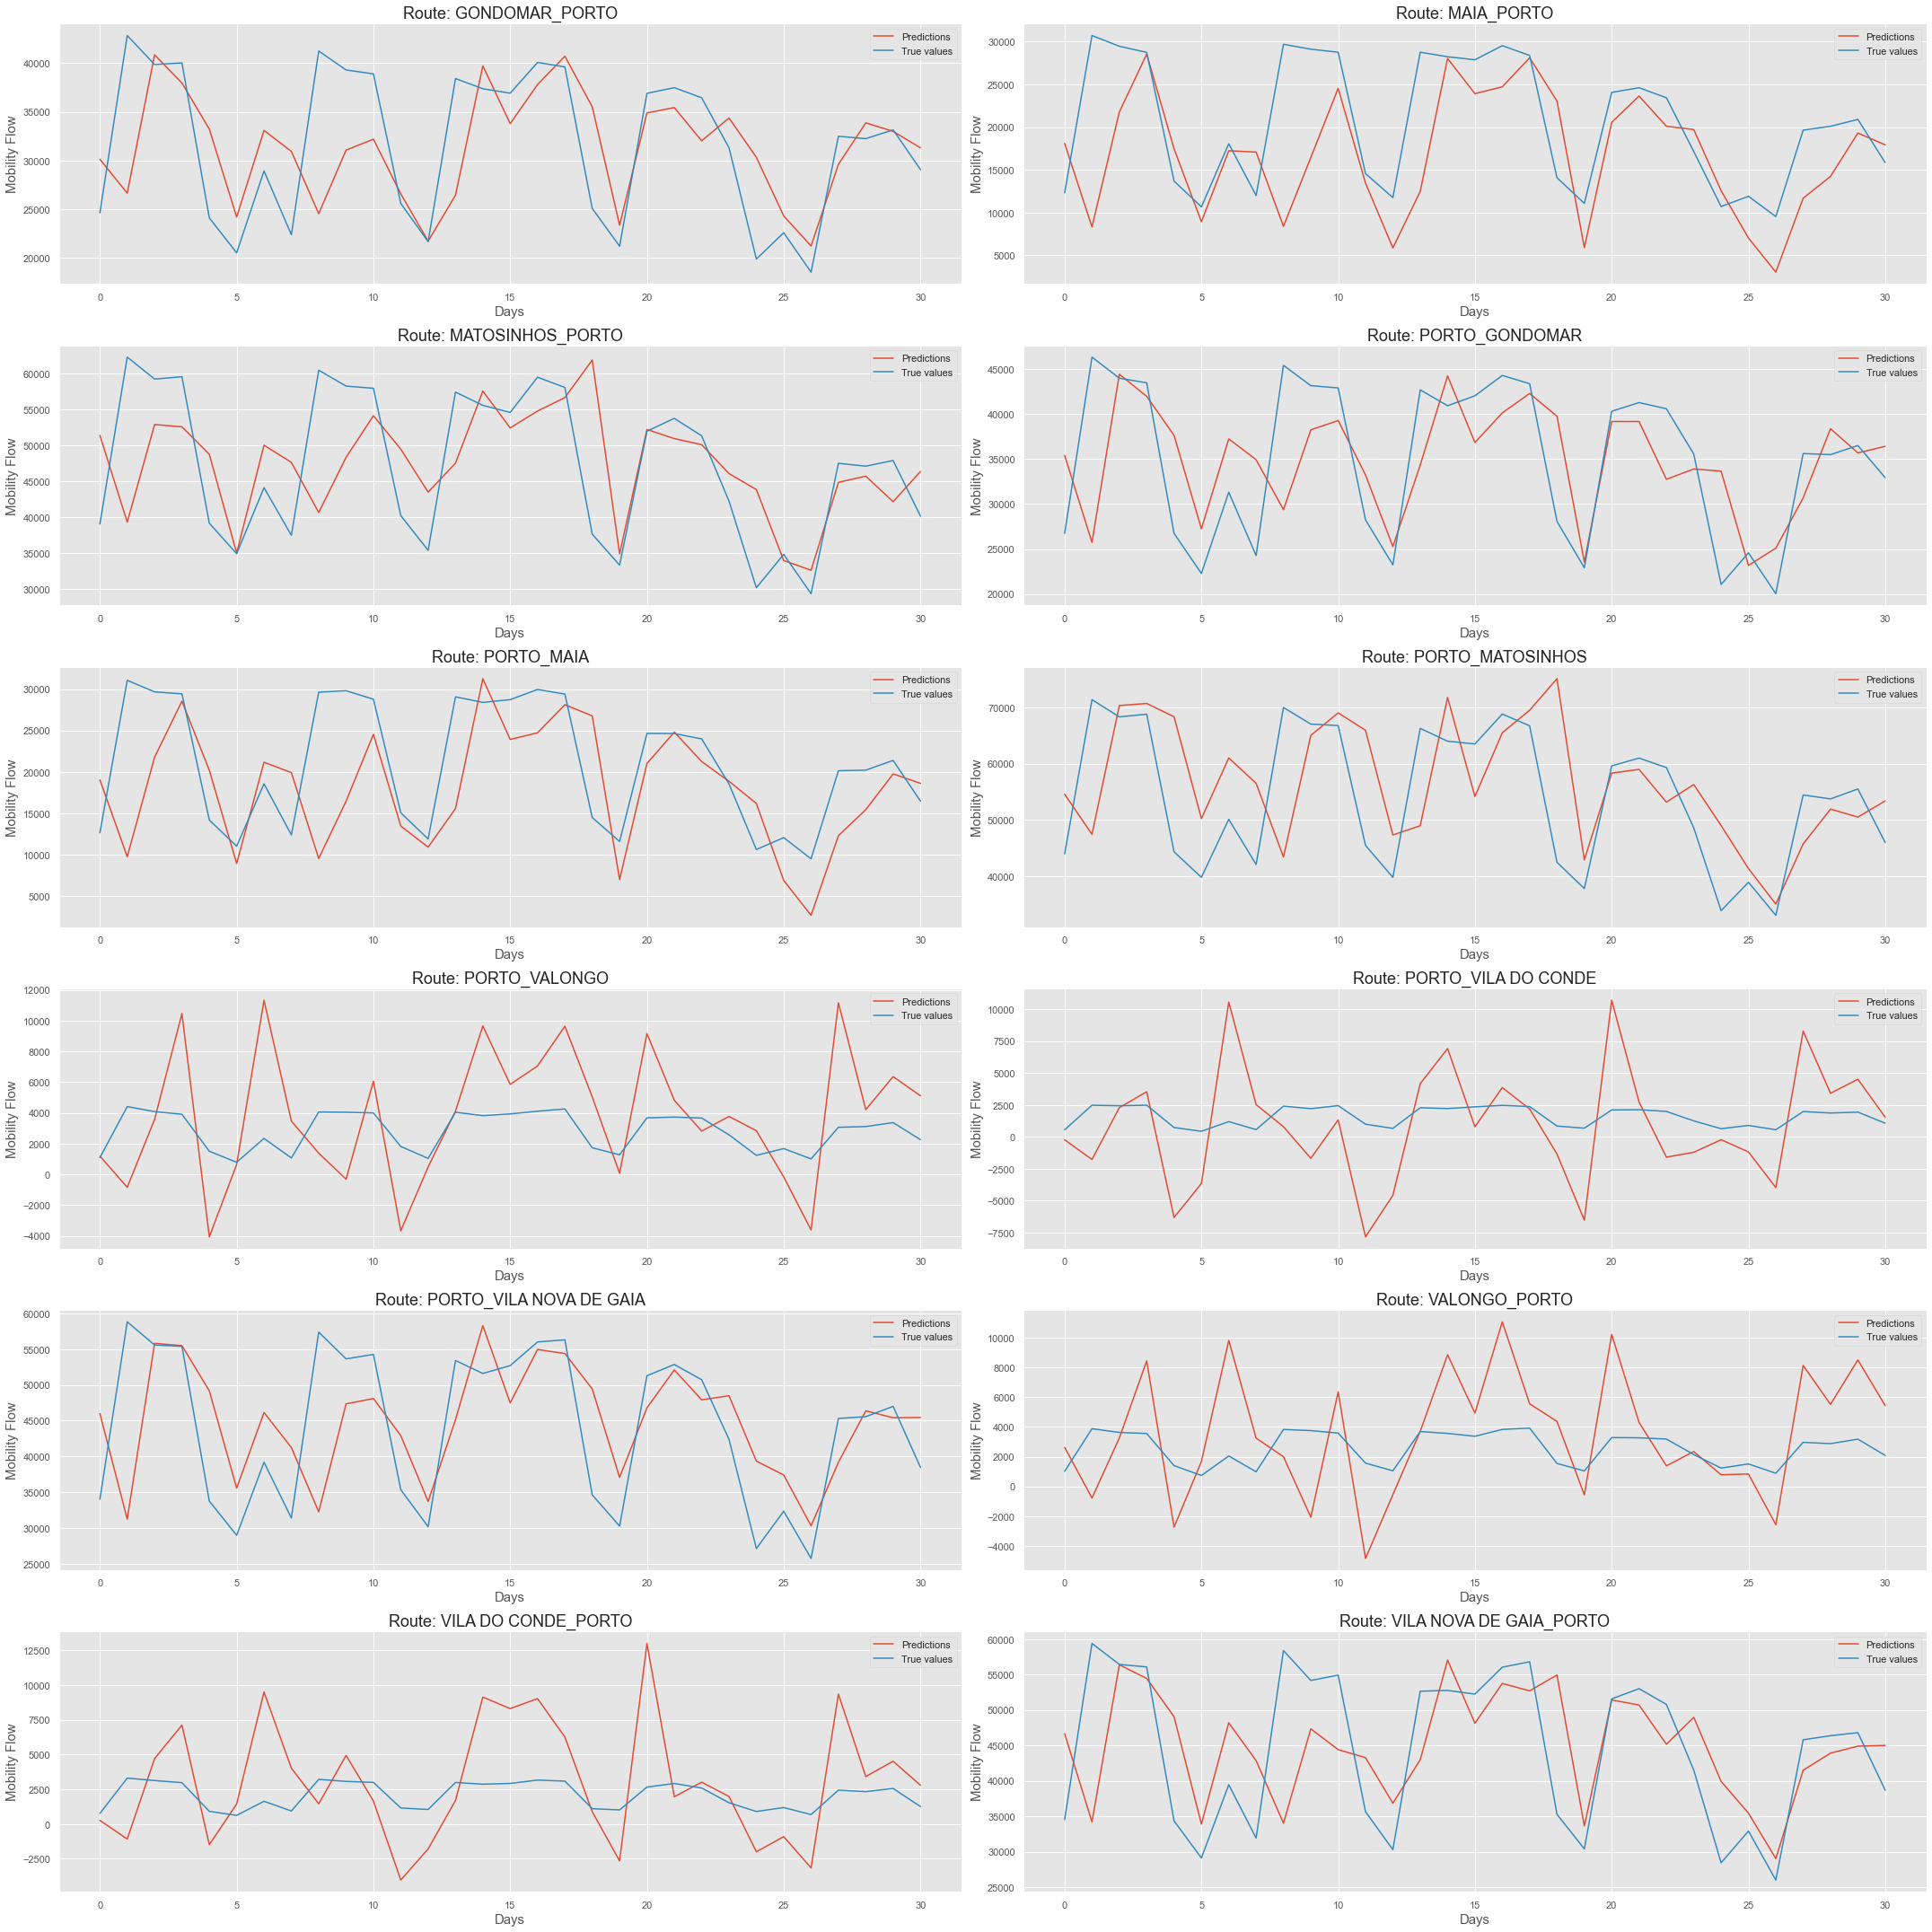

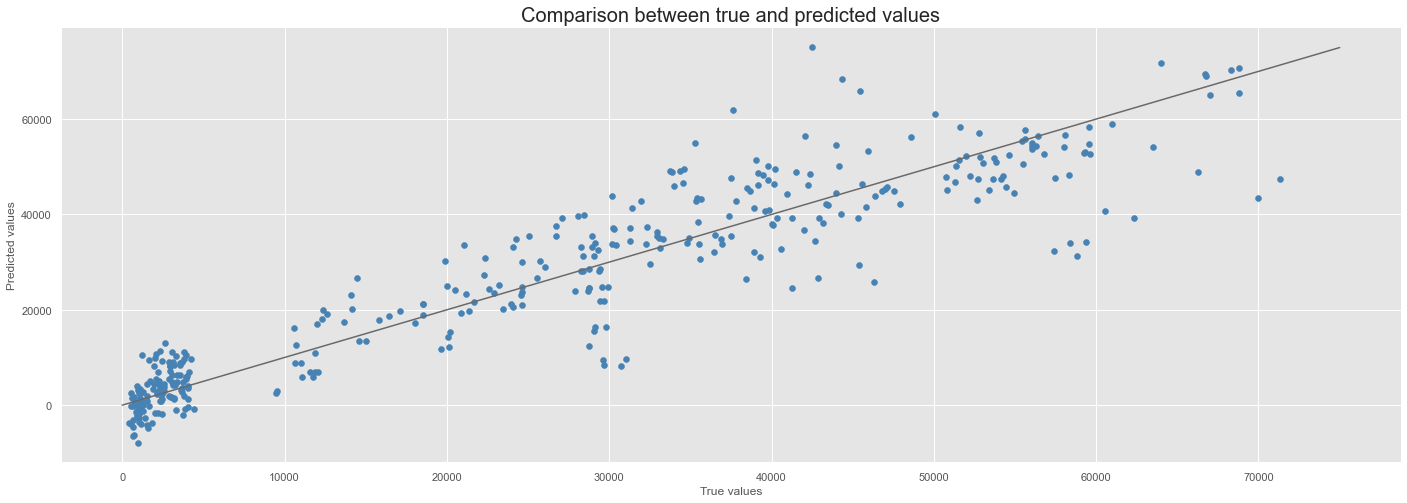

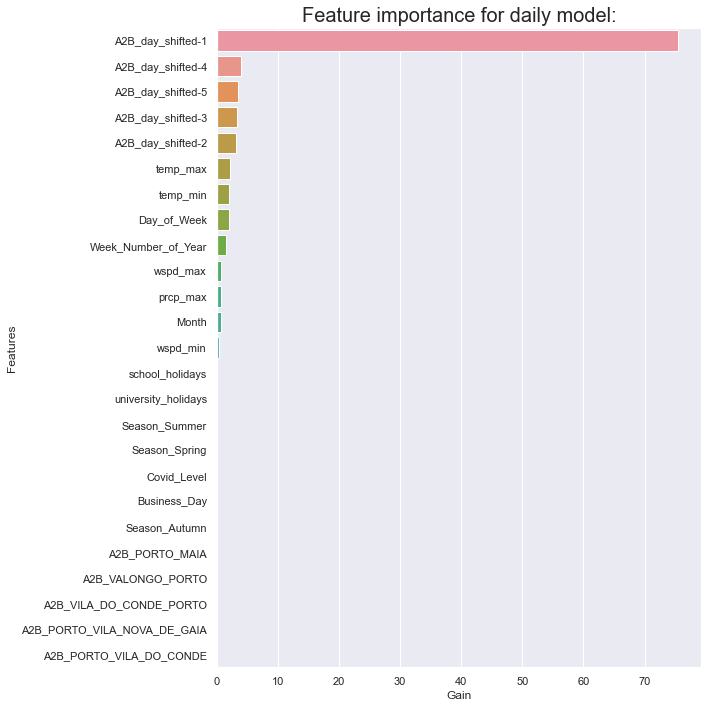

In [326]:
DF_TYPE = "daily"
PENALTY = 4
TUNE = False

df = pd.read_excel("data/nos_mob_porto_day.xlsx")
df = create_features(df)
train, val, test = split_data(df)

# save to use later
df_output = test[['A2B', 'A', 'B', 'date', 'A2B_day']].reset_index(drop=True)

Y_train = train['A2B_day']
X_train = train.drop(['A2B_day', 'date', 'A', 'B', 'A2B'], axis=1)

Y_val = val['A2B_day']
X_val = val.drop(['A2B_day', 'date', 'A', 'B', 'A2B'], axis=1)

Y_test = test['A2B_day']
X_test = test.drop(['A2B_day', 'date', 'A', 'B', 'A2B'], axis=1)

if TUNE:
    tune_model_lgb(X_train, Y_train, X_val, Y_val)
else:
    model = train_model_lgb(X_train, Y_train, X_val, Y_val)
    metrics = eval_model(model, X_test, Y_test)

    df_output['predictions']=metrics[2]

    # save predictions/results
    df_output.to_csv(f'results/{DF_TYPE}/{DF_TYPE}_predsLGBM.csv', sep=",")
    save_error_results(metrics)

    # visualize results
    plot_images(model, df_output)

    # get top 2 reasons
    df_output = get_reasons_for_preds(model, X_test, df_output, "_mobilityflow").drop(['A2B'], axis=1)
    df_output.to_csv("results/daily/daily_df_output.csv", index=False)
    df_output

Then, we built a model for the hourly forecast of people moving from point A to point B using public transport, namely Metro and STCP.

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	valid_0's custom_asymmetric_eval: 6.56133e+06
 ******************************************** 
 RESULTS OF MODEL THAT PREDICTS DAILY MOBILITY FLOW BY PUBLIC TRANSPORT 
 ******************************************** 
 ******************************************** 
 RESULTS OF MODEL THAT PREDICTS DAILY MOBILITY FLOW BY PUBLIC TRANSPORT 
 ******************************************** 


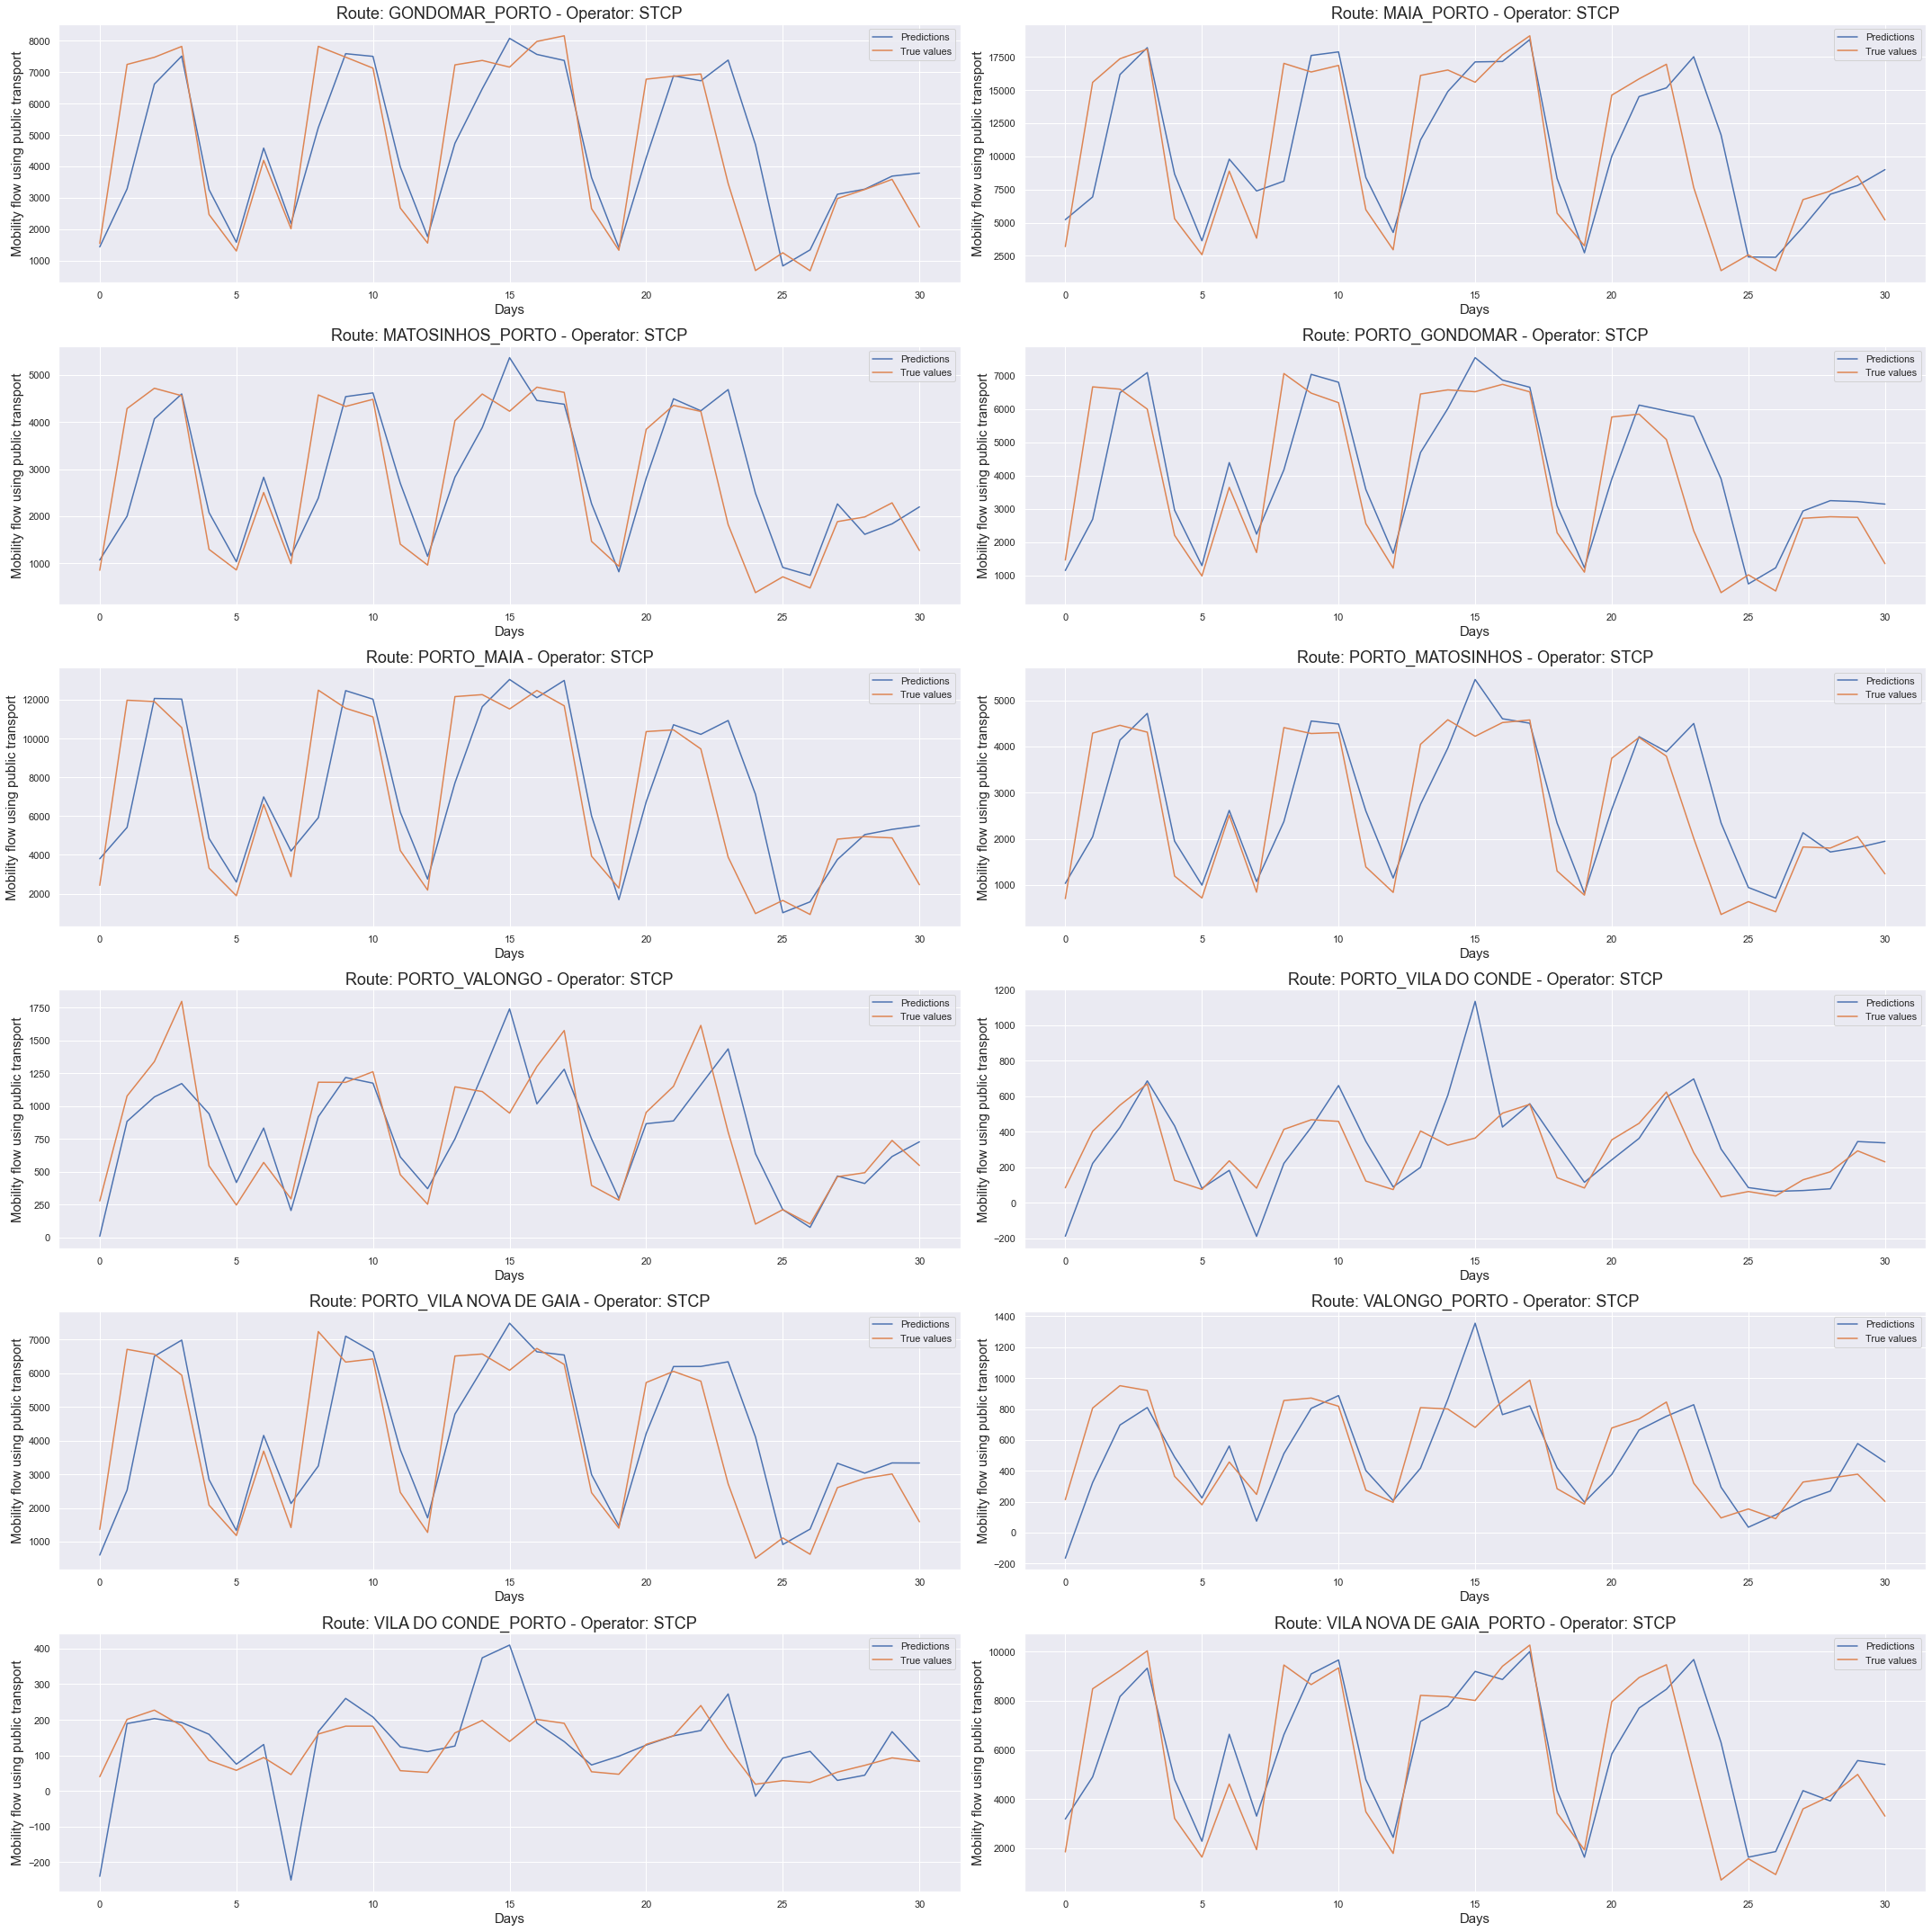

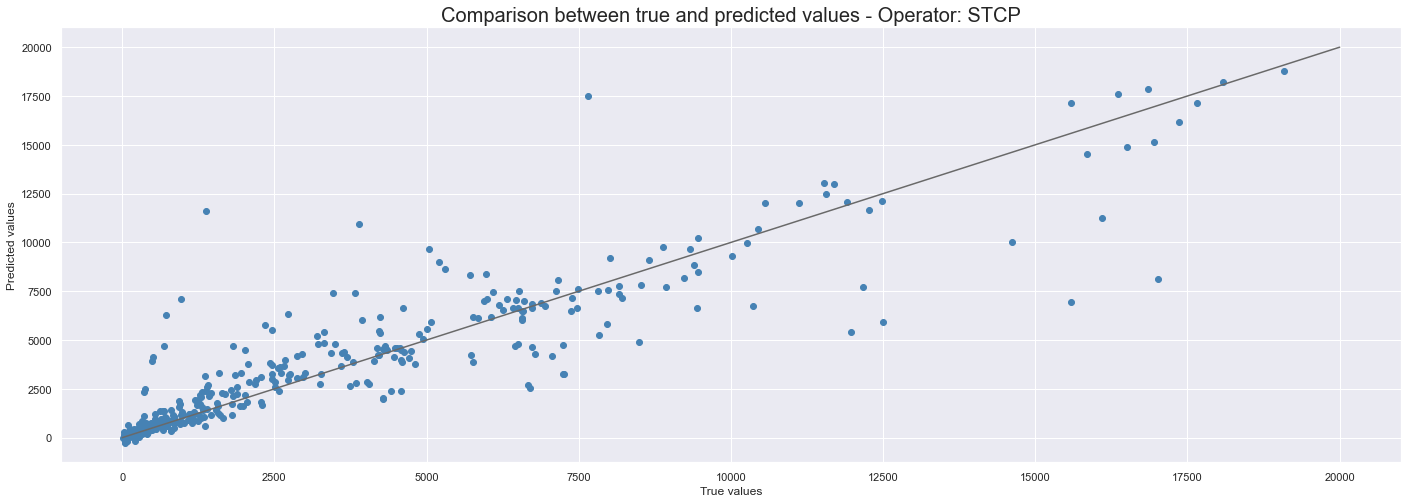

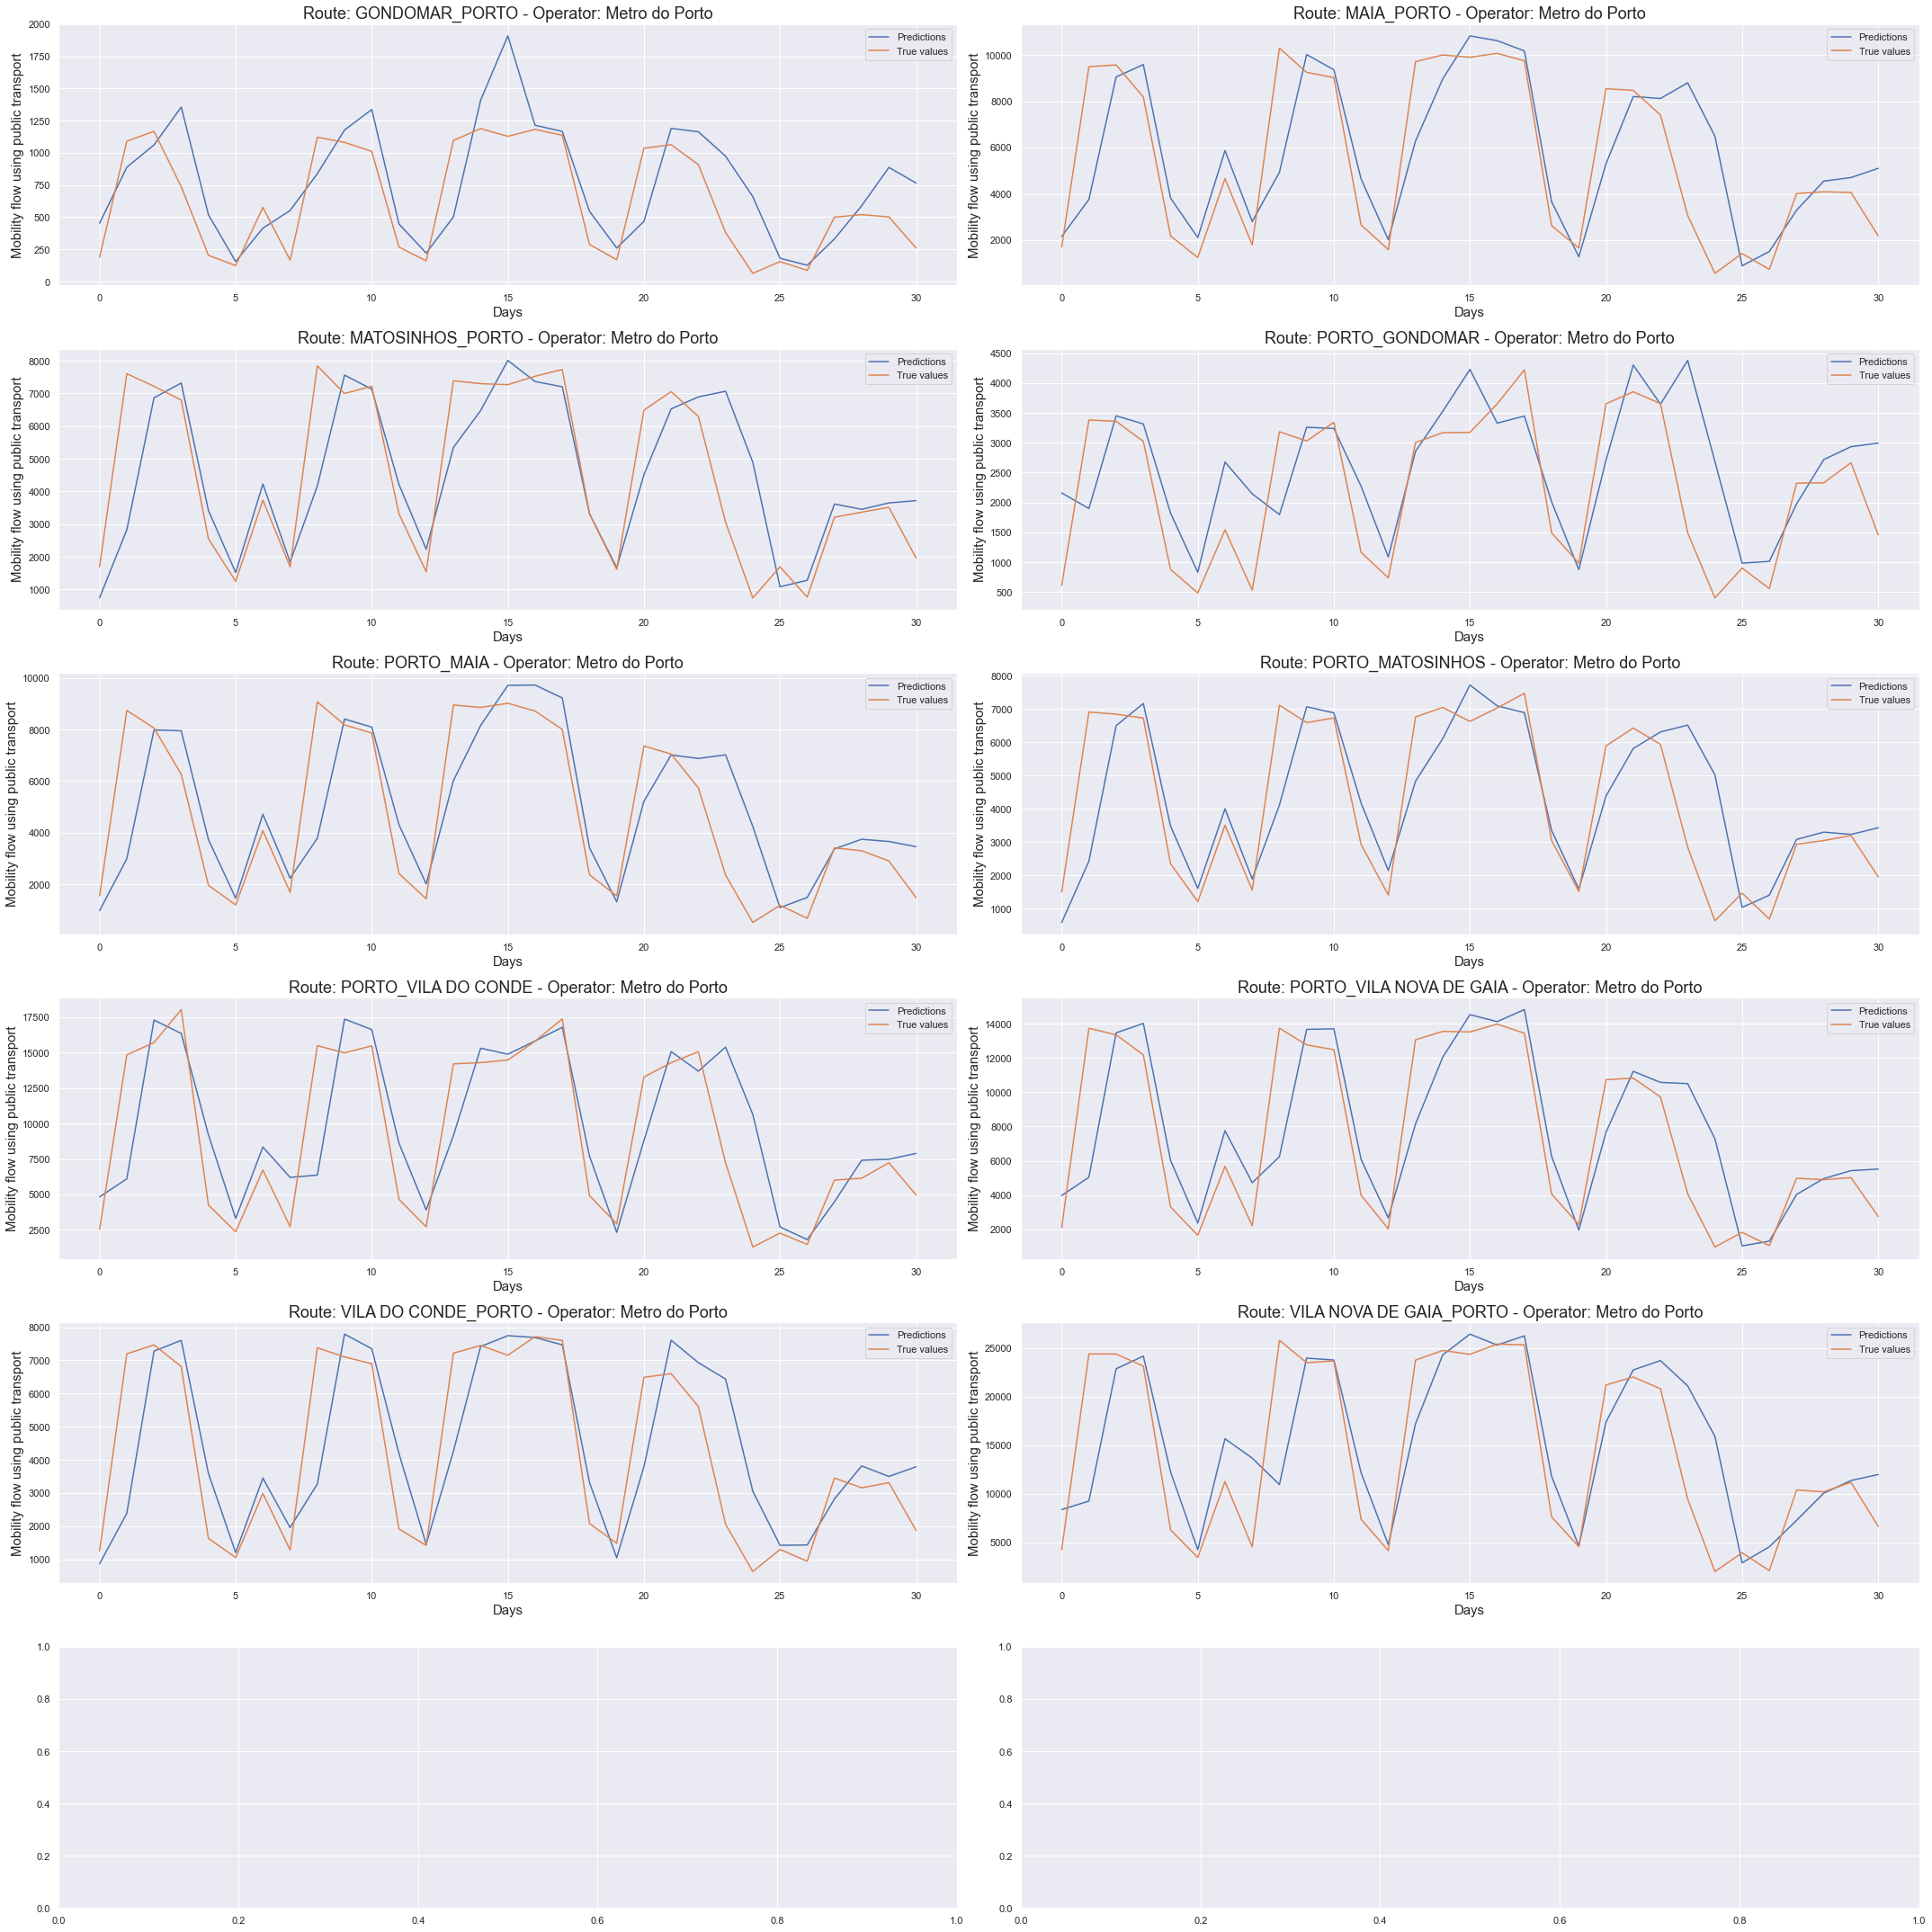

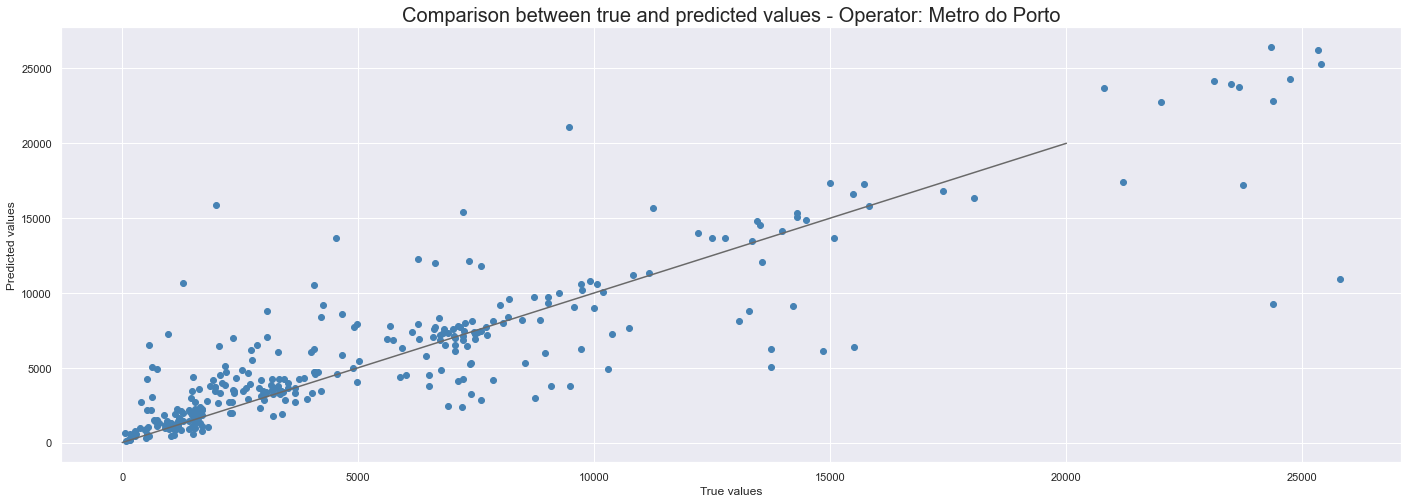

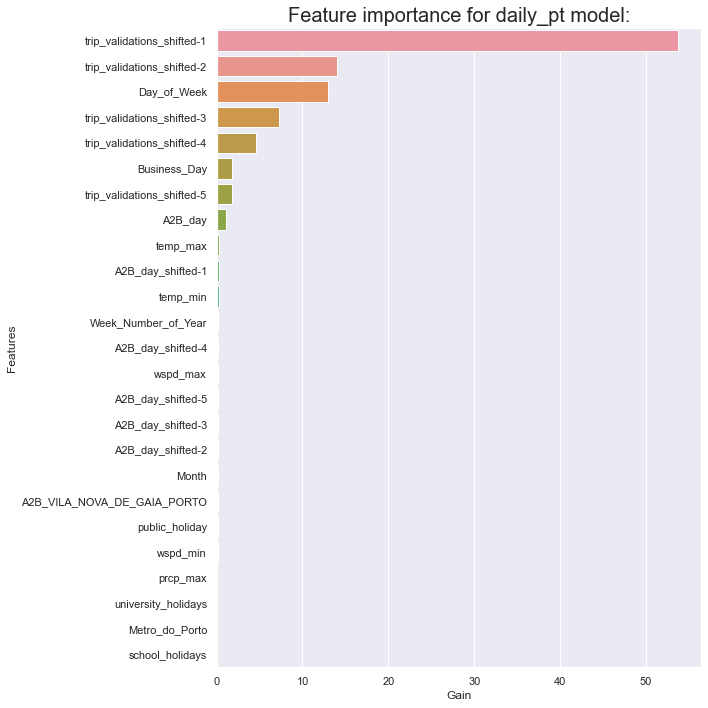

In [327]:
DF_TYPE = "daily_pt"
PENALTY = 4
TUNE = False

df_pt = pd.read_excel('data/mod_z2z_day_groupbycity.xlsx', index_col=0)
# data engineering
df_pt = df_pt.rename(
    columns={
        "EntranceCity": "A",
        "ExitCity": "B",
        "Ano": "year",
        "Mês": "month",
        "Dia": "day",
        "Operador": "operator",
        "Validações": "trip_validations"
        }
    )
df_pt["A"].replace({"GAIA": "VILA NOVA DE GAIA"}, inplace=True)
df_pt["B"].replace({"GAIA": "VILA NOVA DE GAIA"}, inplace=True)
df_pt["date"] = pd.to_datetime(df_pt[["year", "month", "day"]])
df_pt = df_pt.drop(['year', 'month', 'day'], axis=1)

# DUVIDA: LEFT OR INNER ???
# merge with df from Daily Model Prediction of people moving from point A to point B
df = df.merge(df_pt, how='inner', on=['A', 'B', 'date'])
df = df.sort_values(by=['A', 'B', 'date', 'operator'])
df = shifted_features(df, ['A', 'B', 'operator'], "trip_validations")

operators = pd.get_dummies(df['operator'], drop_first=False)
df = pd.concat([df, operators], axis=1)
train, val, test = split_data(df)

# save to use later
df_output_pt = test[['A2B', 'A', 'B', 'date', 'operator', 'trip_validations']].reset_index(drop=True)

Y_train = train['trip_validations']
X_train = train.drop(['trip_validations', 'date', 'A', 'B', 'A2B', 'operator'], axis=1)

Y_val = val['trip_validations']
X_val = val.drop(['trip_validations', 'date', 'A', 'B', 'A2B', 'operator'], axis=1)

Y_test = test['trip_validations']
X_test = test.drop(['trip_validations', 'date', 'A', 'B', 'A2B', 'operator'], axis=1)

if TUNE:
    tune_model_lgb(X_train, Y_train, X_val, Y_val)
else:
    model = train_model_lgb(X_train, Y_train, X_val, Y_val)
    metrics = eval_model(model, X_test, Y_test)

    df_output_pt['predictions'] = metrics[2]

    # save predictions/results
    df_output_pt['predictions'].to_csv(f'results/{DF_TYPE}/{DF_TYPE}_predsLGBM.csv', sep=",")
    save_error_results(metrics)

    # visualize results
    df_output_pt_STCP = df_output_pt[df_output_pt['operator'] == "STCP"]
    df_output_pt_metro = df_output_pt[df_output_pt['operator'] == "Metro do Porto"]
    plot_images(model, df_output_pt_STCP)
    plot_images(model,df_output_pt_metro)

    df_output_pt = get_reasons_for_preds(model, X_test, df_output_pt, '_predictions_mobilityflow_pt').drop(['A2B'], axis=1)
    df_output_pt = df_output_pt.rename(columns={'predictions': 'predictions_mobilityflow_pt'})

    df_output_daily = df_output.merge(df_output_pt, how='left', on=['A', 'B', 'date'])\
        .rename(columns={'predictions': 'predictions_mobilityflow'}) #.to_csv("results/df_output_daily.csv", index=False)

Next, we built another model for the monthly forecast of people moving from point A to point B.

 ******************************************** 
 RESULTS OF MODEL THAT PREDICTS MONTHLY MOBILITY FLOW 
 ******************************************** 


<Figure size 1728x576 with 0 Axes>

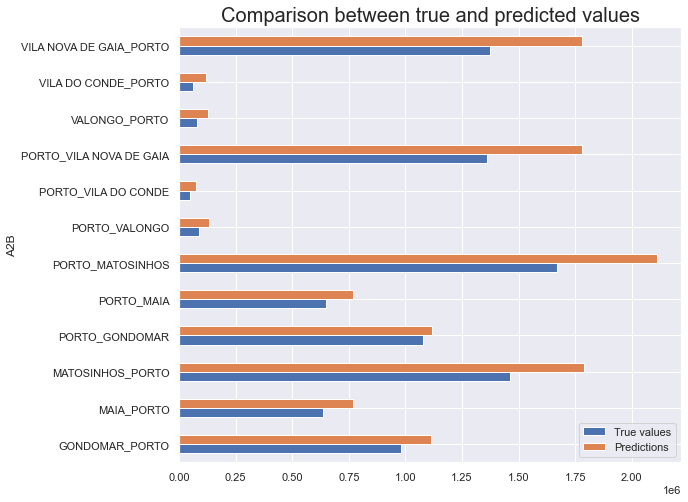

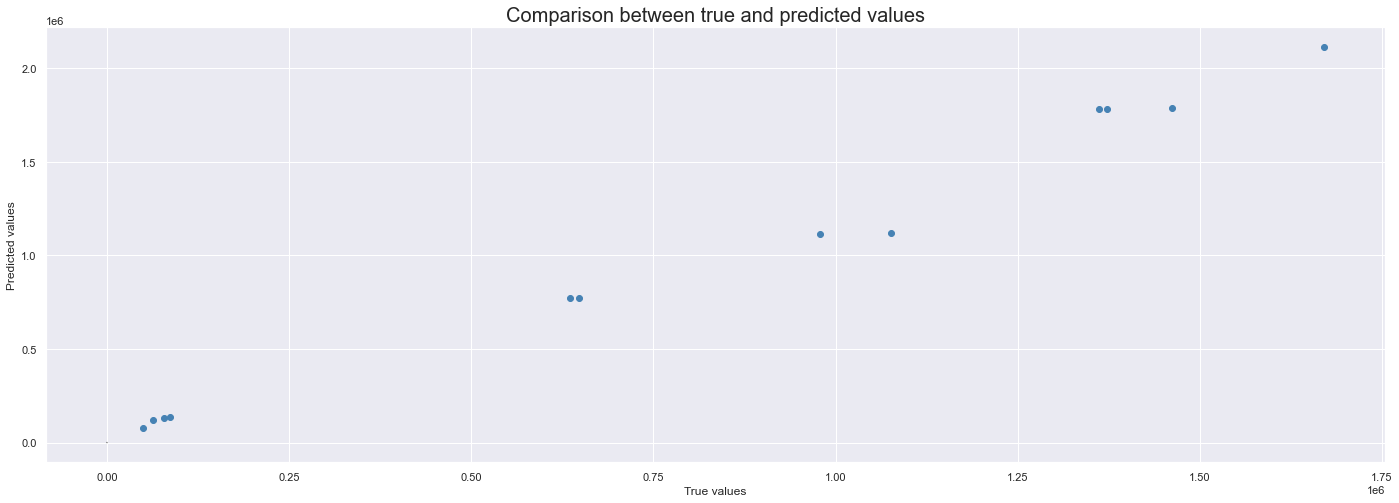

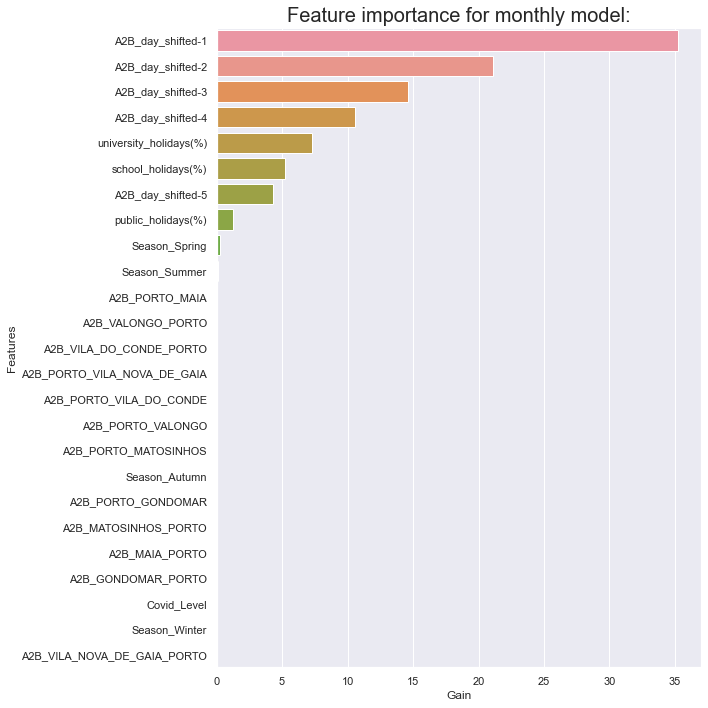

In [328]:
DF_TYPE = "monthly"
PENALTY = 0.5
TUNE = False

df = pd.read_excel("data/nos_mob_porto_month.xlsx")
df = create_features(df)
train, val, test = split_data(df)

# save to use later
df_output = test[['A2B', 'A', 'B', 'Month', 'A2B_day']].reset_index(drop=True)

Y_train = train['A2B_day']
X_train = train.drop(['A2B_day', 'Month', 'A', 'B', 'A2B'], axis=1)

Y_val = val['A2B_day']
X_val = val.drop(['A2B_day', 'Month', 'A', 'B', 'A2B'], axis=1)

Y_test = test['A2B_day']
X_test = test.drop(['A2B_day', 'Month', 'A', 'B', 'A2B'], axis=1)

if TUNE:
    tune_model_lgb(X_train, Y_train, X_val, Y_val)
else:
    model = train_model_lgb(X_train, Y_train, X_val, Y_val)
    metrics = eval_model(model, X_test, Y_test)

    df_output['predictions']=metrics[2]

    # save predictions/results
    df_output.to_csv(f'results/{DF_TYPE}/{DF_TYPE}_predsLGBM.csv', sep=",")
    save_error_results(metrics)

    # visualize results
    plot_images(model, df_output)

    df_output = get_reasons_for_preds(model, X_test, df_output, "_mobilityflow").drop(['A2B'], axis=1)
    df_output.to_csv(f'results/{DF_TYPE}/{DF_TYPE}_df_output.csv', index=False)
    df_output

Finally, we built a model for the monthly forecast of people moving from point A to point B using public transport, namely Metro and STCP.

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[270]	valid_0's custom_asymmetric_eval: 8.29034e+08
 ******************************************** 
 RESULTS OF MODEL THAT PREDICTS MONTHLY MOBILITY FLOW BY PUBLIC TRANSPORT 
 ******************************************** 
 ******************************************** 
 RESULTS OF MODEL THAT PREDICTS MONTHLY MOBILITY FLOW BY PUBLIC TRANSPORT 
 ******************************************** 


<Figure size 1728x576 with 0 Axes>

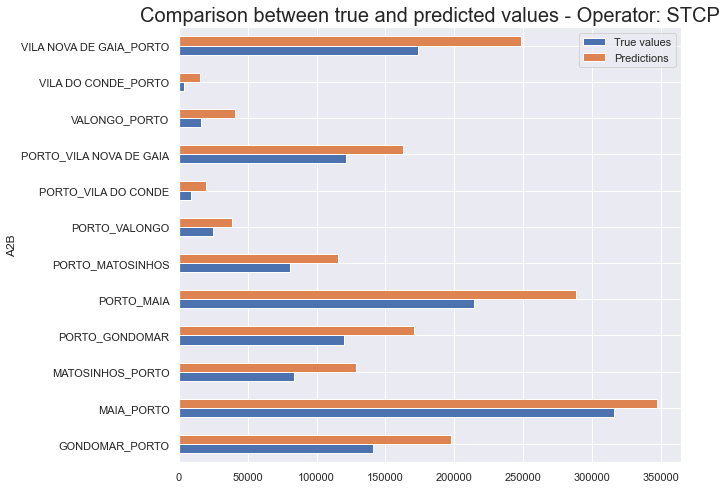

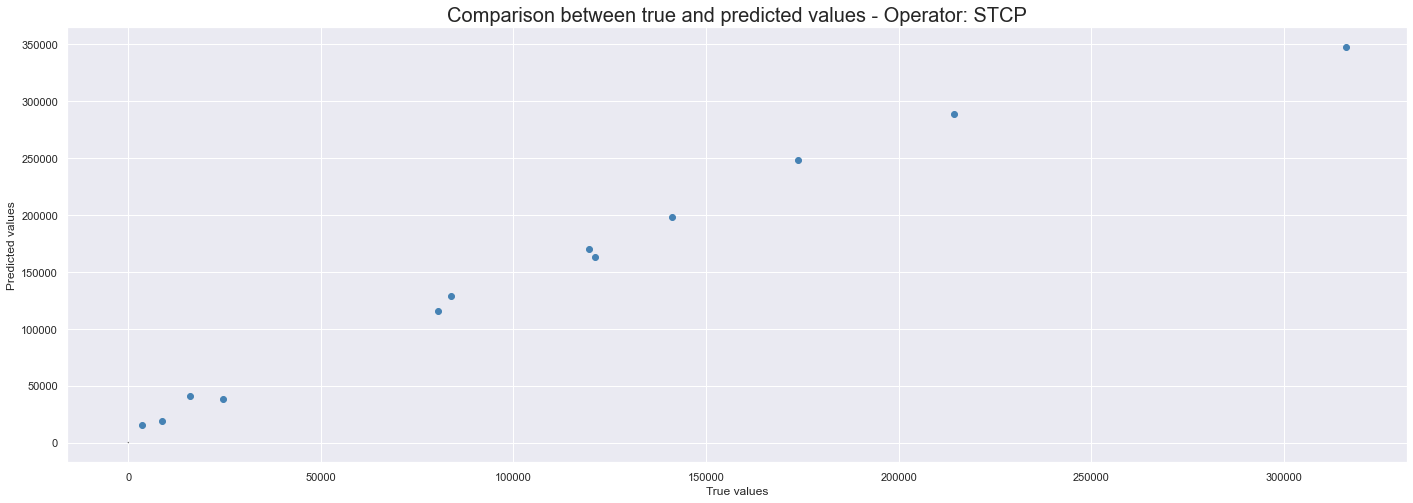

<Figure size 1728x576 with 0 Axes>

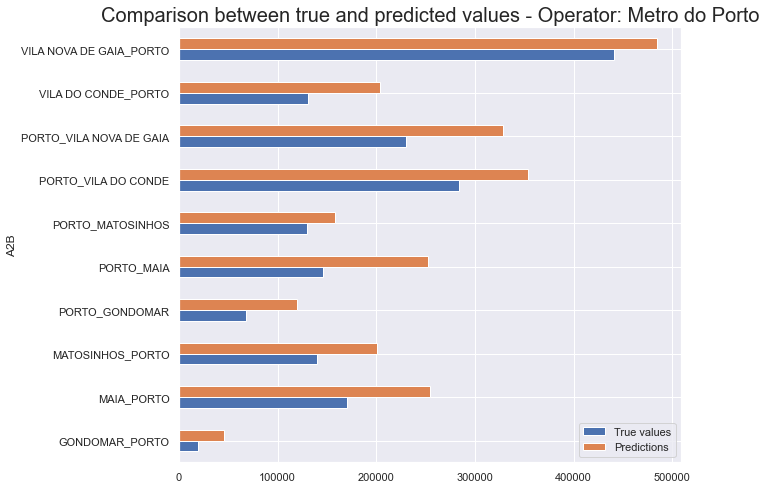

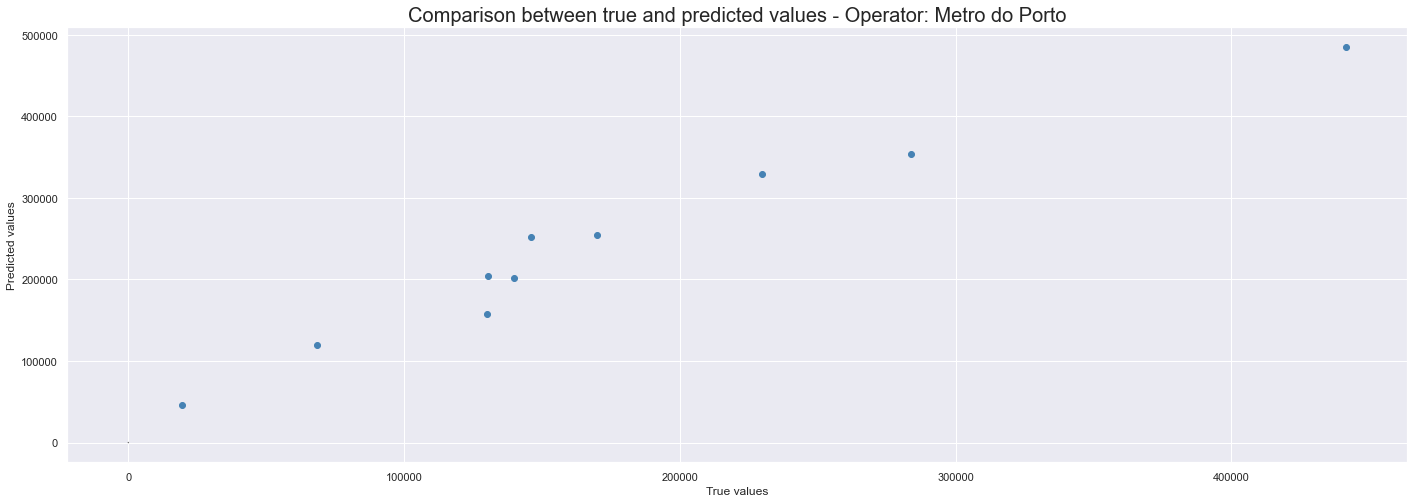

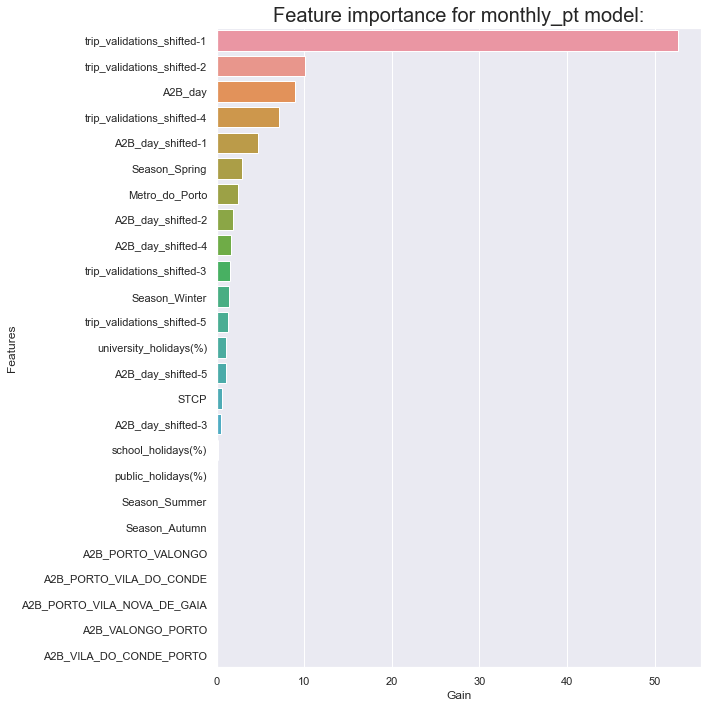

In [329]:
DF_TYPE = "monthly_pt"
PENALTY = 1
TUNE = False

df_pt = pd.read_excel('data/mod_z2z_month_groupbycity.xlsx', index_col=0)
# data engineering
df_pt = df_pt.rename(
    columns={
        "EntranceCity": "A",
        "ExitCity": "B",
        "Ano": "year",
        "Mês": "Month",
        "Operador": "operator",
        "Validações": "trip_validations"
        }
    )
df_pt["A"].replace({"GAIA": "VILA NOVA DE GAIA"}, inplace=True)
df_pt["B"].replace({"GAIA": "VILA NOVA DE GAIA"}, inplace=True)
df_pt = df_pt.drop(['year'], axis=1)

# DUVIDA: LEFT OR INNER ???
# merge with df from Monthy Model Prediction of people moving from point A to point B
df = df.merge(df_pt, how='inner', on=['A', 'B', 'Month'])
df = df.sort_values(by=['A', 'B', 'Month', 'operator'])
df = shifted_features(df, ['A', 'B', 'operator'], "trip_validations")

operators = pd.get_dummies(df['operator'], drop_first=False)
df = pd.concat([df, operators], axis=1)
train, val, test = split_data(df)

# save to use later
df_output_pt = test[['A2B', 'A', 'B', 'Month', 'operator', 'trip_validations']].reset_index(drop=True)

Y_train = train['trip_validations']
X_train = train.drop(['trip_validations', 'Month', 'A', 'B', 'A2B', 'operator'], axis=1)

Y_val = val['trip_validations']
X_val = val.drop(['trip_validations', 'Month', 'A', 'B', 'A2B', 'operator'], axis=1)

Y_test = test['trip_validations']
X_test = test.drop(['trip_validations', 'Month', 'A', 'B', 'A2B', 'operator'], axis=1)

if TUNE:
    tune_model_lgb(X_train, Y_train, X_val, Y_val)
else:
    model = train_model_lgb(X_train, Y_train, X_val, Y_val)
    metrics = eval_model(model, X_test, Y_test)

    df_output_pt['predictions'] = metrics[2]

    # save predictions/results
    df_output_pt['predictions'].to_csv(f'results/{DF_TYPE}/{DF_TYPE}_predsLGBM.csv', sep=",")
    save_error_results(metrics)

    # visualize results
    df_output_pt_STCP = df_output_pt[df_output_pt['operator'] == "STCP"]
    df_output_pt_metro = df_output_pt[df_output_pt['operator'] == "Metro do Porto"]
    plot_images(model, df_output_pt_STCP)
    plot_images(model,df_output_pt_metro)

    df_output_pt = get_reasons_for_preds(model, X_test, df_output_pt, '_predictions_mobilityflow_pt').drop(['A2B'], axis=1)
    df_output_pt = df_output_pt.rename(columns={'predictions': 'predictions_mobilityflow_pt'})

    df_output_monthly = df_output.merge(df_output_pt, how='left', on=['A', 'B', 'Month'])\
        .rename(columns={'predictions': 'predictions_mobilityflow'}) #.to_csv("results/df_output_monthly.csv", index=False)

These were the final datasets that resulted from this step and that will be used by the final product. 

In [330]:
df_output_daily

A      B       date  A2B_day  predictions_mobilityflow  \
0             GONDOMAR  PORTO 2020-12-01    24621              30128.475063   
1             GONDOMAR  PORTO 2020-12-01    24621              30128.475063   
2             GONDOMAR  PORTO 2020-12-02    42850              26643.681106   
3             GONDOMAR  PORTO 2020-12-02    42850              26643.681106   
4             GONDOMAR  PORTO 2020-12-03    39872              40865.948823   
..                 ...    ...        ...      ...                       ...   
677  VILA NOVA DE GAIA  PORTO 2020-12-29    46372              43914.153733   
678  VILA NOVA DE GAIA  PORTO 2020-12-30    46801              44898.884030   
679  VILA NOVA DE GAIA  PORTO 2020-12-30    46801              44898.884030   
680  VILA NOVA DE GAIA  PORTO 2020-12-31    38681              44996.773688   
681  VILA NOVA DE GAIA  PORTO 2020-12-31    38681              44996.773688   

    reason_1_mobilityflow reason_2_mobilityflow        operator  \
0                temp_min           Day_of_Week  Metro do Porto   
1                temp_min           Day_of_Week            STCP   
2                temp_min                 Month  Metro do Porto   
3                temp_min                 Month            STCP   
4                   Month           Day_of_Week  Metro do Porto   
..                    ...                   ...             ...   
677           Day_of_Week                 Month            STCP   
678                 Month              wspd_max  Metro do Porto   
679                 Month              wspd_max            STCP   
680                 Month           Day_of_Week  Metro do Porto   
681                 Month           Day_of_Week            STCP   

     trip_validations  predictions_mobilityflow_pt  \
0                 189                   453.136068   
1                1544                  1433.997010   
2                1090                   887.715698   
3                7250                  3281.996444   
4                1167                  1061.312773   
..                ...                          ...   
677              4134                  3924.545764   
678             11164                 11349.615711   
679              5003                  5567.780535   
680              6632                 11967.491872   
681              3310                  5408.713555   

    reason_1_predictions_mobilityflow_pt reason_2_predictions_mobilityflow_pt  
0                         public_holiday                          Day_of_Week  
1                         public_holiday                          Day_of_Week  
2                            Day_of_Week                             prcp_min  
3                            Day_of_Week                             temp_min  
4                            Day_of_Week                         Business_Day  
..                                   ...                                  ...  
677                          Day_of_Week                             temp_min  
678                          Day_of_Week                         Business_Day  
679                          Day_of_Week                             temp_max  
680                          Day_of_Week                         Business_Day  
681                          Day_of_Week                             temp_max  

[682 rows x 12 columns]

In [331]:
df_output_monthly

A                  B  Month  A2B_day  \
0            GONDOMAR              PORTO     12   978770   
1            GONDOMAR              PORTO     12   978770   
2                MAIA              PORTO     12   635370   
3                MAIA              PORTO     12   635370   
4          MATOSINHOS              PORTO     12  1461187   
5          MATOSINHOS              PORTO     12  1461187   
6               PORTO           GONDOMAR     12  1076371   
7               PORTO           GONDOMAR     12  1076371   
8               PORTO               MAIA     12   647704   
9               PORTO               MAIA     12   647704   
10              PORTO         MATOSINHOS     12  1670962   
11              PORTO         MATOSINHOS     12  1670962   
12              PORTO            VALONGO     12    86684   
13              PORTO      VILA DO CONDE     12    49216   
14              PORTO      VILA DO CONDE     12    49216   
15              PORTO  VILA NOVA DE GAIA     12  1361750   
16              PORTO  VILA NOVA DE GAIA     12  1361750   
17            VALONGO              PORTO     12    78632   
18      VILA DO CONDE              PORTO     12    63847   
19      VILA DO CONDE              PORTO     12    63847   
20  VILA NOVA DE GAIA              PORTO     12  1372794   
21  VILA NOVA DE GAIA              PORTO     12  1372794   

    predictions_mobilityflow   reason_1_mobilityflow reason_2_mobilityflow  \
0               1.112620e+06  university_holidays(%)    school_holidays(%)   
1               1.112620e+06  university_holidays(%)    school_holidays(%)   
2               7.700257e+05  university_holidays(%)    school_holidays(%)   
3               7.700257e+05  university_holidays(%)    school_holidays(%)   
4               1.788305e+06  university_holidays(%)    school_holidays(%)   
5               1.788305e+06  university_holidays(%)    school_holidays(%)   
6               1.118339e+06  university_holidays(%)    school_holidays(%)   
7               1.118339e+06  university_holidays(%)    school_holidays(%)   
8               7.700257e+05  university_holidays(%)    school_holidays(%)   
9               7.700257e+05  university_holidays(%)    school_holidays(%)   
10              2.111868e+06  university_holidays(%)    school_holidays(%)   
11              2.111868e+06  university_holidays(%)    school_holidays(%)   
12              1.345761e+05  university_holidays(%)    school_holidays(%)   
13              7.672614e+04  university_holidays(%)    school_holidays(%)   
14              7.672614e+04  university_holidays(%)    school_holidays(%)   
15              1.779052e+06  university_holidays(%)    school_holidays(%)   
16              1.779052e+06  university_holidays(%)    school_holidays(%)   
17              1.299061e+05  university_holidays(%)    school_holidays(%)   
18              1.186654e+05  university_holidays(%)    school_holidays(%)   
19              1.186654e+05  university_holidays(%)    school_holidays(%)   
20              1.779052e+06  university_holidays(%)    school_holidays(%)   
21              1.779052e+06  university_holidays(%)    school_holidays(%)   

          operator  trip_validations  predictions_mobilityflow_pt  \
0   Metro do Porto             19560                 45975.812165   
1             STCP            141206                197745.244243   
2   Metro do Porto            169882                254012.518051   
3             STCP            316080                347382.637614   
4   Metro do Porto            139829                201199.620962   
5             STCP             83671                128341.674025   
6   Metro do Porto             68263                119900.308087   
7             STCP            119545                170387.432381   
8   Metro do Porto            145936                252280.034527   
9             STCP            214306                288501.924698   
10  Metro do Porto            129897                157761.820397   
11            ST

These were the results of the MAPE errors for each of the models:

In [333]:
#define header names
col_names = ["Model", "MAPE (%)"]

#Results table
data_hourly = [
    ["Daily forecast of people moving from point A-B", 60], 
    ["Daily forecast of people moving from point A-B by public transport", 38], 
    ["Monthly forecast of people moving from point A-B", 24],
    ["Monthly forecast of people moving from point A-B by public transport", 34]
]

#display table
print(tabulate(data_hourly, headers=col_names, tablefmt="fancy_grid"))

╒══════════════════════════════════════════════════════════════════════╤════════════╕
│ Model                                                                │   MAPE (%) │
╞══════════════════════════════════════════════════════════════════════╪════════════╡
│ Daily forecast of people moving from point A-B                       │         60 │
├──────────────────────────────────────────────────────────────────────┼────────────┤
│ Daily forecast of people moving from point A-B by public transport   │         38 │
├──────────────────────────────────────────────────────────────────────┼────────────┤
│ Monthly forecast of people moving from point A-B                     │         24 │
├──────────────────────────────────────────────────────────────────────┼────────────┤
│ Monthly forecast of people moving from point A-B by public transport │         34 │
╘══════════════════════════════════════════════════════════════════════╧════════════╛


## 🖼️ Visualisations

Here are some examples of the final product. The main idea is to present a Power BI dashboard that classifies the inter-municipality public transport routes that need the most intervention in the forseeing days as well as the forecasts for the global citizen inter-municipality mobility and the citizen inter-municipality mobility in the public transportation system in the following days. 

In this example we use predictions for the final week of data of our dataset.

The dashboard can be fully adapted to the needs of the users and we expect for it to be used to take decisions such as:

-Next Monday I need to go from Matosinhos to Porto, but I don't know how to go. If I use my car, but then I need to park it, which will be a nightmare, or if I take the bus or subway, which can be super crowded and which will make it super uncomfortable, as I'm still a little apprehensive about to the Covid situation; By using the dashboard, that person can now understand the rate of use of the bus/metro lines that will take the route that the person wants and, thus, be able to make the best decision, which, in this case, would not be a problem to go by public transport, whether subway or bus, as they won't be too crowded.  

With the implementation of these measures, we hope to bring positive changes to the lifestyle of Stadhouderskade, increasing people's confidence in using public transpors and also helping the city of Porto to reduce its level of traffic.

<img src="Captura de ecrã 2022-04-23 094029.png" width="800" height="500">
<img src="Captura de ecrã 2022-04-23 100309.png" width="800" height="500">
<img src="Captura de ecrã 2022-04-23 100406.png" width="800" height="500">

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

- https://www.stcp.pt/pt/institucional/governo-societario/indicadores-chave/
- https://www.metrodoporto.pt/pages/308
- http://tram-porto.ernstkers.nl/MPtrams.html